# Web Scraping

Web scraping is the automated gathering of data from the internet. This is most commonly accomplished by writing an automated program that queries a web server, requests data (usually in the form of the HTML and other files that comprise web pages), and then parses that data to extract needed information. 

**APIs**

APIs can be fantastic, if you find one that suits your purposes. They can provide a convenient stream of well-formatted data from one server to another. In general, it is preferable to use an API (if one exists), rather than build a bot to get the same data. 

However, there are several reasons why an API might not exist:
- You are gathering data across a collection of sites that do not have a cohesive API. 
- The data you want is a fairly small, finite set that the webmaster did not think warranted an API. 
- The source does not have the infrastructure or technical ability to create an API. 

Even when an API *does* exist, request volume and rate limits, the type of data, or the format of data that it provides might be insufficient for your purposes. 

This is where web scraping steps in. With few exceptions, if you can view it in your browser, you can access it via Python script. 

## Part I -  Building Scrapers

### Chapter 1. Your First Web Scraper
Will cover the basics of sending a GET request to a web server for a specific page, reading the HTML output from that page, and doing some simple data extraction in order to isolate the content we are looking for. 

`urlib` is a standard Python library (meaning you don't have to install anything extra to run this example) that contains functions for requesting data across the web, handling cookies, and even changing metadata such as headers and your user agent. 
- `urlopen` is used to open a remote object across a network and read it. 

In [1]:
from urllib.request import urlopen
html = urlopen("http://pythonscraping.com/pages/page1.html")
print(html.read())

b'<html>\n<head>\n<title>A Useful Page</title>\n</head>\n<body>\n<h1>An Interesting Title</h1>\n<div>\nLorem ipsum dolor sit amet, consectetur adipisicing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.\n</div>\n</body>\n</html>\n'


**An Introduction to BeautifulSoup**

The BeautifulSoup library helps format and organize the messy web by fixing bad HTML and presenting us with easily-traversible Python objects representing XML structures. 

The most commonly used object in the BeautifulSoup library is the BeautifulSoup object.

In [2]:
# !pip install beautifulsoup4

In [3]:
from bs4 import BeautifulSoup

In [9]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("http://pythonscraping.com/pages/page1.html")
bsObj = BeautifulSoup(html.read());

# some bsObj attributes
print(bsObj.h1)
print(bsObj.title)
print(bsObj.title.string)

<h1>An Interesting Title</h1>
<title>A Useful Page</title>
A Useful Page
None


In the example above, we are importing the urlopen library and calling `html.read()` in order to get the HTML content of the page. This HTML content is then transformed into a BeautifulSoup object, with the following structure: 
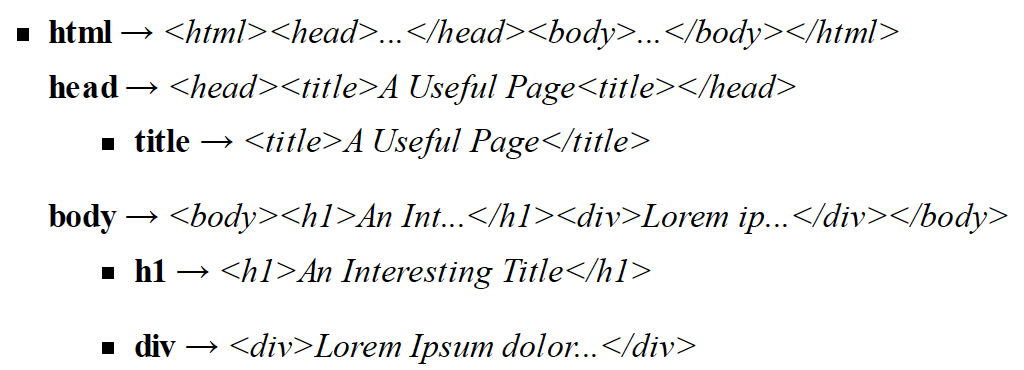

Note that the h1 tag we extracted from the page was nested two layers deep into our BeautifulSoup object structure (html --> body --> h1). However, when we actually fetched it from the object, we called the h1 tag directly: `bsObj.h1`. 

Virtually any information can be extracted from any HTML (or XML) file, as long as it has some identifying tag surrounding it. 

**Connecting Reliability**

Let’s take a look at the first line of our scraper, after the import statements, and
figure out how to handle any exceptions this might throw:
```python
html = urlopen("http://www.pythonscraping.com/exercises/exercise1.html")```

There are two main things that can go wrong in this line: 
- The page is not found on the server (or there was some error in retrieving it)
    - An HTTP error will be returned. This HTTP error may be "404 Page Not Found", "500 Internal Server Error", etc. But in all of these cases, the `urlopen` function will throw the generic exception "HTTPError".
- The server was not found

```python
# handling the HTTPError
try:
    html = urlopen("http://www.pythonscraping.com/exercises/exercise1.html")
except HTTPError as e:
    print(e)
    #return null, break, or do some other "Plan B"
else:
    #program continues. Note: If you return or break in the
    #exception catch, you do not need to use the "else" statement```

Of course, if the page is retrieved successfully from the server, there is still the issue of the content on the page not quite being what you expected. Everytime you access a tag in a BeautifulSoup object, it's smart to add a check to make sure that the tag actually exists. If you attempt to access a tag that does not exist, BeautifulSoup will return a None object. The problem is, attempting to access a tag on a None object itself will result in an AttributeError being thrown. 

In [7]:
print(bsObj.nonExistentTag)

None


/Applications/anaconda3/lib/python3.7/site-packages/bs4/element.py:1050: UserWarning: .nonExistentTag is deprecated, use .find("nonExistent") instead.
  tag_name, tag_name))


The best thing to do is to explicitly check for both situations. 

In [9]:
try:
    badContent = bsObj.nonExistingTag.anotherTag
except AttributeError as e:
    print("Tag was not found")
else:
    if badContent == None:
        print ("Tag was not found")
    else:
        print(badContent)

Tag was not found


/Applications/anaconda3/lib/python3.7/site-packages/bs4/element.py:1050: UserWarning: .nonExistingTag is deprecated, use .find("nonExisting") instead.
  tag_name, tag_name))


This code, is our same scraper written in a slightly different way:

In [11]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

In [12]:
def getTitle(url):
    try:
        html = urlopen(url)
    except HTTPError as e:
        return None
    try: 
        bsObj = BeautifulSoup(html.read())
        title = bsObj.body.h1
    except AttributeError as e:
        return None
    return title

In [14]:
title = getTitle("http://www.pythonscraping.com/exercises/exercise1.html")

if title == None:
    print('Title could not be found')
else:
    print(title)

<h1>An Interesting Title</h1>


In this example, we're creating a function `getTitle` which returns either the title of the page, or a `None` object if there was some problem with retrieving it. 

When writing scrapers, it is important to think about the overall pattern of your code in order to handle exceptions and make it readable at the same time. Having generic functions complete with thorough exception handling makes it easy to quickly -- and reliably -- scrape the web. 

### Chapter 2. Advanced HTML Parsing
It can be tempting to dive right in and use multiline statements to try to extract your information. However, this can lead to code that is difficult to debug or fragile. 

Let's say you dive right in and write something like this to attempt extraction: 
```python
bsObj.findAll("table")[4].findAll("tr")[2].find("td").findAll("div")[1].find("a")
```

In addition to the aesthetics of the line, even the slightest change to the website by a site administrator might break your web scraper altogether. So what are your options? 
- Look for a "print this page" link, or perhaps a mobile version of the site that has better-formatted HTML
- Look got information hidden in a JavaScript file. 
- If the information you are looking for is unique to this website for some reason, you're out of luck. If not, try to think of other sources you could get this information from. 

Especially when faced with buried or poorly formatted data, it's important not to just start digging. Take a deep breath and think of alternatives. 

**Another Serving of BeautifulSoup**

Nearly every website you encounter contains stylesheets. This makes webscarping harder because it differentiates HTML elements. 
That is,
some tags might look like this:
```HTML
<span class="green"></span>
```
while others look like this:
```HTML
<span class="red"></span>
```

Web scrapers can easily seperate these two different tags based on their class; for example, they might use BeautifulSoup to grab all the red text but none of the green text. 

Let's create an example web scraper that scrapes the page located at http://bit.ly/1Ge96Rw

In [16]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen('http://www.pythonscraping.com/pages/warandpeace.html')
bsObj = BeautifulSoup(html)

print(bsObj)

<html>
<head>
<style>
.green{
	color:#55ff55;
}
.red{
	color:#ff5555;
}
#text{
	width:50%;
}
</style>
</head>
<body>
<h1>War and Peace</h1>
<h2>Chapter 1</h2>
<div id="text">
"<span class="red">Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by
that Antichrist- I really believe he is Antichrist- I will have
nothing more to do with you and you are no longer my friend, no longer
my 'faithful slave,' as you call yourself! But how do you do? I see
I have frightened you- sit down and tell me all the news.</span>"
<p></p>
It was in July, 1805, and the speaker was the well-known <span class="green">Anna
Pavlovna Scherer</span>, maid of honor and favorite of the <span class="green">Empress Marya
Fedorovna</span>. With these words she greeted <span class="green">Prince Vasili Kuragin</span>, a man
of high rank and importance, who was the firs

/Applications/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Applications/anaconda3/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Using this BeautifulSoup object, we can use the `findAll` function to extract a Python list of words that were in green text on the html page. 

In [17]:
greenList = bsObj.findAll("span",{"class":"green"})
for item in greenList:
    print(item.get_text())

Anna
Pavlovna Scherer
Empress Marya
Fedorovna
Prince Vasili Kuragin
Anna Pavlovna
St. Petersburg
the prince
Anna Pavlovna
Anna Pavlovna
the prince
the prince
the prince
Prince Vasili
Anna Pavlovna
Anna Pavlovna
the prince
Wintzingerode
King of Prussia
le Vicomte de Mortemart
Montmorencys
Rohans
Abbe Morio
the Emperor
the prince
Prince Vasili
Dowager Empress Marya Fedorovna
the baron
Anna Pavlovna
the Empress
the Empress
Anna Pavlovna's
Her Majesty
Baron
Funke
The prince
Anna
Pavlovna
the Empress
The prince
Anatole
the prince
The prince
Anna
Pavlovna
Anna Pavlovna


**When to `get_text()` and when to preserve tags**

`.get_text()` strips all tags from the document you are working with and returns a string containing the text only. 

Keep in mind that it's much easier to find what you're looking for in a BeautifulSoup object than in a block of text. In general, you try to preserve the tag structure of a document as long as possible. 

**`find()` and `findAll()` with BeautifulSoup**

- `findAll(tag, attributes, recursive, text, limit, keywords)`
- `find(tag, attributes, recursive, text, keywords)`

95% of the time you will find yourself only needing to use the first two arguments: tag and attributes. 
    - the `tag` argument - you can pass a string name of a tag or even a Python list of string tag names. For example, the following will return a list of all the header tags in a document. 
```python
           .findAll({'h1','h2','h3','h4','h5','h6'})
```
- the `attributes` argument takes a Python dictionary of attributes and matches taags that contain any one of those attributes. For example, the following function would return *both* the green and red span tags in the HTML document. 
```python
            .findAll("span",{"class":"green","class":"red"})
```
- the `recursive` argument specifies how deeply into the document you want to go. If recursion is set to `True` (the default), the `findAll` function looks into children, and children's children, for tags that match your parameters. If it is set to `False`, it will look only at the top-level tags in your document. 
    - the `text` argument is unusual because it matches based on the text content of the tags, rather than properties of the tags themselves. 
    - the `limit` argument, is only used in the `findAll` method. `find` is equivalent to the `findAll` call with limit of 1. You might set htis if you're only interested in retrieving the first x items from the page. 
    - the `keyword` argument allows you to select tags that contain a particular attribute. This argument can be helpful in some situations. However, it is technically redundant as a BeautifulSoup feature. 
    
**Other BeautifulSoup Objects**

So far, you've seen two types of objects in the BeautifulSoup library.
1. *BeautifulSoup* objects
2. *Tag* objects
- retrieved in lists or individually by calling `find` and `findAll` on a `BeautifulSoup` object. 
There are two more objects in the library that are important too:
3. *NavigableString* objects
- used to represent text within tags, rather than the tags themselves. 
4. The *Comment* object
- used to find HTML comments in comment tags

**Navigating Trees**

The `findAll` function is responsible for finding tags based on their name and attribute. But what if you need to find a tag based on its location in a document? That's where tree navigation comes in handy.

In the BeautifulSoup library, there is a distinction drawn between *children* and *descendants*. Children are always exactly one tag below a parent, whereas descendants can be at any lebel in the tree below a parent. In general, BeautifulSoup functions will always deal with the descendants of the current tag selected.

In [18]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("http://www.pythonscraping.com/pages/page3.html")
bsObj = BeautifulSoup(html)

for child in bsObj.find("table",{"id":"giftList"}).children:
    print(child)



<tr><th>
Item Title
</th><th>
Description
</th><th>
Cost
</th><th>
Image
</th></tr>


<tr class="gift" id="gift1"><td>
Vegetable Basket
</td><td>
This vegetable basket is the perfect gift for your health conscious (or overweight) friends!
<span class="excitingNote">Now with super-colorful bell peppers!</span>
</td><td>
$15.00
</td><td>
<img src="../img/gifts/img1.jpg"/>
</td></tr>


<tr class="gift" id="gift2"><td>
Russian Nesting Dolls
</td><td>
Hand-painted by trained monkeys, these exquisite dolls are priceless! And by "priceless," we mean "extremely expensive"! <span class="excitingNote">8 entire dolls per set! Octuple the presents!</span>
</td><td>
$10,000.52
</td><td>
<img src="../img/gifts/img2.jpg"/>
</td></tr>


<tr class="gift" id="gift3"><td>
Fish Painting
</td><td>
If something seems fishy about this painting, it's because it's a fish! <span class="excitingNote">Also hand-painted by trained monkeys!</span>
</td><td>
$10,005.00
</td><td>
<img src="../img/gifts/img3.jpg"/>


Note that if you were to write it using the `descendants()` function instead of the `children()` function, about two dozen tags would be found within the table. 

In [19]:
for descendent in bsObj.find("table",{"id":"giftList"}).descendants:
    print(descendent)



<tr><th>
Item Title
</th><th>
Description
</th><th>
Cost
</th><th>
Image
</th></tr>
<th>
Item Title
</th>

Item Title

<th>
Description
</th>

Description

<th>
Cost
</th>

Cost

<th>
Image
</th>

Image



<tr class="gift" id="gift1"><td>
Vegetable Basket
</td><td>
This vegetable basket is the perfect gift for your health conscious (or overweight) friends!
<span class="excitingNote">Now with super-colorful bell peppers!</span>
</td><td>
$15.00
</td><td>
<img src="../img/gifts/img1.jpg"/>
</td></tr>
<td>
Vegetable Basket
</td>

Vegetable Basket

<td>
This vegetable basket is the perfect gift for your health conscious (or overweight) friends!
<span class="excitingNote">Now with super-colorful bell peppers!</span>
</td>

This vegetable basket is the perfect gift for your health conscious (or overweight) friends!

<span class="excitingNote">Now with super-colorful bell peppers!</span>
Now with super-colorful bell peppers!


<td>
$15.00
</td>

$15.00

<td>
<img src="../img/gifts/img1.jpg"

The BeautifulSoup `next_siblings()` function makes it trivial to collect data from tables, especially ones with title rows:

In [20]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("http://www.pythonscraping.com/pages/page3.html")
bsObj = BeautifulSoup(html)

for sibling in bsObj.find("table",{"id":"giftList"}).tr.next_siblings:
    print(sibling)



<tr class="gift" id="gift1"><td>
Vegetable Basket
</td><td>
This vegetable basket is the perfect gift for your health conscious (or overweight) friends!
<span class="excitingNote">Now with super-colorful bell peppers!</span>
</td><td>
$15.00
</td><td>
<img src="../img/gifts/img1.jpg"/>
</td></tr>


<tr class="gift" id="gift2"><td>
Russian Nesting Dolls
</td><td>
Hand-painted by trained monkeys, these exquisite dolls are priceless! And by "priceless," we mean "extremely expensive"! <span class="excitingNote">8 entire dolls per set! Octuple the presents!</span>
</td><td>
$10,000.52
</td><td>
<img src="../img/gifts/img2.jpg"/>
</td></tr>


<tr class="gift" id="gift3"><td>
Fish Painting
</td><td>
If something seems fishy about this painting, it's because it's a fish! <span class="excitingNote">Also hand-painted by trained monkeys!</span>
</td><td>
$10,005.00
</td><td>
<img src="../img/gifts/img3.jpg"/>
</td></tr>


<tr class="gift" id="gift4"><td>
Dead Parrot
</td><td>
This is an ex-parr

The code above prints all rows of products from the profuct table, except for the first title row. This title row gets skipped for two reasons. 1. objects cannot be siblings with themselves 2. this function calls *next* siblings only. If we were to select a row in the middle of the list, for example, and call `next_siblings` on it, only the subsequent (next) siblings would be returned. So by selecting the title row and calling `next_siblings`, we can select all the rows in the table, without selecting the title row itself. 

**Make Selections Specific**

Even if it looks like there's just one table (or other target tag) on the page, it's easy to miss things. In addition, page layouts change all the time. What was once the first of its kind on the page, might someday be the second or third tag of that type found on the page. To make your scrapers more robust, it's best to be as specific as possible when making tag selections. 

**Dealing with your parents**

When scraping pages, you will likely discover that you need to find parents of tags less frequently than you need to find their children or siblings. Typically when we look at HTML pages with the goal of crawling them, we start by looking at the top layer of tags, and then figure out how to drill our way down to the exact piece of data that we want. Occasionally, however, you can find yourself in odd situations that require BeautifulSoup's parent-finding functions, `.parent` and `.parents`. 

In [21]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
html = urlopen("http://www.pythonscraping.com/pages/page3.html")
bsObj = BeautifulSoup(html)
print(bsObj.find("img",{"src":"../img/gifts/img1.jpg"}).parent.previous_sibling.get_text())


$15.00



What happens in the code above?

1. The image tag where `src="../img/gifts/img1.jpg"` is first selected.
2. We select the parent of that tag (the `<td>` tag).
3. We select the `previous_sibling` of the `<td>` tag (the `<td>` tag that contains the dollar value of the product).
4. We select the text within that tag, "$15.00"

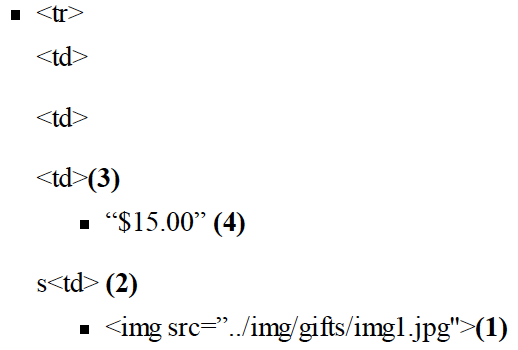

**Regular Expressions**

What is a regular string? It's any string that can be generated by a series of linear rules. Regular expressions are merely a shorthand way of expressing these sets of rules. When attempting to write any regular expression from scratch, it's best to first make a list of steps that concretely outlines what your target string looks like. Pay close attention to edge cases. 

Heres an example regular expression for capturing emails: ```[A-Za-z0-9\._+]+@[A-Za-z]+\.(com|org|edu|net)```

|Symbol(s)|Meaning|Example|Example Matches|
|---------|-------|-------|---------------|
|`*`|Matches the preceding character, subexpression,or bracketed character, 0 or more times|`a*b*`|aaaaaaa,aaaabbbbb,bbbbb|
|`+`|Matches the preceding character, subexpression, or bracketed character, 1 or more times | `a+b+`|aaaaaab,aaabbbb,abbbbbb|
|`[]`|Matches any character wihin the brackets (i.e., "pick any one of these things")|`[A-Z]*`|APPLE,CAPITALS,QWERTY|
|`( )`| A grouped subexpression (these are evaluated first, in the "order of operations" of regular expressions)| `(a*b)*`| aaabaab,abaaab,ababaaaab|
|`{m,n}`|Matches the preceding character, subexpression, or bracketed character between m and n times (inclusive)| `a{2,3}b{2,3}`|aabbb,aaabbb,aabb|
|`[^]`| Matches any single character that is *not* in the brackets|`[^A-Z]*`|apple,lowercase|
|`.` | Matches any single character (including symbols, numbers, a space, etc.|`b.d`|bad,bzd,b$d|
|`^`|Indicates that a character or subexpression occurs at the begining of a string|`^a`|apple,asdf,a|
|&#124;|Matches any character, string of characters, or subexpression, seperated by the &#124;|b(a&#124;i&#124;e)d|bad,bed,bid|
|`\`| An escape character (this allows you to use "special" characters as their literal meaning)|`\.\|\\`|.&#124;\|


|Symbol(s)|Meaning|Example|Example Matches|
|---------|-------|-------|---------------|
|`$`|Often used at the end of a regular expression, it means "match this up to the end of the string"|`[A-Z]*[a-z]*$`|ABCabc,zzzyx,Bob|
|?!|"Does not contain."If trying to eliminate a character entirely, use in conjunction with a `^` and `$` at either end|`^((?![A-Z]).)*$`|no-caps-here,$ymb0ls a4e f!ne|

**Regular Expressions and BeautifulSoup**

BeautifulSoup and regular expressions go hand in hand when it comes to scraping the Web. In fact most functions that take in a string argument (e.g., `find(id='aTagIdHere'))` will also take in a regulat expression.

Notice that on the website we scraped, there were many product images that take on the following form: 
```HTML
                            <img src="../img/gifts/img3.jpg">
```

If we wanted to grab URLs to all of the product images, it might seem fairly straightforward at first: just grab all the image tags using `.findAll("img")`, right? But there's a problem. in addition to the obvious extra images (e.g., logos), modern websites often have hidden images, blank images used for spacing and aligning elements, and random image tags you may not be aware of. 

The solution is to look for something identifying about the tag itself. 

In [23]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

html = urlopen("http://www.pythonscraping.com/pages/page3.html")
bsObj = BeautifulSoup(html)
images = bsObj.findAll("img", {"src":re.compile("\.\.\/img\/gifts\/img.*\.jpg")})

for image in images:
    print(image["src"])

../img/gifts/img1.jpg
../img/gifts/img2.jpg
../img/gifts/img3.jpg
../img/gifts/img4.jpg
../img/gifts/img6.jpg


**Accessing Attributes**

Very often in web scraping, you're not looking for the content of a tag; you're looking for its attributes. This becomes especially useful for tags such as `<a>` where the URL it is pointing to is contained within the `href` attribute, or the `<img>` tag, where the target image is contained within the `src` attribute.

With tag objects, a Python list of attributes can be automatically accessed by calling: `myTag.attrs`. This returns a Python dictionary object.

In [26]:
for image in images:
    print(image.attrs)

{'src': '../img/gifts/img1.jpg'}
{'src': '../img/gifts/img2.jpg'}
{'src': '../img/gifts/img3.jpg'}
{'src': '../img/gifts/img4.jpg'}
{'src': '../img/gifts/img6.jpg'}


**Lambda Expressions**

A lambda expression is a function that is passed into another function as a variable. That is instead of defining a function as f(x,y), you may define a function as f(g(x),y) or even f(g(x),h(x)). 

BeautifulSoup allows us to pass certain types of functions as parameters into the `findAll` function. The only restriction is that these functions must take a tag object as an arguent and return a boolean.

For example, the following retrieves all tags that have exactly two attributes:
```python
                    soup.findAll(lambda tag: len(tag,attrs)==2)
```

In [28]:
bsObj.findAll(lambda tag: len(tag.attrs)==2)

[<img src="../img/gifts/logo.jpg" style="float:left;"/>,
 <tr class="gift" id="gift1"><td>
 Vegetable Basket
 </td><td>
 This vegetable basket is the perfect gift for your health conscious (or overweight) friends!
 <span class="excitingNote">Now with super-colorful bell peppers!</span>
 </td><td>
 $15.00
 </td><td>
 <img src="../img/gifts/img1.jpg"/>
 </td></tr>,
 <tr class="gift" id="gift2"><td>
 Russian Nesting Dolls
 </td><td>
 Hand-painted by trained monkeys, these exquisite dolls are priceless! And by "priceless," we mean "extremely expensive"! <span class="excitingNote">8 entire dolls per set! Octuple the presents!</span>
 </td><td>
 $10,000.52
 </td><td>
 <img src="../img/gifts/img2.jpg"/>
 </td></tr>,
 <tr class="gift" id="gift3"><td>
 Fish Painting
 </td><td>
 If something seems fishy about this painting, it's because it's a fish! <span class="excitingNote">Also hand-painted by trained monkeys!</span>
 </td><td>
 $10,005.00
 </td><td>
 <img src="../img/gifts/img3.jpg"/>
 </td>

**Beyond BeautifulSoup**

Although BeautifulSoup is one of the most popular HTML libraries available for Python, keep in mind that it's not the only option.

Other widely used libraries include:
- lxml
    - used for parsing both HTML and XML documents. 
- HTML parser
    - Python's built-in parsing library.
   
### Chapter 3. Starting to Crawl
Web crawlers crawl across the Web. At their core is an element of recursion. They must retrieve page contents for a URL, examine that page for another URL, and retrieve that page, ad infinitum.

Beware, however: just because you can crawl the Web doesn't mean that you always should. With web crawlers, you must be extremely conscientious of how much bandwith you are using and make every effort to determing if there's a way to make the target server's load easier. 

In [30]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("http://en.wikipedia.org/wiki/Kevin_Bacon")
bsObj = BeautifulSoup(html)

for link in bsObj.findAll("a"):
    if 'href' in link.attrs:
        print(link.attrs['href'])

/Applications/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Applications/anaconda3/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


/wiki/Wikipedia:Protection_policy#semi
#mw-head
#searchInput
/wiki/Kevin_Bacon_(disambiguation)
/wiki/File:Kevin_Bacon_SDCC_2014.jpg
/wiki/Philadelphia
/wiki/Kyra_Sedgwick
/wiki/Sosie_Bacon
#cite_note-1
/wiki/Edmund_Bacon_(architect)
/wiki/Michael_Bacon_(musician)
/wiki/Holly_Near
http://baconbros.com/
#cite_note-2
#cite_note-actor-3
/wiki/Footloose_(1984_film)
/wiki/JFK_(film)
/wiki/A_Few_Good_Men
/wiki/Apollo_13_(film)
/wiki/Mystic_River_(film)
/wiki/Balto_(film)
/wiki/Sleepers
/wiki/The_Woodsman_(2004_film)
/wiki/Animal_House
/wiki/Diner_(film)
/wiki/Tremors_(film)
/wiki/Crazy,_Stupid,_Love
/wiki/Friday_the_13th_(1980_film)
/wiki/Flatliners
/wiki/The_River_Wild
/wiki/Wild_Things_(film)
/wiki/Stir_of_Echoes
/wiki/Hollow_Man
/wiki/Frost/Nixon_(film)
/wiki/X-Men:_First_Class
/wiki/Black_Mass_(film)
/wiki/Patriots_Day_(film)
/wiki/Fox_Broadcasting_Company
/wiki/The_Following
/wiki/HBO
/wiki/Taking_Chance
/wiki/Golden_Globe_Award
/wiki/Screen_Actors_Guild_Award
/wiki/Primetime_Emmy_Award

If you examine the links that point to article pages (as opposed to other internal pages), they all have three things in commong: they reside within the `div` with the `id` set to `bodyContent`, the URLs do not contain semicolons, the URLs begin with /wiki/. We can use these rules to revise the code slightly to retrieve only the desired article links. 

In [32]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("http://en.wikipedia.org/wiki/Kevin_Bacon")
bsObj = BeautifulSoup(html)

for link in bsObj.find("div",{"id":"bodyContent"}).findAll("a",href=re.compile("^(/wiki/)((?!:).)*$")):
    if 'href' in link.attrs:
        print(link.attrs["href"])

/wiki/Kevin_Bacon_(disambiguation)
/wiki/Philadelphia
/wiki/Kyra_Sedgwick
/wiki/Sosie_Bacon
/wiki/Edmund_Bacon_(architect)
/wiki/Michael_Bacon_(musician)
/wiki/Holly_Near
/wiki/Footloose_(1984_film)
/wiki/JFK_(film)
/wiki/A_Few_Good_Men
/wiki/Apollo_13_(film)
/wiki/Mystic_River_(film)
/wiki/Balto_(film)
/wiki/Sleepers
/wiki/The_Woodsman_(2004_film)
/wiki/Animal_House
/wiki/Diner_(film)
/wiki/Tremors_(film)
/wiki/Crazy,_Stupid,_Love
/wiki/Friday_the_13th_(1980_film)
/wiki/Flatliners
/wiki/The_River_Wild
/wiki/Wild_Things_(film)
/wiki/Stir_of_Echoes
/wiki/Hollow_Man
/wiki/Frost/Nixon_(film)
/wiki/Black_Mass_(film)
/wiki/Patriots_Day_(film)
/wiki/Fox_Broadcasting_Company
/wiki/The_Following
/wiki/HBO
/wiki/Taking_Chance
/wiki/Golden_Globe_Award
/wiki/Screen_Actors_Guild_Award
/wiki/Primetime_Emmy_Award
/wiki/I_Love_Dick_(TV_series)
/wiki/Golden_Globe_Award_for_Best_Actor_%E2%80%93_Television_Series_Musical_or_Comedy
/wiki/The_Guardian
/wiki/Academy_Award
/wiki/Hollywood_Walk_of_Fame
/wiki

While this works, it is hardcoded for this specific article. This is fairly useless in practice. We need to create a function.

In [33]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
import random
import re

random.seed(datetime.datetime.now()) # this ensures a new and interesting path through wikipedia everytime the program is run
def getLinks(articleUrl):
    html = urlopen("http://en.wikipedia.org"+articleUrl)
    bsObj = BeautifulSoup(html)
    return bsObj.find("div", {"id":"bodyContent"}).findAll("a", href=re.compile("^(/wiki/)((?!:).)*$"))

links = getLinks("/wiki/Kevin_Bacon")
while len(links) > 0:
    newArticle = links[random.randint(0, len(links)-1)].attrs["href"]
    print(newArticle)
    links = getLinks(newArticle)

/wiki/Screen_Actors_Guild_Award
/wiki/Hugh_Grant
/wiki/Paul_Giamatti
/wiki/Bibsys
/wiki/Terminologia_Embryologica
/wiki/Decidual_cells
/wiki/Gestational_sac
/wiki/Cytotrophoblast
/wiki/Implantation_(human_embryo)
/wiki/Sexual_intercourse
/wiki/Springer_Publishing
/wiki/Gerontology
/wiki/PMID_(identifier)
/wiki/PMID_(identifier)
/wiki/Doi_(identifier)
/wiki/ISO_7064
/wiki/Check_digit
/wiki/CAS_registry_number
/wiki/PubChem
/wiki/Simplified_molecular_input_line_entry_specification
/wiki/Cobalt
/wiki/Standard_atomic_weight
/wiki/Chemical_symbol
/wiki/Alchemical_symbol#Mundane_elements
/wiki/%F0%9F%9D%91
/wiki/Galatea_(mythology)
/wiki/Branchus
/wiki/Apollo
/wiki/Mercury_(mythology)
/wiki/Pluto_(mythology)
/wiki/Mnemosyne
/wiki/Tethys_(mythology)
/wiki/Kratos_(mythology)
/wiki/Euryale_(Gorgon)
/wiki/Orion_(mythology)
/wiki/Lucian
/wiki/Aspasia
/wiki/GND_(identifier)
/wiki/ORCID_(identifier)
/wiki/Joconde
/wiki/National_Library_of_Israel
/wiki/Khalil_Beidas
/wiki/WorldCat_Identities_(identi

URLError: <urlopen error [Errno 60] Operation timed out>

**Pseudorandom numbers and random seeds**

Random numbers should be used with caution. While computers are great at calculating correct answers, they're terrible at just making things up. For this reason, random numbers can be a challenge. Most random number algorithms strive to produce an evenly distributed and hard-to-predict sequence of numbers, but a "seed" number is needed to give these algorithms something to work with initially. The exact same seed will produce the exact same sequence of "random" numbers every time. 

**Handle Your Exceptions**
Be aware that there are many potential pitfals that could arise in our code above. What if Wikipedia changed the name of the `bodyContent` tag, for example? The code would crash. Although these scripts might be fine to run as closely watched examples, autonomous production code requires far more exception handling.

**Crawling an Entire Site**
What if you need to systematically catalog or search every page on a site? Crawling an entire site, especially a large one, is a memory-intensive process that is best suited to applications where a database to store crawling results is readily available. 

When might crawling an entire website be useful and when might it be harmful? Web scrapers that traverse an entire site are good for many things:
1. Generating a site map
2. Gathering data

The general approach to an exhaustive site crawl is to start with a top-level page (e.g., a home page) and search for a list of all internal links on that page. Every one of those links is then crawled, and additional lists of links are found on each one of them, triggering another round of crawling.

Note that the vast majority of internal links are duplicates. In order to avoid crawling the same page twice, it is extremely important that all internal links discovered are formatted consistently, and kept in a running list for easy lookups, while the program is running. Only links that are "new" should be crawled and searched for additional links:

In [7]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

pages = set() # creates an empty set
def getLinks(pageUrl):
    global pages # global allows you to modify pages outside the current scope
    html = urlopen("http://en.wikipedia.org"+pageUrl)
    bsObj = BeautifulSoup(html)
    for link in bsObj.findAll("a",href=re.compile("^(/wiki/)")):
        if 'href' in link.attrs:
            if link.attrs['href'] not in pages:
                # We have encountered a new page
                newPage = link.attrs['href']
                print(newPage)
                pages.add(newPage)
                getLinks(newPage)
getLinks("")

/wiki/Wikipedia
/wiki/Wikipedia:Protection_policy#semi
/wiki/Wikipedia:Requests_for_page_protection
/wiki/Wikipedia:Protection_policy#move
/wiki/Wikipedia:Lists_of_protected_pages
/wiki/Wikipedia:Protection_policy
/wiki/Wikipedia:Perennial_proposals
/wiki/Wikipedia:Reliable_sources/Perennial_sources
/wiki/Wikipedia:Reliable_sources
/wiki/Wikipedia:WikiProject_Reliability
/wiki/Wikipedia:WRE
/wiki/File:People_icon.svg
/wiki/Special:WhatLinksHere/File:People_icon.svg
/wiki/Help:What_links_here
/wiki/Wikipedia:Project_namespace#How-to_and_information_pages
/wiki/Wikipedia:Policies_and_guidelines
/wiki/Wikipedia:WikiProject_Politics
/wiki/File:A_coloured_voting_box.svg
/wiki/Wikipedia:Protection_policy#full
/wiki/Wikipedia:WikiProject_Parliamentary_Procedure
/wiki/File:People_icon_dead.svg
/wiki/User:StevenDH
/wiki/Wikipedia:User_pages
/wiki/Wikipedia:Protection_policy#extended
/wiki/Wikipedia:Party_and_person
/wiki/File:Essay.svg
/wiki/File:Essay.png
/wiki/File:To_Commons.svg
/wiki/Specia

/wiki/Wikipedia:WikiProject_Wikipedia
/wiki/File:Wikipedia-logo-v2.svg
/wiki/Category:Wikipedia_files_on_Wikimedia_Commons
/wiki/Template:Now_Commons
/wiki/File:Commons-logo.svg
/wiki/Wikipedia:FFD
/wiki/File:Gtk-go-down.svg
/wiki/GNOME
/wiki/Gnome_(disambiguation)
/wiki/Wikipedia:WikiGnome
/wiki/Wikipedia:WikiProject_Linux
/wiki/MOS:LINUX
/wiki/Wikipedia_talk:Manual_of_Style/Computing
/wiki/File:Commons-emblem-hand-orange.svg
/wiki/File:Commons-emblem-hand.svg
/wiki/File:Stop_hand_nuvola.svg
/wiki/File:Stop2.png
/wiki/File:Stop_hand.svg
/wiki/File:Heckert_GNU_white.svg
/wiki/GNU
/wiki/Wildebeest
/wiki/Wikipedia:Good_articles
/wiki/Wikipedia:Good_article_criteria
/wiki/Wikipedia:Good_article_nominations/Instructions
/wiki/Wikipedia:Good_article_nominations
/wiki/Wikipedia_talk:Good_article_nominations
/wiki/Wikipedia:WikiProject_Good_articles/GAN_Backlog_Drives/October_2020
/wiki/Wikipedia:WikiProject_Good_articles
/wiki/Wikipedia:GA
/wiki/Wikipedia:Good_article_reassessment
/wiki/Wiki

URLError: <urlopen error [Errno 60] Operation timed out>

In [9]:
print(pages)
len(pages)

{'/wiki/Des_Moines_metropolitan_area', '/wiki/Wikipedia:Wikipedia_Signpost/Newsroom/Resources', '/wiki/Help:IPA', '/wiki/Wikipedia:Task_Center', '/wiki/Wikipedia:Vital_articles', '/wiki/Talk:Kashmir', '/wiki/Wikipedia:Citing_sources', '/wiki/Burial_at_sea', '/wiki/Wikipedia:Protection_policy#semi', '/wiki/Wikipedia:Policies_and_guidelines', '/wiki/File:To_Commons.svg', '/wiki/Kashmir_(disambiguation)', '/wiki/File:Essay.png', '/wiki/Wikipedia:WikiProject_Council/Directory', '/wiki/Special:Preferences', '/wiki/Help:Introduction_to_navigating_Wikipedia/3', '/wiki/Wikipedia:Graphics_Lab', '/wiki/Wikipedia:Wikipedia_Signpost/Archives', '/wiki/User_talk:70.225.141.61', '/wiki/Wikipedia:Edit_warring', '/wiki/Wikipedia:WikiProject_Good_articles/GAN_Backlog_Drives/October_2020', '/wiki/Wikipedia:Contents/Overviews', '/wiki/Wikipedia:Good_article_nominations', '/wiki/Wikipedia:Avoid_branding', '/wiki/Wikipedia_talk:Wikipedia_Signpost/Newsroom', '/wiki/Wikipedia:Policies_and_guidelines#guide', '

335

**A Warning Regarding Recursion**

Python has a default recursion limit (how many times programs can recursively call themselves) of 1,000. Because Wikipedia's network of links is extremely large, this program will eventually hit that recursion limit and stop, unless you put in a recursion counter or something to prevent that from happening. 

**The Dark and Deep Webs**

The deep Web is any part of the Web that's not part of the *surface web*. The surface is part of the Internet that is indexed by search engines. The deep Web makes up about 90% of the internet.

The dark Wen is another beast entirely. It is run over the existing network infrastructure but uses a Tor client with an application protocol that runs on top of HTTP, providing a secure channel to exchange information.

Although it is possible to scrape the Darknet, doing so it so advanced. Unlike the dark web, the deep Web is relatively easy to scrape. 

**Collecting Data Across an Entire Site**

Let's look at how to build a scrapper that collects the title, the first paragraph of content, and the link to edit the page (if available). 

The first step to determine how best to do this is to look at a few pages from the site and determine a pattern. 

In [10]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

pages = set()
def getLinks(pageUrl):
    global pages
    html = urlopen("http://en.wikipedia.org"+pageUrl)
    bsObj = BeautifulSoup(html)
    try:
        print(bsObj.h1.get_text())
        print(bsObj.find(id ="mw-content-text").findAll("p")[0])
        print(bsObj.find(id="ca-edit").find("span").find("a").attrs['href'])
    except AttributeError:
        print("This page is missing something! No worries though!")
    for link in bsObj.findAll("a", href=re.compile("^(/wiki/)")):
        if 'href' in link.attrs:
            if link.attrs['href'] not in pages:
                #We have encountered a new page
                newPage = link.attrs['href']
                print("----------------\n"+newPage)
                pages.add(newPage)

                getLinks(newPage)
getLinks("")

Main Page
<p><b><a href="/wiki/October_13" title="October 13">October 13</a></b>
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia
Wikipedia
<p class="mw-empty-elt">
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:Protection_policy#semi
Wikipedia:Protection policy
<p class="mw-empty-elt">
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:Requests_for_page_protection
Wikipedia:Requests for page protection
<p>This page is for requesting that a page, file or template be <strong>fully protected</strong>, <strong>create protected</strong> (<a href="/wiki/Wikipedia:Protection_policy#Creation_protection" title="Wikipedia:Protection policy">salted</a>), <strong>extended confirmed protected</strong>, <strong>semi-protected</strong>, added to <strong>pending changes</strong>, <strong>move-protected</strong>, <strong>template protected</strong>, <strong>upload protected</strong> 

File:A coloured voting box.svg
<p><a class="internal" href="//upload.wikimedia.org/wikipedia/en/0/01/A_coloured_voting_box.svg" title="A coloured voting box.svg">Original file</a> ‎<span class="fileInfo">(SVG file, nominally 160 × 160 pixels, file size: 11 KB)</span>
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:Protection_policy#full
Wikipedia:Protection policy
<p class="mw-empty-elt">
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:WikiProject_Parliamentary_Procedure
Wikipedia:WikiProject Parliamentary Procedure
<p><b>WikiProject Parliamentary Procedure</b> is devoted to improving the quality and comprehensiveness of articles on topics related to <a href="/wiki/Parliamentary_procedure" title="Parliamentary procedure">parliamentary procedure</a>.
</p>
This page is missing something! No worries though!
----------------
/wiki/File:People_icon_dead.svg
File:People icon dead.svg
<p><a class="internal" href

File:Question book-new.svg
<p><a class="internal" href="//upload.wikimedia.org/wikipedia/en/9/99/Question_book-new.svg" title="Question book-new.svg">Original file</a> ‎<span class="fileInfo">(SVG file, nominally 512 × 399 pixels, file size: 6 KB)</span>
</p>
This page is missing something! No worries though!
----------------
/wiki/Scalable_Vector_Graphics
Scalable Vector Graphics
<p class="mw-empty-elt">
</p>
This page is missing something! No worries though!
----------------
/wiki/SVG_(disambiguation)
SVG (disambiguation)
<p><b><a class="mw-redirect" href="/wiki/SVG" title="SVG">SVG</a></b> or Scalable Vector Graphics is a vector image format for two-dimensional computer graphics.
</p>
This page is missing something! No worries though!
----------------
/wiki/SVG
Scalable Vector Graphics
<p class="mw-empty-elt">
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:SVG_help
Wikipedia:SVG help
<p class="mw-empty-elt">
</p>
This page is missing somethi

Wikipedia:WikiProject
<p class="mw-empty-elt">
</p>
This page is missing something! No worries though!
----------------
/wiki/WikiProject
WikiProject
<p>A <b>WikiProject</b>, or <b>Wikiproject</b>, is the organization of a group of participants in a <a href="/wiki/Wiki" title="Wiki">wiki</a> established in order to achieve specific editing goals, or to achieve goals relating to a specific field of knowledge. WikiProjects are prevalent within the largest wiki, <a href="/wiki/Wikipedia" title="Wikipedia">Wikipedia</a>, and exist to varying degrees within <a class="mw-redirect" href="/wiki/Wikimedia_project" title="Wikimedia project">sister projects</a> such as <a href="/wiki/Wiktionary" title="Wiktionary">Wiktionary</a>, <a href="/wiki/Wikiquote" title="Wikiquote">Wikiquote</a>, <a href="/wiki/Wikidata" title="Wikidata">Wikidata</a> and <a href="/wiki/Wikisource" title="Wikisource">Wikisource</a>. They also exist in different languages, and translation of articles is a form of their coll

Creating User talk:76.225.62.192
<p><i>Content that <a href="/wiki/Wikipedia:Copyright_violations" title="Wikipedia:Copyright violations">violates any copyrights</a> will be deleted. Encyclopedic content must be <a href="/wiki/Help:Introduction_to_referencing_with_Wiki_Markup/1" title="Help:Introduction to referencing with Wiki Markup/1">verifiable</a>. Work submitted to Wikipedia can be edited, used, and redistributed—by anyone—subject to <a href="/wiki/Wikipedia:Reusing_Wikipedia_content" title="Wikipedia:Reusing Wikipedia content">certain terms and conditions</a>.</i>
</p>
This page is missing something! No worries though!
----------------
/wiki/File:User-info.svg
File:User-info.svg
<p><a class="internal" href="//upload.wikimedia.org/wikipedia/en/c/ce/User-info.svg" title="User-info.svg">Original file</a> ‎<span class="fileInfo">(SVG file, nominally 48 × 48 pixels, file size: 20 KB)</span>
</p>
This page is missing something! No worries though!
----------------
/wiki/File:Full-prote

Wikipedia:Manual of Style/Trademarks
<p><b><a href="/wiki/Trademark" title="Trademark">Trademarks</a></b> include words and short phrases used by legal entities to identify themselves and their products and services. Often, these names are written in several ways with variations in capitalization, punctuation, and formatting. The advice in this page also applies to names and phrases used to identify individuals, movements, groups, forums, projects, events, and other non-commercial entities and their output.
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:Avoid_branding
Wikipedia:Avoid branding
<p><b>Avoid the branding of articles</b>, the practice of placing official logos or other brand marks on a Wikipedia article page in a manner resembling official endorsement of a webpage. Wikipedia articles should avoid placing brand marks in an official manner, such as in corners of a page, as might be done by an organization which endorses or hosts a web

Wikipedia:WikiProject Council/Guide
<p>A <b>WikiProject</b> is a group of people who want to work as a team to improve Wikipedia. This <a href="/wiki/Wikipedia:Policies_and_guidelines" title="Wikipedia:Policies and guidelines">guideline</a> outlines the accepted practices for starting and maintaining WikiProjects, as well as some tips for how to organize WikiProjects effectively. For more detailed instructions on how to start a WikiProject, see <a href="/wiki/Wikipedia:WikiProject_Council/Guide/WikiProject" title="Wikipedia:WikiProject Council/Guide/WikiProject">Wikipedia:WikiProject Council/Guide/WikiProject</a>.
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:WikiProject_Council
Wikipedia:WikiProject Council
<p>The <b>WikiProject Council</b> is a group of Wikipedians that encourage and assist with the development of WikiProjects. The council acts as a central point for inter-WikiProject discussion and collaboration. New to WikiProjects? See <a

Kashmir
<p>
<span style="font-size: small;"><span id="coordinates"><a href="/wiki/Geographic_coordinate_system" title="Geographic coordinate system">Coordinates</a>: <span class="plainlinks nourlexpansion"><a class="external text" href="//geohack.toolforge.org/geohack.php?pagename=Kashmir&amp;params=34.5_N_76_E_scale:3000000" rel="nofollow"><span class="geo-nondefault"><span class="geo-dms" title="Maps, aerial photos, and other data for this location"><span class="latitude">34°30′N</span> <span class="longitude">76°00′E</span></span></span><span class="geo-multi-punct">﻿ / ﻿</span><span class="geo-default"><span class="geo-dec" title="Maps, aerial photos, and other data for this location">34.5°N 76°E</span><span style="display:none">﻿ / <span class="geo">34.5; 76</span></span></span></a></span></span></span>
</p>
This page is missing something! No worries though!
----------------
/wiki/Kashmir_(disambiguation)
Kashmir (disambiguation)
<p><b><a href="/wiki/Kashmir" title="Kashmir">Kashm

Wikipedia:Verifiability
<p class="mw-empty-elt">
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:Reliable_sources/Noticeboard
Wikipedia:Reliable sources/Noticeboard
<p>In some cases, it can also be appropriate to start a general discussion about the likelihood that statements from a particular source are reliable or unreliable. If the discussion takes the form of a <a class="mw-redirect" href="/wiki/Wikipedia:RFC" title="Wikipedia:RFC">request for comment</a>, a common format for writing the RfC question can be found <a href="/wiki/Wikipedia:Reliable_sources/Noticeboard/Archive_258#RfC:_The_Daily_Caller" title="Wikipedia:Reliable sources/Noticeboard/Archive 258">here</a>. Please be sure to include examples of editing disputes that show why you are seeking comment on the source.
</p>
This page is missing something! No worries though!
----------------
/wiki/Wikipedia:Noticeboards
Wikipedia:Noticeboards
<p><b>Noticeboards</b> on <a href="/wiki/Wiki

IndexError: list index out of range

**Crawling Across the Internet**

Before you start writing a crawler that follows all outbound links, you should ask yourself a few questions:
- What data am I trying to gather? Can this be accomplished by scraping just a few predefined websites (almost always the easier option), or does my crawler need to be able to discover new websites I might not know about?
- When my crawler reaches a particular website, will it immediately follow the next outbound link to a new website, or will it stick around for a while and drill down into the current website?
- Are there any conditions under which I would not want to scrape a particular site? Am I interested in non-English content?

A flexible set of Python functions that can be combined to perform a variety of different types of web scraping can be easily written in fewer than 50 lines of code:

In [13]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import datetime
import random

In [18]:
pages = set()
random.seed(datetime.datetime.now())

# Retrieves a list of all Internal links found on a page
def getInternalLinks(bsobj,includeUrl):
    internalLinks = []
    # Finds all links that begin with a "/"
    for link in bsobj.findAll("a",href = re.compile("^(/|.*" + includeUrl+")")):
        if link.attrs['href'] is not None:
            if link.attrs['href'] not in internalLinks:
                internalLinks.append(link.attrs['href'])
    return internalLinks

# Retrieves a list of all external links found on a page
def getExternalLinks(bsObj,excludeUrl):
    externalLinks=[]
    # Finds all links that start with "http" or "www" that do not contain the current URL
    for link in bsObj.findAll("a",href=re.compile("^(http|www)((?!"+excludeUrl+").)*$")):
        if link.attrs['href'] is not None:
            if link.attrs['href'] not in externalLinks:
                externalLinks.append(link.attrs['href'])
    return externalLinks

def splitAddress(address):
    addressParts = address.replace("http://","").split("/")
    return addressParts

def getRandomExternalLink(startingPage):
    html = urlopen(startingPage)
    bsObj = BeautifulSoup(html)
    externalLinks = getExternalLinks(bsObj,splitAddress(startingPage)[0])
    if len(externalLinks) == 0:
        internalLinks = getInternalLinks(startingPage)
        return getExternalLink(internalLinks[random.randint(0,len(internalLinks)-1)])
    else: 
        return externalLinks[random.randint(0,len(externalLinks)-1)]

def followExternalOnly(startingSite):
    externalLink = getRandomExternalLink(startingSite)
    print("Random external link is: " + externalLink)
        

In [19]:
followExternalOnly("http://oreilly.com")

Random external link is: https://itunes.apple.com/us/app/safari-to-go/id881697395


**Handling Redirects**

Redirects allow the same webpage to be viewable under different domain names. Redirects come in two flavors: 
- Server-side redirects, where the URL is changed before the page is loaded
- Client-side redirects
For server-side redirects, you usually don't have to worry. Just be aware that occassionally, the URL you're crawling might not be exactly the URL that you entered the page on. 

**Crawling with Scrapy**

One of the challenges of writing web crawlers is that you're often performing the smae tasks again and again: find all the links on a page, evaluate the difference between internal and external links, go to new pages. These basic patterns are useful to know about and to be able to write from scratch, but there are options if you want something else to handle the details for you.

Scrapy is a Python library that handles much of the complexity of finding and evaluating links on a website. 

In [1]:
# !pip install scrapy

In [2]:
# !scrapy startproject wikiSpider

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [37]:
try:
    import scrapy
except:
    !pip install scrapy
    import scrapy
from scrapy.crawler import CrawlerProcess

    100% |████████████████████████████████| 51kB 706kB/s ta 0:00:011
  Found existing installation: attrs 18.2.0
    Uninstalling attrs-18.2.0:
      Successfully uninstalled attrs-18.2.0


TypeError: attrs() got an unexpected keyword argument 'eq'

**Chapter 4. Using APIs**

Typically, a programmer will make a request to an API via HTTP for some type of data, and the API will return this data in the form of XML or JSON.

APIs function vis HTTP, the same protocol used to fetch data for websites, download a file, and do almost anything on the internet. The only thing that makes an API an API is the extremely regulated syntax it uses, and the fact that APIs present their data as JSON or XML, rather than HTML.

**Common Conventions**

APIs follow an extremely standardized set of rules to produce information. Because of this, it is easy to learn a few simple ground rules that will help you to use any API. 

**Methods**

There are four ways to request information from a web server via HTTP:
- GET
    - What you use when you visit a website through the address bar in your browser. You can think of GET as saying, "Hey, web server, please get me this information."
- POST
    - What you use when you fill out a form or submit information. Every time you log onto a website, you are making a POST request with your username and password. If you are making a POST request with an API, you are saying, "Please store this information in your databse."
- PUT
    - used to update an object or information. E.g., an API might require a PUT request if you want to update a user's email address.
- DELETE
    - used to delete an object
    
**Authentication**

Although some APIs do not use any authentication to operate (meaning anyone can make an API call for free, without registering with the application first), many modern APIs require some type of authentication before they can be used. 

Some APIs require authentication in order to charge money per API call, or they might offer their services on a monthly subscription basis. Others authenticate in order to "rate limit" users (restrict them to a certain number of calls per second, hour, or day), or to restrict the access of certain kinds of information or types of APIs. Other APIs might not place restriction, but they might want to keep track of which users are making which calls.

All API methods of API authentication generally revolve around the use of a *token* which is passed to the web server with each API call made. 

**Responses**

An important feature of APIs is that they have well-formatted responses. The most common types of response formatting are *eXtensible Markup Language* (XML) and *JavaScript Object Notation* (JSON). In recent years, JSON has become vastly more popular than XML because JSON files are generally smaller and due to a shift in web technologies.

**API Calls**

The syntax of an API can vary wildly from API to API, but there are a few standrd practices that often have in common.

When retrieving data through a GET request, the URL path describes how you would like to drill down into the data, while the query parameters serve as filters or additional requests tacked onto the search. 

**Twitter API**

Twitter's authentication system, which uses OAuth, is fairly complicated. It's best to wrap it in one of the readily available libraries rather than try to keep track of it yourself. 

The following code connects to the Twitter API and prints a JSON list of tweers containing the hashtag #python. Remember to replace the strings in the OAuth line with your actual credentials. 

```python
from twitter import Twitter

t = Twitter(auth=OAuth("<Access Token>","<Access Token Secret>", 
                       "<Consumer Key>","<Consumer Secret>"))
pythonTweets = t.search.tweets(q = "#python")
print(pythonTweets)
```

**Google APIs**

Google has one of the most comprehensive, easy to use collection of APIs on the Web today. Most of Google's APIs are free and Google is fairly liberal with its collection of free APIs allowing from 250 to 20,000,00 request per day with a basic account. 

Google's most popular APIs can be found in its collection of Maps APIs. Maps APIs go far beyond embedding maps -- you can resolve street addresses to latitude/longitude coordinates, get the elevation ay any point on Earth, and create a variety of location-based visualizations, etc. 

Note that the Geocode API is excellent at taking addresses that are missing postal codes or state informtion (or even misspelled addresses) and giving you back its best guess at what the correct address is. 

**Parsing JSON**

In [14]:
import json

jsonString = '{"arrayOfNums":[{"number":0},{"number":1},{"number":2}], "arrayOfFruits":[{"fruit":"apple"},{"fruit":"banana"},{"fruit":"pear"}]}'
jsonObj = json.loads(jsonString)

print(jsonObj)
print(jsonObj.get("arrayOfNums"))
print("\n")
print(jsonObj.get("arrayOfNums")[1])
print("\n")
print(jsonObj.get("arrayOfNums")[1].get("number"))


{'arrayOfNums': [{'number': 0}, {'number': 1}, {'number': 2}], 'arrayOfFruits': [{'fruit': 'apple'}, {'fruit': 'banana'}, {'fruit': 'pear'}]}
[{'number': 0}, {'number': 1}, {'number': 2}]


{'number': 1}


1


The author's example of 

In [15]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
import random
import re
random.seed(datetime.datetime.now())

def getLinks(articleUrl):
    html = urlopen("http://en.wikipedia.org"+articleUrl)
    bsObj = BeautifulSoup(html)
    return bsObj.find("div",{"id":"bodyContent"}).findAll("a",href=re.compile("^(/wiki/)((?!:).)*$"))

In [18]:
len(getLinks('/wiki/COVID-19_pandemic'))

2143

In [37]:
def getHistoryIPs(pageUrl):
    #Format of revision history pages is:
    #http://en.wikipedia.org/w/index.php?title=Title_in_URL&action=history
    pageUrl = pageUrl.replace("/wiki/","")
    historyUrl = "http://en.wikipedia.org/w/index.php?title=" + pageUrl + "&action=history"
    print("history url is: "+historyUrl)
    html = urlopen(historyUrl)
    bsObj = BeautifulSoup(html)
    #finds only the links with class "mw-anonuserlink" which has IP addresses
    #instead of usernames
    ipAddresses = bsObj.findAll("a",{"class":"mw-anonuserlink"})
    addressList = []
    for ipAddress in ipAddresses:
        addressList.append(ipAddress.get_text())
    return ipAddresses

In [39]:
links = getLinks("/wiki/Python_(programming_language)")
while(len(links) > 0):
    for link in links:
        print("-------------------")
        historyIPs = getHistoryIPs(link.attrs["href"])
        for historyIP in historyIPs:
            print(historyIP)
    newLink = links[random.randint(0, len(links)-1)].attrs["href"]
    links = getLinks(newLink)

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Programming_paradigm&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6" title="Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6"><bdi>2402:8100:3a0f:9ac:c1c2:35c3:2d9a:dff6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6" title="Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6"><bdi>2409:4062:199:8335:d01:95f0:4a96:d2f6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.19.244.125" title="Special:Contributions/65.19.244.125"><bdi>65.19.244.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" title="Special:Contributions/103.210.59.210"><bdi>103.210.59.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" tit

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.101.108.145" title="Special:Contributions/175.101.108.145"><bdi>175.101.108.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88" title="Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88"><bdi>2606:a000:1006:201:bdea:10af:6ea1:1f88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8" title="Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8"><bdi>2601:987:280:aa00:11b7:b300:b7de:4e8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/158.181.41.31" title="Special:Contributions/158.181.41.31"><bdi>158.181.41.31</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.251.46.12" title="Special:Contributions/91.251.46.12"><bdi>91.251.46.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.249.233.52" title="Special:Contributions/103.249.233.52"><bdi>103.249.233.52</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.76.110.93" title="Special:Contributions/173.76.110.93"><bdi>173.76.110.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1702:1F0:D3F0:3C46:2DAD:33EE:552F" title="Special:Contributions/2600:1702:1F0:D3F0:3C46:2DAD:33EE:552F"><bdi>2600:1702:1f0:d3f0:3c46:2dad:33ee:552f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.94.170.207" title="Special:Contributions/65.94.170.207"><bdi>65.94.170.207</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:8804:980:250E:DC92:565F:BB94:8A19" title="Special:Contributions/2600:8804:980:250E:DC92:565F:BB94:8A19"><bdi>2600:8804:980:250e:dc92:565f:bb94:8a19</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:400:106:15B6:C75:9433:38E8:3B94" title="Special:Contributions/2601:400:106:15B6:C75:9433:38E8:3B94"><bdi>2601:400:106:15b6:c75:9433:38e8:3b94</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/39.40.213.122" title="Special:Contributions/39.40.213.122"><bdi>39.40.213.122</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/158.140.165.82" title="Special:Contributions/158.140.165.82"><bdi>158.140.165.82</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.120.85.151" title="Special:Contributions/188.120.85.151"><bdi>188.120.85.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/41.115.50.59" title="Special:Contributions/41.115.50.59"><bdi>41.115.50.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.68.55.169" title="Special:Contributions/66.68.5

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/174.250.145.53" title="Special:Contributions/174.250.145.53"><bdi>174.250.145.53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.74.20.113" title="Special:Contributions/62.74.20.113"><bdi>62.74.20.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.249.76.123" title="Special:Contributions/79.249.76.123"><bdi>79.249.76.123</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C4:B4A9:2000:31B7:FCBD:96C:5E88" title="Special:Contributions/2A00:23C4:B4A9:2000:31B7:FCBD:96C:5E88"><bdi>2a00:23c4:b4a9:2000:31b7:fcbd:96c:5e88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:A31A:4049:AE00:C982:F867:B534:2D13" title="Special:Contributions/2A02:A31A:4049:AE00:C982:F867:B534:2D13"><bdi>2a02:a31a:4049:ae00:c982:f867:b534:2d13</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Windows&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.152.191.192" title="Special:Contributions/109.152.191.192"><bdi>109.152.191.192</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.152.191.192" title="Special:Contributions/109.152.191.192"><bdi>109.152.191.192</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.134.160.36" title="Special:Contributions/46.134.160.36"><bdi>46.134.160.36</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.185.98.180" title="Special:Contributions/95.185.98.180"><bdi>95.185.98.180</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.16.20.119" title="Special:Contributions/62.16.20.119"><bdi>62.16.20.119</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.92.112.16

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.181.218.64" title="Special:Contributions/223.181.218.64"><bdi>223.181.218.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/197.250.131.121" title="Special:Contributions/197.250.131.121"><bdi>197.250.131.121</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.20.112.110" title="Special:Contributions/117.20.112.110"><bdi>117.20.112.110</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4043:881:D639:80DC:CCA6:2939:8E74" title="Special:Contributions/2409:4043:881:D639:80DC:CCA6:2939:8E74"><bdi>2409:4043:881:d639:80dc:cca6:2939:8e74</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.96.158.61" title="Special:Contributions/59.96.158.61"><bdi>59.96.158.61</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/114.199.64.50" title="Special:Contribu

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:154:C100:BCC0:8BE:D7F4:72A1:4E99" title="Special:Contributions/2601:154:C100:BCC0:8BE:D7F4:72A1:4E99"><bdi>2601:154:c100:bcc0:8be:d7f4:72a1:4e99</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A03:7500:858:3501:8BA:7234:1E6F:8CFC" title="Special:Contributions/2A03:7500:858:3501:8BA:7234:1E6F:8CFC"><bdi>2a03:7500:858:3501:8ba:7234:1e6f:8cfc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/93.104.107.230" title="Special:Contributions/93.104.107.230"><bdi>93.104.107.230</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/93.104.114.53" title="Special:Contributions/93.104.114.53"><bdi>93.104.114.53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/93.104.118.125" title="Special:Contributions/93.104.118.125"><bdi>93.104.118.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.180.121.41" title="Special:Contributions/49.180.121.41"><bdi>49.180.121.41</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.219.84.183" title="Special:Contributions/5.219.84.183"><bdi>5.219.84.183</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1015:B05F:D2AE:501C:B880:7F04:7ABF" title="Special:Contributions/2600:1015:B05F:D2AE:501C:B880:7F04:7ABF"><bdi>2600:1015:b05f:d2ae:501c:b880:7f04:7abf</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.206.106.50" title="Special:Contributions/129.206.106.50"><bdi>129.206.106.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.146.31.240" title="Special:Contributions/91.146.31.240"><bdi>91.146.31.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:EDB0:A060:14D0:1D18:969:4211" titl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.91.6.95" title="Special:Contributions/24.91.6.95"><bdi>24.91.6.95</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.183.15.243" title="Special:Contributions/67.183.15.243"><bdi>67.183.15.243</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.1.193.137" title="Special:Contributions/14.1.193.137"><bdi>14.1.193.137</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.1.193.137" title="Special:Contributions/14.1.193.137"><bdi>14.1.193.137</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.188.68.228" title="Special:Contributions/72.188.68.228"><bdi>72.188.68.228</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/113.162.145.67" title="Special:Contributions/113.162.145.67"><bdi>113.162.145.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.134.70.40" title="Special:Contributions/88.134.70.40"><bdi>88.134.70.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.100.87.4" title="Special:Contributions/50.100.87.4"><bdi>50.100.87.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.248.184.135" title="Special:Contributions/90.248.184.135"><bdi>90.248.184.135</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.235.76.88" title="Special:Contributions/119.235.76.88"><bdi>119.235.76.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.120.150.70" title="Special:Contributions/61.120.150.70"><bdi>61.120.150.70</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC" title="Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC"><bdi>2402:3a80:dfe:93ec:e70:3ad:e024:3fcc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.93.234.9" title="Special:Contributions/59.93.234.9"><bdi>59.93.234.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/171.76.241.76" title="Special:Contributions/171.76.241.76"><bdi>171.76.241.76</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.24.22.24" title="Special:Contributions/94.24.22.24"><bdi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.27.101.124" title="Special:Contributions/86.27.101.124"><bdi>86.27.101.124</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.252.49.36" title="Special:Contributions/109.252.49.36"><bdi>109.252.49.36</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4072:51E:9639:5A22:4CD7:3262:FBF9" title="Special:Contributions/2409:4072:51E:9639:5A22:4CD7:3262:FBF9"><bdi>2409:4072:51e:9639:5a22:4cd7:3262:fbf9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.1

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.98.166.59" title="Special:Contributions/155.98.166.59"><bdi>155.98.166.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.143.189.241" title="Special:Contributions/94.143.189.241"><bdi>94.143.189.241</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.44.158.81" title="Special:Contributions/70.44.158.81"><bdi>70.44.158.81</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/206.167.122.250" title="Special:Contributions/206.167.122.250"><bdi>206.167.122.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/206.167.122.250" title="Special:Contributions/206.167.122.250"><bdi>206.167.122.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/195.95.223.100" title="Special:Contributions/195.95.223.100"><bdi>195.95.223.100</bdi></a>
<a class="mw-userli

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/64.121.8.150" title="Special:Contributions/64.121.8.150"><bdi>64.121.8.150</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/41.215.172.41" title="Special:Contributions/41.215.172.41"><bdi>41.215.172.41</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:E000:D503:3800:95D1:56C1:2870:48D3" title="Special:Contributions/2605:E000:D503:3800:95D1:56C1:2870:48D3"><bdi>2605:e000:d503:3800:95d1:56c1:2870:48d3</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/41.114.95.59" title="Special:Contribution

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2806:2F0:90C0:1932:3578:55C5:AA85:6D12" title="Special:Contributions/2806:2F0:90C0:1932:3578:55C5:AA85:6D12"><bdi>2806:2f0:90c0:1932:3578:55c5:aa85:6d12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/181.176.109.153" title="Special:Contributions/181.176.109.153"><bdi>181.176.109.153</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/99.237.18.88" title="Special:Contributions/99.237.18.88"><bdi>99.237.18.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:345:8300:2CD:7041:57A8:164:A370" title="Special:Contributions/2601:345:8300:2CD:7041:57A8:164:A370"><bdi>2601:345:8300:2cd:7041:57a8:164:a370</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.245.81.11" title="Special:Contributions/193.245.81.11"><bdi>193.245.81.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.245.81.7" title="Special:Contributions/193.245.81.7"><bdi>193.245.81.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.245.81.5" title="Special:Contributions/193.245.81.5"><bdi>193.245.81.5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:8003:483F:FD00:79AA:250C:C8EC:21E2" title="Special:Contributions/2001:8003:483F:FD00:79AA:250C:C8EC:21E2"><bdi>2001:8003:483f:fd00:79aa:250c:c8ec:21e2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.60.3.131" title="Special:Contributions/37.60.3.131"><

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.236.102.154" title="Special:Contributions/119.236.102.154"><bdi>119.236.102.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.236.102.154" title="Special:Contributions/119.236.102.154"><bdi>119.236.102.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.120.168.213" title="Special:Contributions/80.120.168.213"><bdi>80.120.168.213</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.164.139.37" title="Special:Contributions/178.164.139.37"><bdi>178.164.139.37</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.51.66.45" title="Special:Contributions/106.51.66.45"><bdi>106.51.66.45</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.35.187.69" title="Special:Contributions/5.35.187.69"><bdi>5.35.187.69</bdi></a>
<a class="mw-userlink mw-

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.108.9.224" title="Special:Contributions/81.108.9.224"><bdi>81.108.9.224</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.139.254.117" title="Special:Contributions/75.139.254.117"><bdi>75.139.254.117</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/38.67.192.226" title="Special:Contributions/38.67.192.226"><bdi>38.67.192.226</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.33.25.28" title="Special:Contributions/37.33.25.28"><bdi>37.33.25.28</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.4.202.7" title="Special:Contributions/24.4.202.7"><bdi>24.4.202.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.192.80.46" title="Special:Contributions/80.192.80.46"><bdi>80.192.80.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/S

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/203.220.208.140" title="Special:Contributions/203.220.208.140"><bdi>203.220.208.140</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/64.9.55.126" title="Special:Contributions/64.9.55.126"><bdi>64.9.55.126</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/64.9.55.126" title="Special:Contributions/64.9.55.126"><bdi>64.9.55.126</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/196.75.220.122" title="Special:Contributions/196.75.220.122"><bdi>196.75.220.122</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:D605:E00:2013:2E34:78F7:D615" title="Special:Contributions/2A02:C7F:D605:E00:2013:2E34:78F7:D615"><bdi>2a02:c7f:d605:e00:2013:2e34:78f7:d615</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.20.116.54" title="Special:Contributions/62.20.116.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.101.108.145" title="Special:Contributions/175.101.108.145"><bdi>175.101.108.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88" title="Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88"><bdi>2606:a000:1006:201:bdea:10af:6ea1:1f88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8" title="Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8"><bdi>2601:987:280:aa00:11b7:b300:b7de:4e8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/158.181.41.31" title="Special:Contributions/158.181.41.31"><bdi>158.181.41.31</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.251.46.12" title="Special:Contributions/91.251.46.12"><bdi>91.251.46.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.214.192.220" title="Special:Contributions/178.214.192.220"><bdi>178.214.192.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.214.192.220" title="Special:Contributions/178.214.192.220"><bdi>178.214.192.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26" title="Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26"><bdi>2a01:e34:ec07:b7c0:c924:eaed:b99f:ca26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26" title="Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26"><bdi>2a01:e34:ec07:b7c0:c924:eaed:b99f:ca26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26" title="Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26"><bdi>2a01:e3

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.145.234.91" title="Special:Contributions/81.145.234.91"><bdi>81.145.234.91</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.7.106.20" title="Special:Contributions/129.7.106.20"><bdi>129.7.106.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.7.106.20" title="Special:Contributions/129.7.106.20"><bdi>129.7.106.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.95.90.241" title="Special:Contributions/155.95.90.241"><bdi>155.95.90.241</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.95.90.241" title="Special:Contributions/155.95.90.241"><bdi>155.95.90.241</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/207.96.241.58" title="Special:Contributions/207.96.241.58"><bdi>207.96.241.58</bdi></a>
<a class="mw-userlink mw-anonuserlink" h

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/8.18.50.25" title="Special:Contributions/8.18.50.25"><bdi>8.18.50.25</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/64.134.123.156" title="Special:Contributions/64.134.123.156"><bdi>64.134.123.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2620:0:1000:2510:48F8:D519:70B0:4B83" title="Special:Contributions/2620:0:1000:2510:48F8:D519:70B0:4B83"><bdi>2620:0:1000:2510:48f8:d519:70b0:4b83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2620:0:1000:2510:48F8:D519:70B0:4B83" title="Special:Contributions/2620:0:1000:2510:48F8:D519:70B0:4B83"><bdi>2620:0:1000:2510:48f8:d519:70b0:4b83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/198.162.74.25" title="Special:Contributions/198.162.74.25"><bdi>198.162.74.25</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Cont

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.250.241.210" title="Special:Contributions/83.250.241.210"><bdi>83.250.241.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.8.95.85" title="Special:Contributions/83.8.95.85"><bdi>83.8.95.85</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.49.120.39" title="Special:Contributions/86.49.120.39"><bdi>86.49.120.39</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.124.66.183" title="Special:Contributions/77.124.66.183"><bdi>77.124.66.183</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.124.39.37" title="Special:Contributions/77.124.39.37"><bdi>77.124.39.37</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/42.106.18.7" title="Special:Contributions/42.106.18.7"><bdi>42.106.18.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/S

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:140:9100:77A0:78B8:FA3F:15B3:E1F0" title="Special:Contributions/2601:140:9100:77A0:78B8:FA3F:15B3:E1F0"><bdi>2601:140:9100:77a0:78b8:fa3f:15b3:e1f0</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.211.137.218" title="Special:Contributions/88.211.137.218"><bdi>88.211.137.218</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/102.65.199.214" title="Special:Contributions/102.65.199.214"><bdi>102.65.199.214</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.4.142.104" title="Special:Contributions/193.4.142.104"><bdi>193.4.142.104</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/146.200.7.122" title="Special:Contributions/146.200.7.122"><bdi>146.200.7.122</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/146.200.7.122" title="Special:Contributio

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/200.133.8.50" title="Special:Contributions/200.133.8.50"><bdi>200.133.8.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.255.247.194" title="Special:Contributions/223.255.247.194"><bdi>223.255.247.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.242.131.50" title="Special:Contributions/87.242.131.50"><bdi>87.242.131.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:644:402:7750:2557:500B:9088:58A0" title="Special:Contributions/2601:644:402:7750:2557:500B:9088:58A0"><bdi>2601:644:402:7750:2557:500b:9088:58a0</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.128.37.173" title="Special:Contributions/217.128.37.173"><bdi>217.128.37.173</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/31.50.197.208" title="Special:Contributions/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.223.181.193" title="Special:Contributions/162.223.181.193"><bdi>162.223.181.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.223.181.193" title="Special:Contributions/162.223.181.193"><bdi>162.223.181.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.223.181.193" title="Special:Contributions/162.223.181.193"><bdi>162.223.181.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.223.181.193" title="Special:Contributions/162.223.181.193"><bdi>162.223.181.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.223.181.193" title="Special:Contributions/162.223.181.193"><bdi>162.223.181.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.223.181.193" title="Special:Contributions/162.223.181.193"><bdi>162.223.181.193</bdi></a

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.197.198.46" title="Special:Contributions/98.197.198.46"><bdi>98.197.198.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.139.254.117" title="Special:Contributions/75.139.254.117"><bdi>75.139.254.117</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Object-oriented_programming&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.101.108.145" title="Special:Contributions/175.101.108.145"><bdi>175.101.108.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88" title="Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88"><bdi>2606:a000:1006:201:bdea:10af:6ea1:1f88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8" title="Special:Contributions/2601:987:28

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2406:3003:2007:5A3:95EF:8E42:4888:1C5C" title="Special:Contributions/2406:3003:2007:5A3:95EF:8E42:4888:1C5C"><bdi>2406:3003:2007:5a3:95ef:8e42:4888:1c5c</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.138.179.25" title="Special:Contributions/87.138.179.25"><bdi>87.138.179.25</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.252.75.2" title="Special:Contributions/192.252.75.2"><bdi>192.252.75.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/165.234.101.67" title="Special:Contributions/165.234.101.67"><bdi>165.234.101.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/198.91.139.118" title="Special:Contributions/198.91.139.118"><bdi>198.91.139.118</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.180.244.220" title="Special:Contribution

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/116.49.150.113" title="Special:Contributions/116.49.150.113"><bdi>116.49.150.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/205.200.218.231" title="Special:Contributions/205.200.218.231"><bdi>205.200.218.231</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.110.238.4" title="Special:Contributions/103.110.238.4"><bdi>103.110.238.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/166.181.81.116" title="Special:Contributions/166.181.81.116"><bdi>166.181.81.116</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.107.104.246" title="Special:Contributions/79.107.104.246"><bdi>79.107.104.246</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.87.235.197" title="Special:Contributions/83.87.235.197"><bdi>83.87.235.197</bdi></a>
-------------------

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/104.228.101.152" title="Special:Contributions/104.228.101.152"><bdi>104.228.101.152</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.140.148.235" title="Special:Contributions/192.140.148.235"><bdi>192.140.148.235</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.230.75.59" title="Special:Contributions/223.230.75.59"><bdi>223.230.75.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.193.52.118" title="Special:Contributions/80.193.52.118"><bdi>80.193.52.118</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.58.101.189" title="Special:Contributions/82.58.101.189"><bdi>82.58.101.189</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.58.101.189" title="Special:Contributions/82.58.101.189"><bdi>82.58.101.189</bdi></a>
<a class="mw-userlink 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.214.192.220" title="Special:Contributions/178.214.192.220"><bdi>178.214.192.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.214.192.220" title="Special:Contributions/178.214.192.220"><bdi>178.214.192.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26" title="Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26"><bdi>2a01:e34:ec07:b7c0:c924:eaed:b99f:ca26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26" title="Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26"><bdi>2a01:e34:ec07:b7c0:c924:eaed:b99f:ca26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26" title="Special:Contributions/2A01:E34:EC07:B7C0:C924:EAED:B99F:CA26"><bdi>2a01:e3

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:8804:8180:54A:E9E1:4F1A:B726:8638" title="Special:Contributions/2600:8804:8180:54A:E9E1:4F1A:B726:8638"><bdi>2600:8804:8180:54a:e9e1:4f1a:b726:8638</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:6000:101E:C1F8:14A7:9BE0:754E:FC91" title="Special:Contributions/2605:6000:101E:C1F8:14A7:9BE0:754E:FC91"><bdi>2605:6000:101e:c1f8:14a7:9be0:754e:fc91</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:6000:101E:C1F8:14A7:9BE0:754E:FC91" title="Special:Contributions/2605:6000:101E:C1F8:14A7:9BE0:754E:FC91"><bdi>2605:6000:101e:c1f8:14a7:9be0:754e:fc91</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/58.182.131.25" title="Special:Contributions/58.182.131.25"><bdi>58.182.131.25</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.6.232.161" title="Special:Contributions/61.6.232.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C8:8E86:F400:5D1B:DF65:F5DB:9BFE" title="Special:Contributions/2A00:23C8:8E86:F400:5D1B:DF65:F5DB:9BFE"><bdi>2a00:23c8:8e86:f400:5d1b:df65:f5db:9bfe</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:151:4402:5FE0:292E:77B0:7727:867" title="Special:Contributions/2601:151:4402:5FE0:292E:77B0:7727:867"><bdi>2601:151:4402:5fe0:292e:77b0:7727:867</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:843:C200:D3D0:7479:F0C8:E832:E3C0" title="Special:Contributions/2601:843:C200:D3D0:7479:F0C8:E832:E3C0"><bdi>2601:843:c200:d3d0:7479:f0c8:e832:e3c0</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.197.163.5" title="Special:Contributions/81.197.163.5"><bdi>81.197.163.5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.204.246.238" title="Special:Contributions/77.204.246.238">

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Alex_Martelli&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.39.100.192" title="Special:Contributions/68.39.100.192"><bdi>68.39.100.192</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.80.56.233" title="Special:Contributions/108.80.56.233"><bdi>108.80.56.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.80.56.233" title="Special:Contributions/108.80.56.233"><bdi>108.80.56.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.80.56.233" title="Special:Contributions/108.80.56.233"><bdi>108.80.56.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.80.56.233" title="Special:Contributions/108.80.56.233"><bdi>108.80.56.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.25.243.236" 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/200.84.178.233" title="Special:Contributions/200.84.178.233"><bdi>200.84.178.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.170.164.248" title="Special:Contributions/216.170.164.248"><bdi>216.170.164.248</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/207.135.14.156" title="Special:Contributions/207.135.14.156"><bdi>207.135.14.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.57.176.176" title="Special:Contributions/24.57.176.176"><bdi>24.57.176.176</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.57.176.176" title="Special:Contributions/24.57.176.176"><bdi>24.57.176.176</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=CPython&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4055

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.27.87.67" title="Special:Contributions/70.27.87.67"><bdi>70.27.87.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/181.42.19.22" title="Special:Contributions/181.42.19.22"><bdi>181.42.19.22</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C5:568D:CB00:40C9:EE4E:C60C:AEA6" title="Special:Contributions/2A00:23C5:568D:CB00:40C9:EE4E:C60C:AEA6"><bdi>2a00:23c5:568d:cb00:40c9:ee4e:c60c:aea6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C5:568D:CB00:40C9:EE4E:C60C:AEA6" title="Special:Contributions/2A00:23C5:568D:CB00:40C9:EE4E:C60C:AEA6"><bdi>2a00:23c5:568d:cb00:40c9:ee4e:c60c:aea6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C5:568D:CB00:40C9:EE4E:C60C:AEA6" title="Special:Contributions/2A00:23C5:568D:CB00:40C9:EE4E:C60C:AEA6"><bdi>2a00:23c5:568d:cb00:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:201:8:480A:51A9:6D0E:A39E:A9DC" title="Special:Contributions/2405:201:8:480A:51A9:6D0E:A39E:A9DC"><bdi>2405:201:8:480a:51a9:6d0e:a39e:a9dc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.157.56.89" title="Special:Contributions/175.157.56.89"><bdi>175.157.56.89</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/139.5.254.58" title="Special:Contributions/139.5.254.58"><bdi>139.5.254.58</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.93.154.241" title="Special:Contributions/119.93.154.241"><bdi>119.93.154.241</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.168.107.162" title="Special:Contributions/213.168.107.162"><bdi>213.168.107.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/131.94.186.13" title="Special:Contributions/131.94

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Whitespace_character&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/176.126.226.23" title="Special:Contributions/176.126.226.23"><bdi>176.126.226.23</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:197:B80:B530:4C10:3154:4E7C:E1C8" title="Special:Contributions/2601:197:B80:B530:4C10:3154:4E7C:E1C8"><bdi>2601:197:b80:b530:4c10:3154:4e7c:e1c8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.147.162.28" title="Special:Contributions/213.147.162.28"><bdi>213.147.162.28</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/69.85.126.129" title="Special:Contributions/69.85.126.129"><bdi>69.85.126.129</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.167.20.162" title="Special:Contributions/75.167.20.162"><bdi>75.167.20.162</bdi></a>
<a 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.76.168.253" title="Special:Contributions/86.76.168.253"><bdi>86.76.168.253</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:4040:1349:8A00:0:0:0:E050" title="Special:Contributions/2600:4040:1349:8A00:0:0:0:E050"><bdi>2600:4040:1349:8a00::e050</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.176.252.112" title="Special:Contributions/71.176.252.112"><bdi>71.176.252.112</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.176.252.112" title="Special:Contributions/71.176.252.112"><bdi>71.176.252.112</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/107.77.198.155" title="Special:Contributions/107.77.198.155"><bdi>107.77.198.155</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/101.160.129.109" title="Special:Contributions/101.160.129.109"><bdi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.110.50.189" title="Special:Contributions/5.110.50.189"><bdi>5.110.50.189</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.139.254.117" title="Special:Contributions/75.139.254.117"><bdi>75.139.254.117</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/69.198.148.54" title="Special:Contributions/69.198.148.54"><bdi>69.198.148.54</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/12.44.186.158" title="Special:Contributions/12.44.186.158"><bdi>12.44.186.158</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.244.1.131" title="Special:Contributions/217.244.1.131"><bdi>217.244.1.131</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Variable_(computer_science)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/8

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2400:AC40:880:4CFC:A183:A9D3:DEFF:C2FA" title="Special:Contributions/2400:AC40:880:4CFC:A183:A9D3:DEFF:C2FA"><bdi>2400:ac40:880:4cfc:a183:a9d3:deff:c2fa</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:18C:780:4030:558F:2EE5:59A4:9646" title="Special:Contributions/2601:18C:780:4030:558F:2EE5:59A4:9646"><bdi>2601:18c:780:4030:558f:2ee5:59a4:9646</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:204:A12B:3A36:5580:2AA7:8CE:5630" title="Special:Contributions/2405:204:A12B:3A36:5580:2AA7:8CE:5630"><bdi>2405:204:a12b:3a36:5580:2aa7:8ce:5630</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.201.117.211" title="Special:Contributions/149.201.117.211"><bdi>149.201.117.211</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:BA1:544D:2762:1BFC:2B7A:1626" title="Special:Con

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Method_(computing)&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Lock_(computer_science)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/212.139.66.54" title="Special:Contributions/212.139.66.54"><bdi>212.139.66.54</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/204.155.95.5" title="Special:Contributions/204.155.95.5"><bdi>204.155.95.5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.96.152.82" title="Special:Contributions/217.96.152.82"><bdi>217.96.152.82</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:6C44:97F:D8C7:A863:AB44:4A8A:16E6" title="Special:Contributions/2600:6C44:97F:D8C7:A863:AB44:4A8A:16E6"><bdi>2600:6c44:97f:d8c7:a863:ab44:4a8a:16e6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Spec

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=NOP_(code)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:4C8:451:FF02:CDBA:58B3:8E23:2B6" title="Special:Contributions/2A01:4C8:451:FF02:CDBA:58B3:8E23:2B6"><bdi>2a01:4c8:451:ff02:cdba:58b3:8e23:2b6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2602:61:71F0:1400:FC57:D0CC:943E:C9B" title="Special:Contributions/2602:61:71F0:1400:FC57:D0CC:943E:C9B"><bdi>2602:61:71f0:1400:fc57:d0cc:943e:c9b</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:8801:A708:5E00:D5CE:7ECB:FB34:6176" title="Special:Contributions/2600:8801:A708:5E00:D5CE:7ECB:FB34:6176"><bdi>2600:8801:a708:5e00:d5ce:7ecb:fb34:6176</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.114.122.206" title="Special:Contributions/71.114.122.206"><bdi>71.114.122.206</bdi></a>
<a class="mw-userlink mw-anonuser

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Coroutine&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/202.142.113.84" title="Special:Contributions/202.142.113.84"><bdi>202.142.113.84</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.218.104.109" title="Special:Contributions/91.218.104.109"><bdi>91.218.104.109</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.91.79.205" title="Special:Contributions/80.91.79.205"><bdi>80.91.79.205</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/31.167.135.164" title="Special:Contributions/31.167.135.164"><bdi>31.167.135.164</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.26.147.150" title="Special:Contributions/37.26.147.150"><bdi>37.26.147.150</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.26.147.150

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.199.134.82" title="Special:Contributions/95.199.134.82"><bdi>95.199.134.82</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.149.43.143" title="Special:Contributions/178.149.43.143"><bdi>178.149.43.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:205:211F:1F2:0:0:B17:58A4" title="Special:Contributions/2405:205:211F:1F2:0:0:B17:58A4"><bdi>2405:205:211f:1f2::b17:58a4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.34.251.109" title="Special:Contributions/92.34.251.109"><bdi>92.34.251.109</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.92.166.195" title="Special:Contributions/85.92.166.195"><bdi>85.92.166.195</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.236.136.19" title="Special:Contributions/103.236.136.19"><bdi>103.2

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:A61:3A80:9F01:A429:2688:FBD3:2013" title="Special:Contributions/2001:A61:3A80:9F01:A429:2688:FBD3:2013"><bdi>2001:a61:3a80:9f01:a429:2688:fbd3:2013</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.225.206.180" title="Special:Contributions/46.225.206.180"><bdi>46.225.206.180</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Matrix_multiplication&action=history
<a class="mw-userlin

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/128.253.171.32" title="Special:Contributions/128.253.171.32"><bdi>128.253.171.32</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Tuple&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.40.194.25" title="Special:Contributions/95.40.194.25"><bdi>95.40.194.25</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.110.101.113" title="Special:Contributions/122.110.101.113"><bdi>122.110.101.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.235.98.156" title="Special:Contributions/37.235.98.156"><bdi>37.235.98.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4072:987:F92F:2DF:B2D6:C259:475" title="Special:Contributions/2409:4072:987:F92F:2DF:B2D6:C259:475"><bdi>2409:4072:987:f92f:2df:b2d6:c259:475</bdi></a>
<a class="mw-userlink

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:810A:8A80:3840:3BE8:2049:96D1:1EB4" title="Special:Contributions/2A02:810A:8A80:3840:3BE8:2049:96D1:1EB4"><bdi>2a02:810a:8a80:3840:3be8:2049:96d1:1eb4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.242.28.196" title="Special:Contributions/188.242.28.196"><bdi>188.242.28.196</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/167.177.39.7" title="Special:Contributions/167.177.39.7"><bdi>167.177.39.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.164.222.146" title="Special:Contributions/122.164.222.146"><bdi>122.164.222.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.2.49.50" title="Special:Contributions/72.2.49.50"><bdi>72.2.49.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.2.49.50" title="Special:Contributions/72.2.4

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.27.101.124" title="Special:Contributions/86.27.101.124"><bdi>86.27.101.124</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.252.49.36" title="Special:Contributions/109.252.49.36"><bdi>109.252.49.36</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4072:51E:9639:5A22:4CD7:3262:FBF9" title="Special:Contributions/2409:4072:51E:9639:5A22:4CD7:3262:FBF9"><bdi>2409:4072:51e:9639:5a22:4cd7:3262:fbf9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.1

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.1.162.81" title="Special:Contributions/87.1.162.81"><bdi>87.1.162.81</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.128.228.166" title="Special:Contributions/98.128.228.166"><bdi>98.128.228.166</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.128.228.166" title="Special:Contributions/98.128.228.166"><bdi>98.128.228.166</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.247.71.158" title="Special:Contributions/91.247.71.158"><bdi>91.247.71.158</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.232.167.4" title="Special:Contributions/94.232.167.4"><bdi>94.232.167.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.32.167.53" title="Special:Contributions/188.32.167.53"><bdi>188.32.167.53</bdi></a>
<a class="mw-userlink mw-anonuserlink

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.49.80.166" title="Special:Contributions/95.49.80.166"><bdi>95.49.80.166</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.174.121.230" title="Special:Contributions/122.174.121.230"><bdi>122.174.121.230</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.238.91.38" title="Special:Contributions/85.238.91.38"><bdi>85.238.91.38</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.238.91.38" title="Special:Contributions/85.238.91.38"><bdi>85.238.91.38</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.150.225.7" title="Special:Contributions/5.150.225.7"><bdi>5.150.225.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/208.110.104.93" title="Special:Contributions/208.110.104.93"><bdi>208.110.104.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" h

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.245.81.11" title="Special:Contributions/193.245.81.11"><bdi>193.245.81.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.245.81.7" title="Special:Contributions/193.245.81.7"><bdi>193.245.81.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.245.81.5" title="Special:Contributions/193.245.81.5"><bdi>193.245.81.5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:8003:483F:FD00:79AA:250C:C8EC:21E2" title="Special:Contributions/2001:8003:483F:FD00:79AA:250C:C8EC:21E2"><bdi>2001:8003:483f:fd00:79aa:250c:c8ec:21e2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.60.3.131" title="Special:Contributions/37.60.3.131"><

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=C%2B%2B&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.134.70.40" title="Special:Contributions/88.134.70.40"><bdi>88.134.70.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.100.87.4" title="Special:Contributions/50.100.87.4"><bdi>50.100.87.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.248.184.135" title="Special:Contributions/90.248.184.135"><bdi>90.248.184.135</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.235.76.88" title="Special:Contributions/119.235.76.88"><bdi>119.235.76.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.120.150.70" title="Special:Con

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/174.250.145.53" title="Special:Contributions/174.250.145.53"><bdi>174.250.145.53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.74.20.113" title="Special:Contributions/62.74.20.113"><bdi>62.74.20.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.249.76.123" title="Special:Contributions/79.249.76.123"><bdi>79.249.76.123</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C4:B4A9:2000:31B7:FCBD:96C:5E88" title="Special:Contributions/2A00:23C4:B4A9:2000:31B7:FCBD:96C:5E88"><bdi>2a00:23c4:b4a9:2000:31b7:fcbd:96c:5e88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:A31A:4049:AE00:C982:F867:B534:2D13" title="Special:Contributions/2A02:A31A:4049:AE00:C982:F867:B534:2D13"><bdi>2a02:a31a:4049:ae00:c982:f867:b534:2d13</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2400:AC40:880:4CFC:A183:A9D3:DEFF:C2FA" title="Special:Contributions/2400:AC40:880:4CFC:A183:A9D3:DEFF:C2FA"><bdi>2400:ac40:880:4cfc:a183:a9d3:deff:c2fa</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:18C:780:4030:558F:2EE5:59A4:9646" title="Special:Contributions/2601:18C:780:4030:558F:2EE5:59A4:9646"><bdi>2601:18c:780:4030:558f:2ee5:59a4:9646</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:204:A12B:3A36:5580:2AA7:8CE:5630" title="Special:Contributions/2405:204:A12B:3A36:5580:2AA7:8CE:5630"><bdi>2405:204:a12b:3a36:5580:2aa7:8ce:5630</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.201.117.211" title="Special:Contributions/149.201.117.211"><bdi>149.201.117.211</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:BA1:544D:2762:1BFC:2B7A:1626" title="Special:Con

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Gradual_typing&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.114.37.61" title="Special:Contributions/80.114.37.61"><bdi>80.114.37.61</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.64.101.139" title="Special:Contributions/76.64.101.139"><bdi>76.64.101.139</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.64.101.139" title="Special:Contributions/76.64.101.139"><bdi>76.64.101.139</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:647:4902:5300:EC85:729E:DF6D:8907" title="Special:Contributions/2601:647:4902:5300:EC85:729E:DF6D:8907"><bdi>2601:647:4902:5300:ec85:729e:df6d:8907</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:8:9600:BE:3DED:D5A4:1893:109" title="Special:Contributions/2601:8:9600:BE:3DED:D5A4:1893:109"><bdi

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=NumPy&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:A61:3A80:9F01:A429:2688:FBD3:2013" title="Special:Contributions/2001:A61:3A80:9F01:A429:2688:FBD3:2013"><bdi>2001:a61:3a80:9f01:a429:2688:fbd3:2013</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.225.206.180" title="Special:Contributions/46.225.206.180"><bdi>46.225.206.180</bdi></a>
-------------------
history url is: 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/99.92.89.77" title="Special:Contributions/99.92.89.77"><bdi>99.92.89.77</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/159.100.126.214" title="Special:Contributions/159.100.126.214"><bdi>159.100.126.214</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.74.19.182" title="Special:Contributions/62.74.19.182"><bdi>62.74.19.182</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/112.79.220.144" title="Special:Contributions/112.79.220.144"><bdi>112.79.220.144</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/43.224.245.181" title="Special:Contributions/43.224.245.181"><bdi>43.224.245.181</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.46.69.6" title="Special:Contributions/66.46.69.6"><bdi>66.46.69.6</bdi></a>
<a class="mw-userlink mw-anonuserlink" h

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.107.111.7" title="Special:Contributions/85.107.111.7"><bdi>85.107.111.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.107.111.7" title="Special:Contributions/85.107.111.7"><bdi>85.107.111.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.107.111.7" title="Special:Contributions/85.107.111.7"><bdi>85.107.111.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.107.111.7" title="Special:Contributions/85.107.111.7"><bdi>85.107.111.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.107.111.7" title="Special:Contributions/85.107.111.7"><bdi>85.107.111.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.107.111.7" title="Special:Contributions/85.107.111.7"><bdi>85.107.111.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/S

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/176.122.109.86" title="Special:Contributions/176.122.109.86"><bdi>176.122.109.86</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:204:8485:52E4:6442:A90A:D7A:724E" title="Special:Contributions/2405:204:8485:52E4:6442:A90A:D7A:724E"><bdi>2405:204:8485:52e4:6442:a90a:d7a:724e</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.102.90.226" title="Special:Contributions/103.102.90.226"><bdi>103.102.90.226</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.102.90.226" title="Special:Contributions/103.102.90.226"><bdi>103.102.90.226</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.89.181.82" title="Special:Contributions/184.89.181.82"><bdi>184.89.181.82</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.89.181.82" title="Special:Contributio

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:A61:3A80:9F01:A429:2688:FBD3:2013" title="Special:Contributions/2001:A61:3A80:9F01:A429:2688:FBD3:2013"><bdi>2001:a61:3a80:9f01:a429:2688:fbd3:2013</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.58.56.64" title="Special:Contributions/68.58.56.64"><bdi>68.58.56.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.225.206.180" title="Special:Contributions/46.225.206.180"><bdi>46.225.206.180</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=%22Hello,_World!%22_program&action=history
<a class="mw-u

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.214.154.144" title="Special:Contributions/5.214.154.144"><bdi>5.214.154.144</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.11.42.79" title="Special:Contributions/37.11.42.79"><bdi>37.11.42.79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.10.9.119" title="Special:Contributions/129.10.9.119"><bdi>129.10.9.119</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.209.197.239" title="Special:Contributions/106.209.197.239"><bdi>106.209.197.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.139.254.117" title="Special:Contributions/75.139.254.117"><bdi>75.139.254.117</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.196.8.103" title="Special:Contributions/193.196.8.103"><bdi>193.196.8.103</bdi></a>
<a class="mw-userlink mw-anonuserl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.93.255.168" title="Special:Contributions/155.93.255.168"><bdi>155.93.255.168</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.93.255.168" title="Special:Contributions/155.93.255.168"><bdi>155.93.255.168</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.93.255.168" title="Special:Contributions/155.93.255.168"><bdi>155.93.255.168</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.93.255.168" title="Special:Contributions/155.93.255.168"><bdi>155.93.255.168</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.93.255.168" title="Special:Contributions/155.93.255.168"><bdi>155.93.255.168</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.93.255.168" title="Special:Contributions/155.93.255.168"><bdi>155.93.255.168</bdi></a>
<a class="mw-use

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.255.187.93" title="Special:Contributions/77.255.187.93"><bdi>77.255.187.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.67.162.117" title="Special:Contributions/106.67.162.117"><bdi>106.67.162.117</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/203.219.80.139" title="Special:Contributions/203.219.80.139"><bdi>203.219.80.139</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.167.189.141" title="Special:Contributions/178.167.189.141"><bdi>178.167.189.141</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/152.32.112.133" title="Special:Contributions/152.32.112.133"><bdi>152.32.112.133</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:D41:BD10:4900:84E0:489B:70B0:E0B0" title="Special:Contributions/2804:D41:BD10:4900:84E0:489B:70B0:E0B0

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.180.2.189" title="Special:Contributions/223.180.2.189"><bdi>223.180.2.189</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.240.124.124" title="Special:Contributions/81.240.124.124"><bdi>81.240.124.124</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/187.189.102.199" title="Special:Contributions/187.189.102.199"><bdi>187.189.102.199</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/187.189.102.199" title="Special:Contributions/187.189.102.199"><bdi>187.189.102.199</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.208.71.41" title="Special:Contributions/46.208.71.41"><bdi>46.208.71.41</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.165.170.9" title="Special:Contributions/83.165.170.9"><bdi>83.165.170.9</bdi></a>
<a class="mw-userlink mw-

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/144.32.46.49" title="Special:Contributions/144.32.46.49"><bdi>144.32.46.49</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.187.64.171" title="Special:Contributions/129.187.64.171"><bdi>129.187.64.171</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.132.31.110" title="Special:Contributions/129.132.31.110"><bdi>129.132.31.110</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:14C:360:8900:9431:5111:F818:A4" title="Special:Contributions/2A02:14C:360:8900:9431:5111:F818:A4"><bdi>2a02:14c:360:8900:9431:5111:f818:a4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:86F:E83D:0:5E:F627:F701" title="Special:Contributions/2402:3A80:86F:E83D:0:5E:F627:F701"><bdi>2402:3a80:86f:e83d:0:5e:f627:f701</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contrib

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.174.129.212" title="Special:Contributions/72.174.129.212"><bdi>72.174.129.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/113.210.135.110" title="Special:Contributions/113.210.135.110"><bdi>113.210.135.110</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Test_framework&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Text_processing&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.248.221.154" title="Special:Contributions/49.248.221.154"><bdi>49.248.221.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.248.221.154" title="Special:Contributions/49.248.221.154"><bdi>49.248.221.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.59.147.150" title="Special:Contributions/94.59.1

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=IDLE&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.93.173.30" title="Special:Contributions/59.93.173.30"><bdi>59.93.173.30</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/137.97.234.161" title="Special:Contributions/137.97.234.161"><bdi>137.97.234.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.111.202.129" title="Special:Contributions/37.111.202.129"><bdi>37.111.202.129</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.198.16.143" title="Special:Contributions/5.198.16.143"><bdi>5.198.16.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.43.215.156" title="Special:Contributions/217.43.215.156"><bdi>217.43.215.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.70.33.184" title="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C8:188D:DB00:D184:DB59:334D:3C0D" title="Special:Contributions/2A00:23C8:188D:DB00:D184:DB59:334D:3C0D"><bdi>2a00:23c8:188d:db00:d184:db59:334d:3c0d</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/58.145.190.245" title="Special:Contributions/58.145.190.245"><bdi>58.145.190.245</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/42.105.48.233" title="Special:Contributions/42.105.48.233"><bdi>42.105.48.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:8388:1980:9D80:4437:BFF:FECA:EF14" title="Special:Contributions/2A02:8388:1980:9D80:4437:BFF:FECA:EF14"><bdi>2a02:8388:1980:9d80:4437:bff:feca:ef14</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/69.160.176.249" title="Special:Contributions/69.160.176.249"><bdi>69.160.176.249</bdi></a>
<a class="mw-userlink mw-anonuserlin

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=CPython&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4055:38D:29F9:557B:A507:8AF8:4B73" title="Special:Contributions/2409:4055:38D:29F9:557B:A507:8AF8:4B73"><bdi>2409:4055:38d:29f9:557b:a507:8af8:4b73</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.207.115.136" title="Special:Contributions/106.207.115.136"><bdi>106.207.115.136</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.21.2" title="Special:Contributions/50.53.21.2"><bdi>50.53.21.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.21.2" title="Special:Contributions/50.53.21.2"><bdi>50.53.21.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2620:104:4000:206C:94EA:36:9927:CFD4" title="Special:Contributions/2620:104:4000:206C:94EA:36:9927:CFD4"><bdi>2620:104:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:446C:F100:8940:5438:F51C:FDF0" title="Special:Contributions/2A02:C7F:446C:F100:8940:5438:F51C:FDF0"><bdi>2a02:c7f:446c:f100:8940:5438:f51c:fdf0</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.195.230.10" title="Special:Contributions/192.195.230.10"><bdi>192.195.230.10</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/69.120.54.117" title="Special:Contributions/69.120.54.117"><bdi>69.120.54.117</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/177.232.91.19" title="Special:Contributions/177.232.91.19"><bdi>177.232.91.19</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.15.245.82" title="Special:Contributions/103.15.245.82"><bdi>103.15.245.82</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.128.210.30" title="Special:Contributions/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.249.170.51" title="Special:Contributions/70.249.170.51"><bdi>70.249.170.51</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.25.179.123" title="Special:Contributions/94.25.179.123"><bdi>94.25.179.123</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/166.182.254.20" title="Special:Contributions/166.182.254.20"><bdi>166.182.254.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/97.118.79.67" title="Special:Contributions/97.118.79.67"><bdi>97.118.79.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/101.12.114.44" title="Special:Contributions/101.12.114.44"><bdi>101.12.114.44</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/38.142.104.170" title="Special:Contributions/38.142.104.170"><bdi>38.142.104.170</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:154:C100:BCC0:8BE:D7F4:72A1:4E99" title="Special:Contributions/2601:154:C100:BCC0:8BE:D7F4:72A1:4E99"><bdi>2601:154:c100:bcc0:8be:d7f4:72a1:4e99</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A03:7500:858:3501:8BA:7234:1E6F:8CFC" title="Special:Contributions/2A03:7500:858:3501:8BA:7234:1E6F:8CFC"><bdi>2a03:7500:858:3501:8ba:7234:1e6f:8cfc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/93.104.107.230" title="Special:Contributions/93.104.107.230"><bdi>93.104.107.230</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/93.104.114.53" title="Special:Contributions/93.104.114.53"><bdi>93.104.114.53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/93.104.118.125" title="Special:Contributions/93.104.118.125"><bdi>93.104.118.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4063:4E0F:8E03:F0EF:6411:70BD:39A5" title="Special:Contributions/2409:4063:4E0F:8E03:F0EF:6411:70BD:39A5"><bdi>2409:4063:4e0f:8e03:f0ef:6411:70bd:39a5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4063:4013:FA52:2109:D2F6:255C:2859" title="Special:Contributions/2409:4063:4013:FA52:2109:D2F6:255C:2859"><bdi>2409:4063:4013:fa52:2109:d2f6:255c:2859</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4063:4013:FA52:2109:D2F6:255C:2859" title="Special:Contributions/2409:4063:4013:FA52:2109:D2F6:255C:2859"><bdi>2409:4063:4013:fa52:2109:d2f6:255c:2859</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/210.212.174.123" title="Special:Contributions/210.212.174.123"><bdi>210.212.174.123</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:481:8401:45A0:44CC:FEDF:7E8E:BE0B" tit

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.17.134.138" title="Special:Contributions/82.17.134.138"><bdi>82.17.134.138</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:4450:43AA:9100:CDA0:495F:993E:A162" title="Special:Contributions/2001:4450:43AA:9100:CDA0:495F:993E:A162"><bdi>2001:4450:43aa:9100:cda0:495f:993e:a162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/118.92.67.233" title="Special:Contributions/118.92.67.233"><bdi>118.92.67.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/118.92.67.233" title="Special:Contributions/118.92.67.233"><bdi>118.92.67.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:1970:5722:E356:54C2:C7B3:B388:72AA" title="Special:Contributions/2001:1970:5722:E356:54C2:C7B3:B388:72AA"><bdi>2001:1970:5722:e356:54c2:c7b3:b388:72aa</bdi></a>
<a class="mw-userlink mw-anonuserlink" 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/195.145.172.243" title="Special:Contributions/195.145.172.243"><bdi>195.145.172.243</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/130.49.221.178" title="Special:Contributions/130.49.221.178"><bdi>130.49.221.178</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.246.142.174" title="Special:Contributions/82.246.142.174"><bdi>82.246.142.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/151.52.109.228" title="Special:Contributions/151.52.109.228"><bdi>151.52.109.228</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/151.52.109.228" title="Special:Contributions/151.52.109.228"><bdi>151.52.109.228</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/151.52.109.228" title="Special:Contributions/151.52.109.228"><bdi>151.52.109.228</bdi></a>
<a class="mw-

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=GTK&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.7.220.175" title="Special:Contributions/80.7.220.175"><bdi>80.7.220.175</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:8B81:2005:A500:0:0:0:1" title="Special:Contributions/2A01:8B81:2005:A500:0:0:0:1"><bdi>2a01:8b81:2005:a500::1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Spec

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.134.70.40" title="Special:Contributions/88.134.70.40"><bdi>88.134.70.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.100.87.4" title="Special:Contributions/50.100.87.4"><bdi>50.100.87.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.248.184.135" title="Special:Contributions/90.248.184.135"><bdi>90.248.184.135</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.235.76.88" title="Special:Contributions/119.235.76.88"><bdi>119.235.76.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.120.150.70" title="Special:Contributions/61.120.150.70"><bdi>61.120.150.70</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/121.99.192.52" title="Special:Contributions/121.99.192.52"><bdi>121.99.192.52</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.60.213.66" title="Special:Contributions/65.60.213.66"><bdi>65.60.213.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:204:D487:AC7A:D5FA:BE71:CF7A:759" title="Special:Contributions/2405:204:D487:AC7A:D5FA:BE71:CF7A:759"><bdi>2405:204:d487:ac7a:d5fa:be71:cf7a:759</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/74.142.149.98" title="Special:Contributions/74.142.149.98"><bdi>74.142.149.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.90.232.233" title="Special:Contributions/109.90.232.233"><bdi>109.90.232.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/104.55.212.99" title="Special:Contributions/104.55

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/104.220.240.146" title="Special:Contributions/104.220.240.146"><bdi>104.220.240.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/130.79.4.11" title="Special:Contributions/130.79.4.11"><bdi>130.79.4.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.58.77.166" title="Special:Contributions/67.58.77.166"><bdi>67.58.77.166</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:647:4D01:938B:C5C2:D19B:A5A:A89C" title="Special:Contributions/2601:647:4D01:938B:C5C2:D19B:A5A:A89C"><bdi>2601:647:4d01:938b:c5c2:d19b:a5a:a89c</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.184.214.35" title="Special:Contributions/70.184.214.35"><bdi>70.184.214.35</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.184.214.35" title="Special:Contributions/70.184.21

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/130.108.103.119" title="Special:Contributions/130.108.103.119"><bdi>130.108.103.119</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.198.27.195" title="Special:Contributions/70.198.27.195"><bdi>70.198.27.195</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.198.1.132" title="Special:Contributions/70.198.1.132"><bdi>70.198.1.132</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/114.76.73.224" title="Special:Contributions/114.76.73.224"><bdi>114.76.73.224</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/114.76.73.224" title="Special:Contributions/114.76.73.224"><bdi>114.76.73.224</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.147.185.7" title="Special:Contributions/24.147.185.7"><bdi>24.147.185.7</bdi></a>
<a class="mw-userlink mw-anonuserl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/38.140.164.106" title="Special:Contributions/38.140.164.106"><bdi>38.140.164.106</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Roundup_(issue_tracker)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.69.246.1" title="Special:Contributions/185.69.246.1"><bdi>185.69.246.1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.57.146.126" title="Special:Contributions/86.57.146.126"><bdi>86.57.146.126</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/203.52.130.153" title="Special:Contributions/203.52.130.153"><bdi>203.52.130.153</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.15.51" title="Special:Contributions/50.53.15.51"><bdi>50.53.15.51</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.15

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.55.85.42" title="Special:Contributions/213.55.85.42"><bdi>213.55.85.42</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4062:2E9D:9C35:5004:5B6B:675F:BA79" title="Special:Contributions/2409:4062:2E9D:9C35:5004:5B6B:675F:BA79"><bdi>2409:4062:2e9d:9c35:5004:5b6b:675f:ba79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.218.169.211" title="Special:Contributions/103.218.169.211"><bdi>103.218.169.211</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.205.198.157" title="Special:Contributions/213.205.198.157"><bdi>213.205.198.157</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.203.122.10" title="Special:Contributions/185.203.122.10"><bdi>185.203.122.10</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.194.234.172" title="Special:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.76.17.152" title="Special:Contributions/66.76.17.152"><bdi>66.76.17.152</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.34.129" title="Special:Contributions/103.210.34.129"><bdi>103.210.34.129</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.34.129" title="Special:Contributions/103.210.34.129"><bdi>103.210.34.129</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/36.79.207.115" title="Special:Contributions/36.79.207.115"><bdi>36.79.207.115</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.116.91.224" title="Special:Contributions/192.116.91.224"><bdi>192.116.91.224</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/174.20.24.244" title="Special:Contributions/174.20.24.244"><bdi>174.20.24.244</bdi></a>
<a class="mw-userlink mw-ano

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD" title="Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD"><bdi>2601:647:4800:1ad0:88b6:fba6:7c6c:a5ad</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD" title="Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD"><bdi>2601:647:4800:1ad0:88b6:fba6:7c6c:a5ad</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD" title="Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD"><bdi>2601:647:4800:1ad0:88b6:fba6:7c6c:a5ad</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD" title="Special:Contributions/2601:647:4800:1AD0:88B6:FBA6:7C6C:A5AD"><bdi>2601:647:4800:1ad0:88b6:fba6:7c6c:a5ad</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Speci

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.207.129.111" title="Special:Contributions/119.207.129.111"><bdi>119.207.129.111</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.207.129.111" title="Special:Contributions/119.207.129.111"><bdi>119.207.129.111</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.226.114.113" title="Special:Contributions/72.226.114.113"><bdi>72.226.114.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2604:6000:1011:ABE:F50F:B658:6EB5:95AE" title="Special:Contributions/2604:6000:1011:ABE:F50F:B658:6EB5:95AE"><bdi>2604:6000:1011:abe:f50f:b658:6eb5:95ae</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2604:6000:1011:ABE:F50F:B658:6EB5:95AE" title="Special:Contributions/2604:6000:1011:ABE:F50F:B658:6EB5:95AE"><bdi>2604:6000:1011:abe:f50f:b658:6eb5:95ae</bdi></a>
<a class="mw-userlink mw-anonu

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Java_(programming_language)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC" title="Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC"><bdi>2402:3a80:dfe:93ec:e70:3ad:e024:3fcc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.93.234.9" title="Special:Contributions/59.93.234.9"><bdi>59.93.234.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/171.76.241.76" title="Special:Contributions/171.76.241.76"><bdi>171.76.241.76</bdi></a>
<a class="m

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/42.200.66.154" title="Special:Contributions/42.200.66.154"><bdi>42.200.66.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:203:201:7010:14F5:A65D:E6CF:2D5F" title="Special:Contributions/2601:203:201:7010:14F5:A65D:E6CF:2D5F"><bdi>2601:203:201:7010:14f5:a65d:e6cf:2d5f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:6C5A:587F:CAE3:E568:8811:E05C:14DF" title="Special:Contributions/2600:6C5A:587F:CAE3:E568:8811:E05C:14DF"><bdi>2600:6c5a:587f:cae3:e568:8811:e05c:14df</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:6C5A:587F:CAE3:E568:8811:E05C:14DF" title="Special:Contributions/2600:6C5A:587F:CAE3:E568:8811:E05C:14DF"><bdi>2600:6c5a:587f:cae3:e568:8811:e05c:14df</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:201:4013:B961:F582:A7B1:D676:CAB4" title="Special:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.2.52.109" title="Special:Contributions/173.2.52.109"><bdi>173.2.52.109</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:E921:560:8D5:7BD5:B78B:A1B5" title="Special:Contributions/2600:1700:E921:560:8D5:7BD5:B78B:A1B5"><bdi>2600:1700:e921:560:8d5:7bd5:b78b:a1b5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:E921:560:8D5:7BD5:B78B:A1B5" title="Special:Contributions/2600:1700:E921:560:8D5:7BD5:B78B:A1B5"><bdi>2600:1700:e921:560:8d5:7bd5:b78b:a1b5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/115.97.87.40" title="Special:Contributions/115.97.87.40"><bdi>115.97.87.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:6000:1703:8C6:5836:3415:E6DE:43D" title="Special:Contributions/2605:6000:1703:8C6:5836:3415:E6DE:43D"><bdi>2605:6000:1703:8c6:5836:3415:e6de

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:14C:132:275A:FD58:7C76:124F:4972" title="Special:Contributions/2804:14C:132:275A:FD58:7C76:124F:4972"><bdi>2804:14c:132:275a:fd58:7c76:124f:4972</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:14C:132:275A:FD58:7C76:124F:4972" title="Special:Contributions/2804:14C:132:275A:FD58:7C76:124F:4972"><bdi>2804:14c:132:275a:fd58:7c76:124f:4972</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2401:E180:88F0:9AD6:68BC:214C:2813:1395" title="Special:Contributions/2401:E180:88F0:9AD6:68BC:214C:2813:1395"><bdi>2401:e180:88f0:9ad6:68bc:214c:2813:1395</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/8.2.72.40" title="Special:Contributions/8.2.72.40"><bdi>8.2.72.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/139.47.116.16" title="Special:Contributions/139.47.116.16"><bdi>139.47.11

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.98.149.190" title="Special:Contributions/80.98.149.190"><bdi>80.98.149.190</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.138.75.114" title="Special:Contributions/217.138.75.114"><bdi>217.138.75.114</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/203.111.197.204" title="Special:Contributions/203.111.197.204"><bdi>203.111.197.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.176.242.250" title="Special:Contributions/86.176.242.250"><bdi>86.176.242.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/15.65.244.11" title="Special:Contributions/15.65.244.11"><bdi>15.65.244.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.126.125.240" title="Special:Contributions/50.126.125.240"><bdi>50.126.125.240</bdi></a>
<a class="mw-userlink 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2602:306:2492:8049:6DDB:5E37:61E9:9823" title="Special:Contributions/2602:306:2492:8049:6DDB:5E37:61E9:9823"><bdi>2602:306:2492:8049:6ddb:5e37:61e9:9823</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.6.27.59" title="Special:Contributions/24.6.27.59"><bdi>24.6.27.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:10C1:7177:9DC7:516D:76E0:6079" title="Special:Contributions/2402:3A80:10C1:7177:9DC7:516D:76E0:6079"><bdi>2402:3a80:10c1:7177:9dc7:516d:76e0:6079</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.222.24.220" title="Special:Contributions/95.222.24.220"><bdi>95.222.24.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.4.125.25" title="Special:Contributions/103.4.125.25"><bdi>103.4.125.25</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Spe

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.180.121.41" title="Special:Contributions/49.180.121.41"><bdi>49.180.121.41</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.219.84.183" title="Special:Contributions/5.219.84.183"><bdi>5.219.84.183</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1015:B05F:D2AE:501C:B880:7F04:7ABF" title="Special:Contributions/2600:1015:B05F:D2AE:501C:B880:7F04:7ABF"><bdi>2600:1015:b05f:d2ae:501c:b880:7f04:7abf</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.206.106.50" title="Special:Contributions/129.206.106.50"><bdi>129.206.106.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.146.31.240" title="Special:Contributions/91.146.31.240"><bdi>91.146.31.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:EDB0:A060:14D0:1D18:969:4211" titl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.162.17.96" title="Special:Contributions/122.162.17.96"><bdi>122.162.17.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.162.17.96" title="Special:Contributions/122.162.17.96"><bdi>122.162.17.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.162.17.96" title="Special:Contributions/122.162.17.96"><bdi>122.162.17.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.162.17.96" title="Special:Contributions/122.162.17.96"><bdi>122.162.17.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.162.17.96" title="Special:Contributions/122.162.17.96"><bdi>122.162.17.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.162.17.96" title="Special:Contributions/122.162.17.96"><bdi>122.162.17.96</bdi></a>
<a class="mw-userlink mw-anonuserl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.27.68.139" title="Special:Contributions/108.27.68.139"><bdi>108.27.68.139</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/137.48.251.79" title="Special:Contributions/137.48.251.79"><bdi>137.48.251.79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/135.23.146.136" title="Special:Contributions/135.23.146.136"><bdi>135.23.146.136</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Astropy&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.225.206.180" title="Special:Contributions/46.225.206.180"><bdi>46.225.206.180</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2.25.45.242" title="Special:Contributions/2.25.45.242"><bdi>2.25.45.242</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2.25.45.242" title="S

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=OpenCV&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/136.24.36.202" title="Special:Contributions/136.24.36.202"><bdi>136.24.36.202</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/136.24.36.202" title="Special:Contributions/136.24.36.202"><bdi>136.24.36.202</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:647:5600:3CE0:11B1:5BD3:A5B:9572" title="Special:Contributions/2601:647:5600:3CE0:11B1:5BD3:A5B:9572"><bdi>2601:647:5600:3ce0:11b1:5bd3:a5b:9572</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.165.243.0" title="Special:Contributions/37.165.243.0"><bdi>37.165.243.0</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.55.101.21" title="Special:Contributions/213.55.101.21"><bdi>213.55.101.21</bdi></a>
<a class="mw-userlink mw-a

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.207.139.148" title="Special:Contributions/49.207.139.148"><bdi>49.207.139.148</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.68.80.250" title="Special:Contributions/216.68.80.250"><bdi>216.68.80.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.74.75.115" title="Special:Contributions/5.74.75.115"><bdi>5.74.75.115</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.74.75.115" title="Special:Contributions/5.74.75.115"><bdi>5.74.75.115</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.74.75.115" title="Special:Contributions/5.74.75.115"><bdi>5.74.75.115</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/138.253.175.207" title="Special:Contributions/138.253.175.207"><bdi>138.253.175.207</bdi></a>
<a class="mw-userlink mw-anonuserlink" href

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Houdini_(software)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.146.10.163" title="Special:Contributions/46.146.10.163"><bdi>46.146.10.163</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.101.41.151" title="Special:Contributions/77.101.41.151"><bdi>77.101.41.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.101.41.151" title="Special:Contributions/77.101.41.151"><bdi>77.101.41.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.101.41.151" title="Special:Contributions/77.101.41.151"><bdi>77.101.41.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/170.150.203.134" title="Special:Contributions/170.150.203.134"><bdi>170.150.203.134</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.6

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Autodesk_Softimage&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.155.11.214" title="Special:Contributions/5.155.11.214"><bdi>5.155.11.214</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.167.112.180" title="Special:Contributions/5.167.112.180"><bdi>5.167.112.180</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/104.54.117.141" title="Special:Contributions/104.54.117.141"><bdi>104.54.117.141</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.20.151.16" title="Special:Contributions/45.20.151.16"><bdi>45.20.151.16</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.20.151.16" title="Special:Contributions/45.20.151.16"><bdi>45.20.151.16</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.81.53.204" t

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:4453:191:FA00:FC21:532B:B1C2:E463" title="Special:Contributions/2001:4453:191:FA00:FC21:532B:B1C2:E463"><bdi>2001:4453:191:fa00:fc21:532b:b1c2:e463</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:6D40:34B8:D901:25:3FB5:7524:FB96" title="Special:Contributions/2A02:6D40:34B8:D901:25:3FB5:7524:FB96"><bdi>2a02:6d40:34b8:d901:25:3fb5:7524:fb96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:D55:440F:D600:A046:F3AF:DB0C:A14F" title="Special:Contributions/2804:D55:440F:D600:A046:F3AF:DB0C:A14F"><bdi>2804:d55:440f:d600:a046:f3af:db0c:a14f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.13.161.182" title="Special:Contributions/84.13.161.182"><bdi>84.13.161.182</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.144.33.205" title="Special:Contributions/47.144.33.205"><b

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:2E02:9883:EB00:E14C:D429:5F25:7298" title="Special:Contributions/2A02:2E02:9883:EB00:E14C:D429:5F25:7298"><bdi>2a02:2e02:9883:eb00:e14c:d429:5f25:7298</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.137.16.247" title="Special:Contributions/213.137.16.247"><bdi>213.137.16.247</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.137.16.247" title="Special:Contributions/213.137.16.247"><bdi>213.137.16.247</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.137.16.247" title="Special:Contributions/213.137.16.247"><bdi>213.137.16.247</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.21.193.90" title="Special:Contributions/83.21.193.90"><bdi>83.21.193.90</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.78.127.107" title="Special:Contribu

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.119.149.2" title="Special:Contributions/45.119.149.2"><bdi>45.119.149.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2404:3C00:22E0:8330:E549:9A20:AE33:37D7" title="Special:Contributions/2404:3C00:22E0:8330:E549:9A20:AE33:37D7"><bdi>2404:3c00:22e0:8330:e549:9a20:ae33:37d7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:6000:120A:82B7:DD1D:16F7:5E7C:8FED" title="Special:Contributions/2605:6000:120A:82B7:DD1D:16F7:5E7C:8FED"><bdi>2605:6000:120a:82b7:dd1d:16f7:5e7c:8fed</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/39.7.47.223" title="Special:Contributions/39.7.47.223"><bdi>39.7.47.223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.120.111.171" title="Special:Contributions/24.120.111.171"><bdi>24.120.111.171</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2806:2F0:90C0:1932:3578:55C5:AA85:6D12" title="Special:Contributions/2806:2F0:90C0:1932:3578:55C5:AA85:6D12"><bdi>2806:2f0:90c0:1932:3578:55c5:aa85:6d12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/181.176.109.153" title="Special:Contributions/181.176.109.153"><bdi>181.176.109.153</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/99.237.18.88" title="Special:Contributions/99.237.18.88"><bdi>99.237.18.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:345:8300:2CD:7041:57A8:164:A370" title="Special:Contributions/2601:345:8300:2CD:7041:57A8:164:A370"><bdi>2601:345:8300:2cd:7041:57a8:164:a370</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.195.31.27" title="Special:Contributions/86.195.31.27"><bdi>86.195.31.27</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.111.61.184" title="Special:Contributions/217.111.61.184"><bdi>217.111.61.184</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:1810:9563:7600:61AB:B56A:E687:7B9A" title="Special:Contributions/2A02:1810:9563:7600:61AB:B56A:E687:7B9A"><bdi>2a02:1810:9563:7600:61ab:b56a:e687:7b9a</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/78.48.26.63" title="Special:Contributions/78.48.26.63"><bdi>78.48.26.63</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/78.48.26.63" title="Special:Contributions/78.48.26.63"><bdi>78.48.26.63</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/78.48.26.63" title="Special:Contributions/78.48.26.63"><

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.217.108.45" title="Special:Contributions/217.217.108.45"><bdi>217.217.108.45</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.7.77.81" title="Special:Contributions/103.7.77.81"><bdi>103.7.77.81</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.7.77.81" title="Special:Contributions/103.7.77.81"><bdi>103.7.77.81</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/136.62.3.47" title="Special:Contributions/136.62.3.47"><bdi>136.62.3.47</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:1C0:CB00:58:F005:297C:5857:D79E" title="Special:Contributions/2601:1C0:CB00:58:F005:297C:5857:D79E"><bdi>2601:1c0:cb00:58:f005:297c:5857:d79e</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2800:810:566:8CC8:F4F9:2593:CCB5:E201" title="Special:Contributions/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/142.162.152.42" title="Special:Contributions/142.162.152.42"><bdi>142.162.152.42</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:1970:5C17:F101:35D0:DB9C:B425:8941" title="Special:Contributions/2001:1970:5C17:F101:35D0:DB9C:B425:8941"><bdi>2001:1970:5c17:f101:35d0:db9c:b425:8941</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:1970:5C17:F101:35D0:DB9C:B425:8941" title="Special:Contributions/2001:1970:5C17:F101:35D0:DB9C:B425:8941"><bdi>2001:1970:5c17:f101:35d0:db9c:b425:8941</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:1970:5C17:F101:35D0:DB9C:B425:8941" title="Special:Contributions/2001:1970:5C17:F101:35D0:DB9C:B425:8941"><bdi>2001:1970:5c17:f101:35d0:db9c:b425:8941</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:1970:5C17:F101:35D0:DB9C:B425:8941" title

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.134.135.75" title="Special:Contributions/103.134.135.75"><bdi>103.134.135.75</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:8A0:F0E6:7700:59F1:4CAD:105D:1AFC" title="Special:Contributions/2001:8A0:F0E6:7700:59F1:4CAD:105D:1AFC"><bdi>2001:8a0:f0e6:7700:59f1:4cad:105d:1afc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/107.11.182.7" title="Special:Contributions/107.11.182.7"><bdi>107.11.182.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/107.11.182.7" title="Special:Contributions/107.11.182.7"><bdi>107.11.182.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/63.152.252.194" title="Special:Contributions/63.152.252.194"><bdi>63.152.252.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/139.47.69.117" title="Special:Contributions/139

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C5:CE32:6B00:4D2A:763E:2FD3:B714" title="Special:Contributions/2A00:23C5:CE32:6B00:4D2A:763E:2FD3:B714"><bdi>2a00:23c5:ce32:6b00:4d2a:763e:2fd3:b714</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C5:CE32:6B00:4D2A:763E:2FD3:B714" title="Special:Contributions/2A00:23C5:CE32:6B00:4D2A:763E:2FD3:B714"><bdi>2a00:23c5:ce32:6b00:4d2a:763e:2fd3:b714</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:2C2:600:1817:E5C8:E5FA:6C30:164F" title="Special:Contributions/2601:2C2:600:1817:E5C8:E5FA:6C30:164F"><bdi>2601:2c2:600:1817:e5c8:e5fa:6c30:164f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:2C2:600:1817:E5C8:E5FA:6C30:164F" title="Special:Contributions/2601:2C2:600:1817:E5C8:E5FA:6C30:164F"><bdi>2601:2c2:600:1817:e5c8:e5fa:6c30:164f</bdi></a>
-------------------
history url is: http://en.wikipedia.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:C23:6C46:C00:9D97:FD21:FF6F:3AF" title="Special:Contributions/2A01:C23:6C46:C00:9D97:FD21:FF6F:3AF"><bdi>2a01:c23:6c46:c00:9d97:fd21:ff6f:3af</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.151.150.13" title="Special:Contributions/47.151.150.13"><bdi>47.151.150.13</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.64.207.96" title="Special:Contributions/188.64.207.96"><bdi>188.64.207.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.64.207.96" title="Special:Contributions/188.64.207.96"><bdi>188.64.207.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.3.173.98" title="Special:Contributions/68.3.173.98"><bdi>68.3.173.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:C23:7082:F900:447F:DA46:69F3:BF35" title="Special:Cont

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.119.149.2" title="Special:Contributions/45.119.149.2"><bdi>45.119.149.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2404:3C00:22E0:8330:E549:9A20:AE33:37D7" title="Special:Contributions/2404:3C00:22E0:8330:E549:9A20:AE33:37D7"><bdi>2404:3c00:22e0:8330:e549:9a20:ae33:37d7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:6000:120A:82B7:DD1D:16F7:5E7C:8FED" title="Special:Contributions/2605:6000:120A:82B7:DD1D:16F7:5E7C:8FED"><bdi>2605:6000:120a:82b7:dd1d:16f7:5e7c:8fed</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/39.7.47.223" title="Special:Contributions/39.7.47.223"><bdi>39.7.47.223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.120.111.171" title="Special:Contributions/24.120.111.171"><bdi>24.120.111.171</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=GDScript&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:908:1070:E2C0:38A2:DA89:A381:3BE1" title="Special:Contributions/2A02:908:1070:E2C0:38A2:DA89:A381:3BE1"><bdi>2a02:908:1070:e2c0:38a2:da89:a381:3be1</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Godot_(game_engine)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.50.164.215" title="Special:Contributions/24.50.164.215"><bdi>24.50.164.215</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:7480:95F0:E9FC:D357:C950:A27A" title="Special:Contributions/2600:1700:7480:95F0:E9FC:D357:C950:A27A"><bdi>2600:1700:7480:95f0:e9fc:d357:c950:a27a</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.70.222.64" title="Special:Contributions/45.70.222.64"><bdi>45.70.222.64</

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.46.105.98" title="Special:Contributions/153.46.105.98"><bdi>153.46.105.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.94.24.162" title="Special:Contributions/173.94.24.162"><bdi>173.94.24.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.94.24.162" title="Special:Contributions/173.94.24.162"><bdi>173.94.24.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C7:B715:1500:6123:14FB:BBB3:ACBC" title="Special:Contributions/2A00:23C7:B715:1500:6123:14FB:BBB3:ACBC"><bdi>2a00:23c7:b715:1500:6123:14fb:bbb3:acbc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/113.20.100.99" title="Special:Contributions/113.20.100.99"><bdi>113.20.100.99</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/113.20.100.99" title="Special:Contributions/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2604:2000:1580:8E:B58E:4920:F974:960B" title="Special:Contributions/2604:2000:1580:8E:B58E:4920:F974:960B"><bdi>2604:2000:1580:8e:b58e:4920:f974:960b</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2604:2000:1580:8E:B58E:4920:F974:960B" title="Special:Contributions/2604:2000:1580:8E:B58E:4920:F974:960B"><bdi>2604:2000:1580:8e:b58e:4920:f974:960b</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2604:2000:1580:8E:B58E:4920:F974:960B" title="Special:Contributions/2604:2000:1580:8E:B58E:4920:F974:960B"><bdi>2604:2000:1580:8e:b58e:4920:f974:960b</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.5.87.196" title="Special:Contributions/50.5.87.196"><bdi>50.5.87.196</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/43.245.122.27" title="Special:Contributions/43.245.122.27"><bdi>43.245.12

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1012:B106:8B8:8003:8B16:779D:C52F" title="Special:Contributions/2600:1012:B106:8B8:8003:8B16:779D:C52F"><bdi>2600:1012:b106:8b8:8003:8b16:779d:c52f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/146.168.189.141" title="Special:Contributions/146.168.189.141"><bdi>146.168.189.141</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/125.24.167.103" title="Special:Contributions/125.24.167.103"><bdi>125.24.167.103</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.51.67.202" title="Special:Contributions/67.51.67.202"><bdi>67.51.67.202</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:204:929C:AD76:6577:F6E5:CCDB:BB9F" title="Special:Contributions/2405:204:929C:AD76:6577:F6E5:CCDB:BB9F"><bdi>2405:204:929c:ad76:6577:f6e5:ccdb:bb9f</bdi></a>
<a class="mw-userlink mw-anonuserlink" 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.54.3.100" title="Special:Contributions/24.54.3.100"><bdi>24.54.3.100</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/138.9.185.160" title="Special:Contributions/138.9.185.160"><bdi>138.9.185.160</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.93.124.215" title="Special:Contributions/85.93.124.215"><bdi>85.93.124.215</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/51.36.170.164" title="Special:Contributions/51.36.170.164"><bdi>51.36.170.164</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:188:180:11F0:65F5:930C:B0B2:CD63" title="Special:Contributions/2601:188:180:11F0:65F5:930C:B0B2:CD63"><bdi>2601:188:180:11f0:65f5:930c:b0b2:cd63</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.128.189.8" title="Special:Contributions/65.128.189.8"

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.252.37.35" title="Special:Contributions/109.252.37.35"><bdi>109.252.37.35</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.37.116.83" title="Special:Contributions/90.37.116.83"><bdi>90.37.116.83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.37.116.83" title="Special:Contributions/90.37.116.83"><bdi>90.37.116.83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.133.136.64" title="Special:Contributions/92.133.136.64"><bdi>92.133.136.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.133.136.64" title="Special:Contributions/92.133.136.64"><bdi>92.133.136.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.133.136.64" title="Special:Contributions/92.133.136.64"><bdi>92.133.136.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" h

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=The_Document_Foundation&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.68.28.126" title="Special:Contributions/62.68.28.126"><bdi>62.68.28.126</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.145.25.208" title="Special:Contributions/88.145.25.208"><bdi>88.145.25.208</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:C23:7023:EC00:49D:5DAE:ECAF:B60F" title="Special:Contributions/2A01:C23:7023:EC00:49D:5DAE:ECAF:B60F"><bdi>2a01:c23:7023:ec00:49d:5dae:ecaf:b60f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.110.218.43" title="Special:Contributions/37.110.218.43"><bdi>37.110.218.43</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.90.255.183" title="Special:Contributions/95.90.255.183"><bdi>95.90.255.183</bdi></a>
<a class=

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=ISBN_(identifier)&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=ISBN_(identifier)&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=ISBN_(identifier)&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=ISBN_(identifier)&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Curlie&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.173.90.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.173.90.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.17

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/165.225.0.71" title="Special:Contributions/165.225.0.71"><bdi>165.225.0.71</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.184.214.35" title="Special:Contributions/70.184.214.35"><bdi>70.184.214.35</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.254.138.122" title="Special:Contributions/83.254.138.122"><bdi>83.254.138.122</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.15.51" title="Special:Contributions/50.53.15.51"><bdi>50.53.15.51</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/212.247.162.243" title="Special:Contributions/212.247.162.243"><bdi>212.247.162.243</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.95.154.167" title="Special:Contributions/95.95.154.167"><bdi>95.95.154.167</bdi></a>
<a class="mw-userlink mw-anonuserl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.180.121.41" title="Special:Contributions/49.180.121.41"><bdi>49.180.121.41</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.219.84.183" title="Special:Contributions/5.219.84.183"><bdi>5.219.84.183</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1015:B05F:D2AE:501C:B880:7F04:7ABF" title="Special:Contributions/2600:1015:B05F:D2AE:501C:B880:7F04:7ABF"><bdi>2600:1015:b05f:d2ae:501c:b880:7f04:7abf</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.206.106.50" title="Special:Contributions/129.206.106.50"><bdi>129.206.106.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.146.31.240" title="Special:Contributions/91.146.31.240"><bdi>91.146.31.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:EDB0:A060:14D0:1D18:969:4211" titl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.184.214.35" title="Special:Contributions/70.184.214.35"><bdi>70.184.214.35</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/189.222.39.218" title="Special:Contributions/189.222.39.218"><bdi>189.222.39.218</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.200.95.113" title="Special:Contributions/49.200.95.113"><bdi>49.200.95.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.249.44.207" title="Special:Contributions/49.249.44.207"><bdi>49.249.44.207</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.200.95.125" title="Special:Contributions/49.200.95.125"><bdi>49.200.95.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/209.204.188.96" title="Special:Contributions/209.204.188.96"><bdi>209.204.188.96</bdi></a>
<a class="mw-userlink mw-ano

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Integrated_development_environment&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/130.154.0.250" title="Special:Contributions/130.154.0.250"><bdi>130.154.0.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/41.59.81.151" title="Special:Contributions/41.59.81.151"><bdi>41.59.81.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/69.65.78.155" title="Special:Contributions/69.65.78.155"><bdi>69.65.78.155</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/110.50.128.210" title="Special:Contributions/110.50.128.210"><bdi>110.50.128.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/154.238.90.154" title="Special:Contributions/154.238.90.154"><bdi>154.238.90.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contribu

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Web_Server_Gateway_Interface&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4042:2607:6244:2F73:D1C7:6E53:212D" title="Special:Contributions/2409:4042:2607:6244:2F73:D1C7:6E53:212D"><bdi>2409:4042:2607:6244:2f73:d1c7:6e53:212d</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/148.129.129.172" title="Special:Contributions/148.129.129.172"><bdi>148.129.129.172</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/134.191.195.254" title="Special:Contributions/134.191.195.254"><bdi>134.191.195.254</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.207.55.80" title="Special:Contributions/49.207.55.80"><bdi>49.207.55.80</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.92.190.250" title="Special:Contributions/119.92.190.250"><bdi>119.92.1

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.119.149.2" title="Special:Contributions/45.119.149.2"><bdi>45.119.149.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2404:3C00:22E0:8330:E549:9A20:AE33:37D7" title="Special:Contributions/2404:3C00:22E0:8330:E549:9A20:AE33:37D7"><bdi>2404:3c00:22e0:8330:e549:9a20:ae33:37d7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:6000:120A:82B7:DD1D:16F7:5E7C:8FED" title="Special:Contributions/2605:6000:120A:82B7:DD1D:16F7:5E7C:8FED"><bdi>2605:6000:120a:82b7:dd1d:16f7:5e7c:8fed</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/39.7.47.223" title="Special:Contributions/39.7.47.223"><bdi>39.7.47.223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.120.111.171" title="Special:Contributions/24.120.111.171"><bdi>24.120.111.171</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.151.134.234" title="Special:Contributions/47.151.134.234"><bdi>47.151.134.234</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:1A20:2100:C5D:D117:F451:F070:1C32" title="Special:Contributions/2A00:1A20:2100:C5D:D117:F451:F070:1C32"><bdi>2a00:1a20:2100:c5d:d117:f451:f070:1c32</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:B07:6442:1B18:AD70:DAF1:F50D:5CD2" title="Special:Contributions/2001:B07:6442:1B18:AD70:DAF1:F50D:5CD2"><bdi>2001:b07:6442:1b18:ad70:daf1:f50d:5cd2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:B07:6442:1B18:AD70:DAF1:F50D:5CD2" title="Special:Contributions/2001:B07:6442:1B18:AD70:DAF1:F50D:5CD2"><bdi>2001:b07:6442:1b18:ad70:daf1:f50d:5cd2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:B07:6442:1B18:AD70:DAF1:F50D:5CD2" title="Special:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.134.70.40" title="Special:Contributions/88.134.70.40"><bdi>88.134.70.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.100.87.4" title="Special:Contributions/50.100.87.4"><bdi>50.100.87.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.248.184.135" title="Special:Contributions/90.248.184.135"><bdi>90.248.184.135</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.235.76.88" title="Special:Contributions/119.235.76.88"><bdi>119.235.76.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.120.150.70" title="Special:Contributions/61.120.150.70"><bdi>61.120.150.70</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.185.210.28" title="Special:Contributions/153.185.210.28"><bdi>153.185.210.28</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/115.43.152.50" title="Special:Contributions/115.43.152.50"><bdi>115.43.152.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.3.190.4" title="Special:Contributions/86.3.190.4"><bdi>86.3.190.4</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC" title="Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC"><bdi>2402:3a80:dfe:93ec:e70:3ad:e024:3fcc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.93.234.9" title="Special:Contributions/59.93.234.9"><bdi>59.93.234.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/171.76.241.76" title="Special:Contributions/171.76.241.76"><bdi>171.76.241.76</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.24.22.24" title="Special:Contributions/94.24.22.24"><bdi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/186.87.8.40" title="Special:Contributions/186.87.8.40"><bdi>186.87.8.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:204:51AD:DB00:EDA7:3332:BCF:E7DF" title="Special:Contributions/2405:204:51AD:DB00:EDA7:3332:BCF:E7DF"><bdi>2405:204:51ad:db00:eda7:3332:bcf:e7df</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1015:B067:D484:742F:5D17:8BE1:2F4F" title="Special:Contributions/2600:1015:B067:D484:742F:5D17:8BE1:2F4F"><bdi>2600:1015:b067:d484:742f:5d17:8be1:2f4f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.27.17.239" title="Special:Contributions/98.27.17.239"><bdi>98.27.17.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.107.104.246" title="Special:Contributions/79.107.104.246"><bdi>79.107.104.246</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.27.101.124" title="Special:Contributions/86.27.101.124"><bdi>86.27.101.124</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.252.49.36" title="Special:Contributions/109.252.49.36"><bdi>109.252.49.36</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.196.90.204"><bdi>153.196.90.204</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4072:51E:9639:5A22:4CD7:3262:FBF9" title="Special:Contributions/2409:4072:51E:9639:5A22:4CD7:3262:FBF9"><bdi>2409:4072:51e:9639:5a22:4cd7:3262:fbf9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/153.196.90.204" title="Special:Contributions/153.1

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.165.148.12" title="Special:Contributions/95.165.148.12"><bdi>95.165.148.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:C22:BC45:9E00:6C2F:C319:5700:9471" title="Special:Contributions/2A01:C22:BC45:9E00:6C2F:C319:5700:9471"><bdi>2a01:c22:bc45:9e00:6c2f:c319:5700:9471</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/107.15.205.220" title="Special:Contributions/107.15.205.220"><bdi>107.15.205.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.117.232.37" title="Special:Contributions/91.117.232.37"><bdi>91.117.232.37</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/183.83.39.96" title="Special:Contributions/183.83.39.96"><bdi>183.83.39.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.248.85.29" title="Special:Contributions/77.2

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/100.36.54.163" title="Special:Contributions/100.36.54.163"><bdi>100.36.54.163</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/219.100.29.177" title="Special:Contributions/219.100.29.177"><bdi>219.100.29.177</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:8807:200:BA9:182:E20E:C361:F2D7" title="Special:Contributions/2600:8807:200:BA9:182:E20E:C361:F2D7"><bdi>2600:8807:200:ba9:182:e20e:c361:f2d7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:8807:200:BA9:B1F5:3E6C:7478:D672" title="Special:Contributions/2600:8807:200:BA9:B1F5:3E6C:7478:D672"><bdi>2600:8807:200:ba9:b1f5:3e6c:7478:d672</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2.30.69.12" title="Special:Contributions/2.30.69.12"><bdi>2.30.69.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:C

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.247.229.143" title="Special:Contributions/61.247.229.143"><bdi>61.247.229.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.247.229.143" title="Special:Contributions/61.247.229.143"><bdi>61.247.229.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.208.69.88" title="Special:Contributions/103.208.69.88"><bdi>103.208.69.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C1:A685:1700:6D20:E7D3:7103:772A" title="Special:Contributions/2A00:23C1:A685:1700:6D20:E7D3:7103:772A"><bdi>2a00:23c1:a685:1700:6d20:e7d3:7103:772a</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C1:A685:1700:6D20:E7D3:7103:772A" title="Special:Contributions/2A00:23C1:A685:1700:6D20:E7D3:7103:772A"><bdi>2a00:23c1:a685:1700:6d20:e7d3:7103:772a</bdi></a>
<a class="mw-userlink mw-anonuser

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/105.188.150.145" title="Special:Contributions/105.188.150.145"><bdi>105.188.150.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:288E:4A13:609A:7D5C:C772:1943" title="Special:Contributions/2402:8100:288E:4A13:609A:7D5C:C772:1943"><bdi>2402:8100:288e:4a13:609a:7d5c:c772:1943</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:431:C7C6:9260:B901:6FC3:83BF:7AD1" title="Special:Contributions/2804:431:C7C6:9260:B901:6FC3:83BF:7AD1"><bdi>2804:431:c7c6:9260:b901:6fc3:83bf:7ad1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9" title="Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9"><bdi>2a02:c7f:9254:d000:eab1:fcff:fe19:b0f9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9" title="Sp

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4063:2283:E75C:B1E1:F865:33DC:B362" title="Special:Contributions/2409:4063:2283:E75C:B1E1:F865:33DC:B362"><bdi>2409:4063:2283:e75c:b1e1:f865:33dc:b362</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.188.157.22" title="Special:Contributions/24.188.157.22"><bdi>24.188.157.22</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.162.156.85" title="Special:Contributions/122.162.156.85"><bdi>122.162.156.85</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:10DE:A119:C596:A8E2:E9A7:54ED" title="Special:Contributions/2402:3A80:10DE:A119:C596:A8E2:E9A7:54ED"><bdi>2402:3a80:10de:a119:c596:a8e2:e9a7:54ed</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4055:2E16:89AA:A529:C424:EED2:4DEA" title="Special:Contributions/2409:4055:2E16:89AA:A529:C424:EED2:4DEA"><bdi>2409:405

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.235.91.62" title="Special:Contributions/91.235.91.62"><bdi>91.235.91.62</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/15.65.244.11" title="Special:Contributions/15.65.244.11"><bdi>15.65.244.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/15.65.244.11" title="Special:Contributions/15.65.244.11"><bdi>15.65.244.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.126.125.240" title="Special:Contributions/50.126.125.240"><bdi>50.126.125.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.223.83.174" title="Special:Contributions/178.223.83.174"><bdi>178.223.83.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.3.168.210" title="Special:Contributions/109.3.168.210"><bdi>109.3.168.210</bdi></a>
<a class="mw-userlink mw-anonuserlink

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.126.125.240" title="Special:Contributions/50.126.125.240"><bdi>50.126.125.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.126.125.240" title="Special:Contributions/50.126.125.240"><bdi>50.126.125.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.126.125.240" title="Special:Contributions/50.126.125.240"><bdi>50.126.125.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/114.108.192.7" title="Special:Contributions/114.108.192.7"><bdi>114.108.192.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/125.60.172.178" title="Special:Contributions/125.60.172.178"><bdi>125.60.172.178</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/200.127.223.79" title="Special:Contributions/200.127.223.79"><bdi>200.127.223.79</bdi></a>
<a class="mw-userli

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:EDB0:A060:DFE:63D4:864F:1E20" title="Special:Contributions/2600:1700:EDB0:A060:DFE:63D4:864F:1E20"><bdi>2600:1700:edb0:a060:dfe:63d4:864f:1e20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.163.248.162" title="Special:Contributions/59.163.248.162"><bdi>59.163.248.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.144.120.50" title="Special:Contributions/68.144.120.50"><bdi>68.144.120.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/132.156.63.59" title="Special:Contributions/132.156.63.59"><bdi>132.156.63.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.77.124.101" title="Special:Contributions/46.77.124.101"><bdi>46.77.124.101</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.77.124.101" title="Special:Contributions/

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Differentiable_programming&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7D:9BA1:B000:6C13:5340:4F15:58D3" title="Special:Contributions/2A02:C7D:9BA1:B000:6C13:5340:4F15:58D3"><bdi>2a02:c7d:9ba1:b000:6c13:5340:4f15:58d3</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:184:417F:5CFA:0:0:0:1209" title="Special:Contributions/2601:184:417F:5CFA:0:0:0:1209"><bdi>2601:184:417f:5cfa::1209</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.157.156.146" title="Special:Contributions/86.157.156.146"><bdi>86.157.156.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.142.185.164" title="Special:Contributions/86.142.185.164"><bdi>86.142.185.164</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.154.7.75" title="Special:Contributio

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.82.61.81" title="Special:Contributions/178.82.61.81"><bdi>178.82.61.81</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:E000:1315:4BEC:848D:BE8C:146F:3297" title="Special:Contributions/2605:E000:1315:4BEC:848D:BE8C:146F:3297"><bdi>2605:e000:1315:4bec:848d:be8c:146f:3297</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:E000:1315:4BEC:8CD4:649B:F1F7:4B68" title="Special:Contributions/2605:E000:1315:4BEC:8CD4:649B:F1F7:4B68"><bdi>2605:e000:1315:4bec:8cd4:649b:f1f7:4b68</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.154.204.251" title="Special:Contributions/149.154.204.251"><bdi>149.154.204.251</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:8070:B9D:F600:3819:D1A5:DCA2:DE17" title="Special:Contributions/2A02:8070:B9D:F600:3819:D1A5:DCA2:DE17"><bdi>2a02:8070:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/170.254.73.226" title="Special:Contributions/170.254.73.226"><bdi>170.254.73.226</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/170.254.73.231" title="Special:Contributions/170.254.73.231"><bdi>170.254.73.231</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/170.254.73.231" title="Special:Contributions/170.254.73.231"><bdi>170.254.73.231</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.107.175.54" title="Special:Contributions/124.107.175.54"><bdi>124.107.175.54</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/197.237.116.11" title="Special:Contributions/197.237.116.11"><bdi>197.237.116.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2.243.26.10" title="Special:Contributions/2.243.26.10"><bdi>2.243.26.10</bdi></a>
<a class="mw-userlink mw-

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:240:C480:4770:3944:64F:396B:89BD" title="Special:Contributions/2601:240:C480:4770:3944:64F:396B:89BD"><bdi>2601:240:c480:4770:3944:64f:396b:89bd</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.107.152.46" title="Special:Contributions/76.107.152.46"><bdi>76.107.152.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.175.61.65" title="Special:Contributions/119.175.61.65"><bdi>119.175.61.65</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.95.189.95" title="Special:Contributions/88.95.189.95"><bdi>88.95.189.95</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.95.189.95" title="Special:Contributions/88.95.189.95"><bdi>88.95.189.95</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.95.189.95" title="Special:Contributions/88.95.189.95"

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:DC10:2B80:24BC:ED36:5D05:4BF4" title="Special:Contributions/2600:1700:DC10:2B80:24BC:ED36:5D05:4BF4"><bdi>2600:1700:dc10:2b80:24bc:ed36:5d05:4bf4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.191.10.67" title="Special:Contributions/79.191.10.67"><bdi>79.191.10.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.210.57.70" title="Special:Contributions/66.210.57.70"><bdi>66.210.57.70</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.210.57.70" title="Special:Contributions/66.210.57.70"><bdi>66.210.57.70</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.210.57.70" title="Special:Contributions/66.210.57.70"><bdi>66.210.57.70</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.88.218.5" title="Special:Contributions/103.88.218.5"

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4061:393:B47F:617D:E529:BDB2:90D8" title="Special:Contributions/2409:4061:393:B47F:617D:E529:BDB2:90D8"><bdi>2409:4061:393:b47f:617d:e529:bdb2:90d8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.132.230.96" title="Special:Contributions/68.132.230.96"><bdi>68.132.230.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.132.230.96" title="Special:Contributions/68.132.230.96"><bdi>68.132.230.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.87.59.142" title="Special:Contributions/103.87.59.142"><bdi>103.87.59.142</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:A601:AAC3:4500:6057:5827:9911:BDD4" title="Special:Contributions/2605:A601:AAC3:4500:6057:5827:9911:BDD4"><bdi>2605:a601:aac3:4500:6057:5827:9911:bdd4</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4042:2E10:6E38:5D8C:9351:7746:EEF" title="Special:Contributions/2409:4042:2E10:6E38:5D8C:9351:7746:EEF"><bdi>2409:4042:2e10:6e38:5d8c:9351:7746:eef</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.111.12.200" title="Special:Contributions/37.111.12.200"><bdi>37.111.12.200</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2606:6000:6781:3900:4CB3:F372:6FB3:7FF4" title="Special:Contributions/2606:6000:6781:3900:4CB3:F372:6FB3:7FF4"><bdi>2606:6000:6781:3900:4cb3:f372:6fb3:7ff4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.199.120.167" title="Special:Contributions/66.199.120.167"><bdi>66.199.120.167</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.13.106.106" title="Special:Contributions/185.13.106.106"><bdi>185.13.106.106</bdi></a>
<a class="mw-userlink mw-anonuserlin

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/176.74.248.93" title="Special:Contributions/176.74.248.93"><bdi>176.74.248.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.188.183.216" title="Special:Contributions/67.188.183.216"><bdi>67.188.183.216</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.184.208.213" title="Special:Contributions/49.184.208.213"><bdi>49.184.208.213</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.186.4.121" title="Special:Contributions/90.186.4.121"><bdi>90.186.4.121</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.250.42.203" title="Special:Contributions/188.250.42.203"><bdi>188.250.42.203</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.67.118.225" title="Special:Contributions/129.67.118.225"><bdi>129.67.118.225</bdi></a>
-------------------
histo

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/42.106.214.20" title="Special:Contributions/42.106.214.20"><bdi>42.106.214.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:14D:5C59:8833:1193:B7C5:F9D2:D67C" title="Special:Contributions/2804:14D:5C59:8833:1193:B7C5:F9D2:D67C"><bdi>2804:14d:5c59:8833:1193:b7c5:f9d2:d67c</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.181.4.94" title="Special:Contributions/71.181.4.94"><bdi>71.181.4.94</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/177.215.93.176" title="Special:Contributions/177.215.93.176"><bdi>177.215.93.176</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/89.77.20.129" title="Special:Contributions/89.77.20.129"><bdi>89.77.20.129</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.227.215.2" title="Special:Contributions/91.227.215

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.225.192.250" title="Special:Contributions/217.225.192.250"><bdi>217.225.192.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.235.106.89" title="Special:Contributions/50.235.106.89"><bdi>50.235.106.89</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.4.108.236" title="Special:Contributions/80.4.108.236"><bdi>80.4.108.236</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.164.219.29" title="Special:Contributions/98.164.219.29"><bdi>98.164.219.29</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/128.100.27.26" title="Special:Contributions/128.100.27.26"><bdi>128.100.27.26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/128.100.27.26" title="Special:Contributions/128.100.27.26"><bdi>128.100.27.26</bdi></a>
-------------------
history url

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.251.95.59" title="Special:Contributions/82.251.95.59"><bdi>82.251.95.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.224.57.161" title="Special:Contributions/185.224.57.161"><bdi>185.224.57.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.241.152.93" title="Special:Contributions/96.241.152.93"><bdi>96.241.152.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/142.58.34.155" title="Special:Contributions/142.58.34.155"><bdi>142.58.34.155</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:40A:8001:DC80:BD9C:696C:CF2B:4C26" title="Special:Contributions/2601:40A:8001:DC80:BD9C:696C:CF2B:4C26"><bdi>2601:40a:8001:dc80:bd9c:696c:cf2b:4c26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/163.5.107.0" title="Special:Contributions/163.5

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.169.100.106" title="Special:Contributions/67.169.100.106"><bdi>67.169.100.106</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/200.68.149.92" title="Special:Contributions/200.68.149.92"><bdi>200.68.149.92</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1010:B1EF:655D:6C94:5C8A:7B9C:6EE8" title="Special:Contributions/2600:1010:B1EF:655D:6C94:5C8A:7B9C:6EE8"><bdi>2600:1010:b1ef:655d:6c94:5c8a:7b9c:6ee8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1010:B1EF:655D:6C94:5C8A:7B9C:6EE8" title="Special:Contributions/2600:1010:B1EF:655D:6C94:5C8A:7B9C:6EE8"><bdi>2600:1010:b1ef:655d:6c94:5c8a:7b9c:6ee8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:16A2:C1E0:BE3B:1:2:1B0E:9E1F" title="Special:Contributions/2001:16A2:C1E0:BE3B:1:2:1B0E:9E1F"><bdi>2001:16a2:c1e0:be3b:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.24.17.8" title="Special:Contributions/95.24.17.8"><bdi>95.24.17.8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/207.38.182.133" title="Special:Contributions/207.38.182.133"><bdi>207.38.182.133</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.83.192.177" title="Special:Contributions/50.83.192.177"><bdi>50.83.192.177</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.83.192.177" title="Special:Contributions/50.83.192.177"><bdi>50.83.192.177</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.83.192.177" title="Special:Contributions/50.83.192.177"><bdi>50.83.192.177</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.67.86.87" title="Special:Contributions/129.67.86.87"><bdi>129.67.86.87</bdi></a>
<a class="mw-userlink mw-anonuserlink" href

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/142.104.191.130" title="Special:Contributions/142.104.191.130"><bdi>142.104.191.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.33.33.168" title="Special:Contributions/83.33.33.168"><bdi>83.33.33.168</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.49.233.26" title="Special:Contributions/185.49.233.26"><bdi>185.49.233.26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.49.233.26" title="Special:Contributions/185.49.233.26"><bdi>185.49.233.26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.25.18.78" title="Special:Contributions/50.25.18.78"><bdi>50.25.18.78</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/202.83.25.223" title="Special:Contributions/202.83.25.223"><bdi>202.83.25.223</bdi></a>
<a class="mw-userlink mw-anonuserlink

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/182.189.248.117" title="Special:Contributions/182.189.248.117"><bdi>182.189.248.117</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Timeline_of_free_and_open-source_software&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.230.44.125" title="Special:Contributions/216.230.44.125"><bdi>216.230.44.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.230.44.125" title="Special:Contributions/216.230.44.125"><bdi>216.230.44.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.169.239.29" title="Special:Contributions/216.169.239.29"><bdi>216.169.239.29</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.169.239.29" title="Special:Contributions/216.169.239.29"><bdi>216.169.239.29</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/107.184.67.42" title="Special:Contributions/107.184.67.42"><bdi>107.184.67.42</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2620:0:1000:1610:702B:8E76:55B9:3BC0" title="Special:Contributions/2620:0:1000:1610:702B:8E76:55B9:3BC0"><bdi>2620:0:1000:1610:702b:8e76:55b9:3bc0</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.134.215.245" title="Special:Contributions/109.134.215.245"><bdi>109.134.215.245</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.1.21" title="Special:Contributions/50.53.1.21"><bdi>50.53.1.21</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.221.159.67" title="Special:Contributions/80.221.159.67"><bdi>80.221.159.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/182.168.34.75" title="Special:Contributions/182.168.34.7

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:168:6182:1:D17D:8A3A:706C:CBE4" title="Special:Contributions/2A02:168:6182:1:D17D:8A3A:706C:CBE4"><bdi>2a02:168:6182:1:d17d:8a3a:706c:cbe4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:8B0:CA70:32B2:492D:FC6D:A5B:1E1E" title="Special:Contributions/2001:8B0:CA70:32B2:492D:FC6D:A5B:1E1E"><bdi>2001:8b0:ca70:32b2:492d:fc6d:a5b:1e1e</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:8B0:CA70:32B2:492D:FC6D:A5B:1E1E" title="Special:Contributions/2001:8B0:CA70:32B2:492D:FC6D:A5B:1E1E"><bdi>2001:8b0:ca70:32b2:492d:fc6d:a5b:1e1e</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.115.54.130" title="Special:Contributions/213.115.54.130"><bdi>213.115.54.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/23.16.18.195" title="Special:Contributions/23.16.18.195"><bdi>23.16.18

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:282:847F:13D0:0:0:0:33FB" title="Special:Contributions/2601:282:847F:13D0:0:0:0:33FB"><bdi>2601:282:847f:13d0::33fb</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/186.54.56.132" title="Special:Contributions/186.54.56.132"><bdi>186.54.56.132</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:44B8:6104:C200:2836:C69A:5A03:8C13" title="Special:Contributions/2001:44B8:6104:C200:2836:C69A:5A03:8C13"><bdi>2001:44b8:6104:c200:2836:c69a:5a03:8c13</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/201.59.102.13" title="Special:Contributions/201.59.102.13"><bdi>201.59.102.13</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.47.42.252" title="Special:Contributions/91.47.42.252"><bdi>91.47.42.252</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.5.61.135" title="Special:Contributions/213.5.61.135"><bdi>213.5.61.135</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.5.61.135" title="Special:Contributions/213.5.61.135"><bdi>213.5.61.135</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.163.52.205" title="Special:Contributions/67.163.52.205"><bdi>67.163.52.205</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.81.208.49" title="Special:Contributions/87.81.208.49"><bdi>87.81.208.49</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.119.218.66" title="Special:Contributions/62.119.218.66"><bdi>62.119.218.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.119.218.66" title="Special:Contributions/62.119.218.66"><bdi>62.119.218.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/212.90.61.167" title="Special:Contributions/212.90.61.167"><bdi>212.90.61.167</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:E35:2EB4:2020:E905:B2D:176E:2F6D" title="Special:Contributions/2A01:E35:2EB4:2020:E905:B2D:176E:2F6D"><bdi>2a01:e35:2eb4:2020:e905:b2d:176e:2f6d</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/89.216.81.53" title="Special:Contributions/89.216.81.53"><bdi>89.216.81.53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2606:A000:1303:824F:619E:5C5F:8B7A:5A17" title="Special:Contributions/2606:A000:1303:824F:619E:5C5F:8B7A:5A17"><bdi>2606:a000:1303:824f:619e:5c5f:8b7a:5a17</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/176.41.79.180" title="Special:Contributions/176.41.79.180"><bdi>176.41.79.180</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/104.246.217.78" title="Special:Contributions/104.246.217.78"><bdi>104.246.217.78</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/104.246.217.78" title="Special:Contributions/104.246.217.78"><bdi>104.246.217.78</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Community_of_practice&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/51.148.165.22" title="Special:Contributions/51.148.165.22"><bdi>51.148.165.22</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/115.164.187.39" title="Special:Contributions/115.164.187.39"><bdi>115.164.187.39</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/115.164.187.39" title="Special:Contributions/115.164.187.39"><bdi>115.164.187.39</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contribut

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/189.51.221.91" title="Special:Contributions/189.51.221.91"><bdi>189.51.221.91</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:A590:2080:C92F:22E8:4292:2666" title="Special:Contributions/2600:1700:A590:2080:C92F:22E8:4292:2666"><bdi>2600:1700:a590:2080:c92f:22e8:4292:2666</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.150.243.216" title="Special:Contributions/47.150.243.216"><bdi>47.150.243.216</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.150.243.216" title="Special:Contributions/47.150.243.216"><bdi>47.150.243.216</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.150.243.216" title="Special:Contributions/47.150.243.216"><bdi>47.150.243.216</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:E000:F040:FE00:A996:FD88:EFB8:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.247.150.37" title="Special:Contributions/162.247.150.37"><bdi>162.247.150.37</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.1.33" title="Special:Contributions/50.53.1.33"><bdi>50.53.1.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.170.228.65" title="Special:Contributions/81.170.228.65"><bdi>81.170.228.65</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.255.37.229" title="Special:Contributions/98.255.37.229"><bdi>98.255.37.229</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.149.79.21" title="Special:Contributions/82.149.79.21"><bdi>82.149.79.21</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Apache_License&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.166.83.116" title="S

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.247.150.37" title="Special:Contributions/162.247.150.37"><bdi>162.247.150.37</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.87.224.164" title="Special:Contributions/213.87.224.164"><bdi>213.87.224.164</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/180.191.71.92" title="Special:Contributions/180.191.71.92"><bdi>180.191.71.92</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.62.116.128" title="Special:Contributions/80.62.116.128"><bdi>80.62.116.128</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.250.95.212" title="Special:Contributions/79.250.95.212"><bdi>79.250.95.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.198.134.171" title="Special:Contributions/71.198.134.171"><bdi>71.198.134.171</bdi></a>
<a class="mw-userlink mw-

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.153.16.50" title="Special:Contributions/59.153.16.50"><bdi>59.153.16.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.153.16.50" title="Special:Contributions/59.153.16.50"><bdi>59.153.16.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.140.233.69" title="Special:Contributions/62.140.233.69"><bdi>62.140.233.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.43.192.65" title="Special:Contributions/81.43.192.65"><bdi>81.43.192.65</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.41.9.26" title="Special:Contributions/82.41.9.26"><bdi>82.41.9.26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.138.231.1" title="Special:Contributions/87.138.231.1"><bdi>87.138.231.1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Spec

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.185.126.144" title="Special:Contributions/95.185.126.144"><bdi>95.185.126.144</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/60.47.204.215" title="Special:Contributions/60.47.204.215"><bdi>60.47.204.215</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:214:82E3:8822:1:1:79FE:CFEF" title="Special:Contributions/2804:214:82E3:8822:1:1:79FE:CFEF"><bdi>2804:214:82e3:8822:1:1:79fe:cfef</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:214:82E3:8822:1:1:79FE:CFEF" title="Special:Contributions/2804:214:82E3:8822:1:1:79FE:CFEF"><bdi>2804:214:82e3:8822:1:1:79fe:cfef</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/43.252.194.166" title="Special:Contributions/43.252.194.166"><bdi>43.252.194.166</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/43

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/41.115.8.24" title="Special:Contributions/41.115.8.24"><bdi>41.115.8.24</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/200.68.149.69" title="Special:Contributions/200.68.149.69"><bdi>200.68.149.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:E000:1316:4156:81DE:3526:9A3A:2754" title="Special:Contributions/2605:E000:1316:4156:81DE:3526:9A3A:2754"><bdi>2605:e000:1316:4156:81de:3526:9a3a:2754</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:6000:120A:82B7:2CBC:E7BA:A39A:C81E" title="Special:Contributions/2605:6000:120A:82B7:2CBC:E7BA:A39A:C81E"><bdi>2605:6000:120a:82b7:2cbc:e7ba:a39a:c81e</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:703:200:990:68FE:B204:B9D2:6730" title="Special:Contributions/2601:703:200:990:68FE:B204:B9D2:6730"><bdi>2601:703:200:990:68fe:b

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:1398:4:AC00:1D3F:5B38:57E7:3D03" title="Special:Contributions/2A00:1398:4:AC00:1D3F:5B38:57E7:3D03"><bdi>2a00:1398:4:ac00:1d3f:5b38:57e7:3d03</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:1398:4:AC00:1D3F:5B38:57E7:3D03" title="Special:Contributions/2A00:1398:4:AC00:1D3F:5B38:57E7:3D03"><bdi>2a00:1398:4:ac00:1d3f:5b38:57e7:3d03</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.173.121.109" title="Special:Contributions/5.173.121.109"><bdi>5.173.121.109</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.182.55.186" title="Special:Contributions/72.182.55.186"><bdi>72.182.55.186</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/89.71.204.241" title="Special:Contributions/89.71.204.241"><bdi>89.71.204.241</bdi></a>
-------------------
history url is: http://en.wikipedia.o

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/187.160.10.93" title="Special:Contributions/187.160.10.93"><bdi>187.160.10.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/155.201.35.69" title="Special:Contributions/155.201.35.69"><bdi>155.201.35.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.240.240.43" title="Special:Contributions/91.240.240.43"><bdi>91.240.240.43</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/74.66.72.233" title="Special:Contributions/74.66.72.233"><bdi>74.66.72.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.228.34.212" title="Special:Contributions/173.228.34.212"><bdi>173.228.34.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/36.22.60.44" title="Special:Contributions/36.22.60.44"><bdi>36.22.60.44</bdi></a>
<a class="mw-userlink mw-anonuserlink" h

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.209.228.34" title="Special:Contributions/103.209.228.34"><bdi>103.209.228.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/1.10.252.253" title="Special:Contributions/1.10.252.253"><bdi>1.10.252.253</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4041:E1A:A1C5:C1B1:2A7C:968F:8E80" title="Special:Contributions/2409:4041:E1A:A1C5:C1B1:2A7C:968F:8E80"><bdi>2409:4041:e1a:a1c5:c1b1:2a7c:968f:8e80</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2604:6000:F502:500:7C31:DC21:FD1F:1D4A" title="Special:Contributions/2604:6000:F502:500:7C31:DC21:FD1F:1D4A"><bdi>2604:6000:f502:500:7c31:dc21:fd1f:1d4a</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2401:4900:51CC:6200:1437:E39:B77C:4282" title="Special:Contributions/2401:4900:51CC:6200:1437:E39:B77C:4282"><bdi>2401:4900:51cc:6200

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/157.157.238.63" title="Special:Contributions/157.157.238.63"><bdi>157.157.238.63</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:44C8:4565:C5D:3255:D586:15D:3E99" title="Special:Contributions/2001:44C8:4565:C5D:3255:D586:15D:3E99"><bdi>2001:44c8:4565:c5d:3255:d586:15d:3e99</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.20.116.34" title="Special:Contributions/117.20.116.34"><bdi>117.20.116.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:800:4170:857B:E029:71CA:B559:5596" title="Special:Contributions/2402:800:4170:857B:E029:71CA:B559:5596"><bdi>2402:800:4170:857b:e029:71ca:b559:5596</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.95.204.76" title="Special:Contributions/185.95.204.76"><bdi>185.95.204.76</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/41.115.7.30" title="Special:Contributions/41.115.7.30"><bdi>41.115.7.30</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:3C6:4201:4B90:313B:E9E6:E6D8:DD89" title="Special:Contributions/2601:3C6:4201:4B90:313B:E9E6:E6D8:DD89"><bdi>2601:3c6:4201:4b90:313b:e9e6:e6d8:dd89</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:3C6:4201:4B90:313B:E9E6:E6D8:DD89" title="Special:Contributions/2601:3C6:4201:4B90:313B:E9E6:E6D8:DD89"><bdi>2601:3c6:4201:4b90:313b:e9e6:e6d8:dd89</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:3C6:4201:4B90:313B:E9E6:E6D8:DD89" title="Special:Contributions/2601:3C6:4201:4B90:313B:E9E6:E6D8:DD89"><bdi>2601:3c6:4201:4b90:313b:e9e6:e6d8:dd89</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/179.176.198.199" title="Special:Contributions/179.176.198.199"><

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/166.181.250.39" title="Special:Contributions/166.181.250.39"><bdi>166.181.250.39</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/166.181.250.39" title="Special:Contributions/166.181.250.39"><bdi>166.181.250.39</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:3805:7C1F:B4DE:B664:1CBF:EE96" title="Special:Contributions/2402:8100:3805:7C1F:B4DE:B664:1CBF:EE96"><bdi>2402:8100:3805:7c1f:b4de:b664:1cbf:ee96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2003:EE:5BD7:B200:367D:BD99:F905:DAF7" title="Special:Contributions/2003:EE:5BD7:B200:367D:BD99:F905:DAF7"><bdi>2003:ee:5bd7:b200:367d:bd99:f905:daf7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.223.108.129" title="Special:Contributions/80.223.108.129"><bdi>80.223.108.129</bdi></a>
-------------------
history url is: 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2605:E000:9149:A600:7579:694B:5B19:9F32" title="Special:Contributions/2605:E000:9149:A600:7579:694B:5B19:9F32"><bdi>2605:e000:9149:a600:7579:694b:5b19:9f32</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.27.20.131" title="Special:Contributions/82.27.20.131"><bdi>82.27.20.131</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.51.203.56" title="Special:Contributions/70.51.203.56"><bdi>70.51.203.56</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.212.253.128" title="Special:Contributions/192.212.253.128"><bdi>192.212.253.128</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.184.214.35" title="Special:Contributions/70.184.214.35"><bdi>70.184.214.35</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Software_patents_and_free_software&acti

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/200.68.132.168" title="Special:Contributions/200.68.132.168"><bdi>200.68.132.168</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/119.155.34.56" title="Special:Contributions/119.155.34.56"><bdi>119.155.34.56</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:183:C100:2406:C98E:EA81:2BCA:B027" title="Special:Contributions/2601:183:C100:2406:C98E:EA81:2BCA:B027"><bdi>2601:183:c100:2406:c98e:ea81:2bca:b027</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.2.198.212" title="Special:Contributions/108.2.198.212"><bdi>108.2.198.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/189.122.52.73" title="Special:Contributions/189.122.52.73"><bdi>189.122.52.73</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:47:4200:3D90:3CB1:AE0E:8AF2:D981" title

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:119F:21D:7900:7061:E2FD:860C:3504" title="Special:Contributions/2A01:119F:21D:7900:7061:E2FD:860C:3504"><bdi>2a01:119f:21d:7900:7061:e2fd:860c:3504</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:119F:21D:7900:7061:E2FD:860C:3504" title="Special:Contributions/2A01:119F:21D:7900:7061:E2FD:860C:3504"><bdi>2a01:119f:21d:7900:7061:e2fd:860c:3504</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:119F:21D:7900:7061:E2FD:860C:3504" title="Special:Contributions/2A01:119F:21D:7900:7061:E2FD:860C:3504"><bdi>2a01:119f:21d:7900:7061:e2fd:860c:3504</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.198.153.14" title="Special:Contributions/71.198.153.14"><bdi>71.198.153.14</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/197.156.115.203" title="Special:Contributions/197.156.115.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.26.175.251" title="Special:Contributions/92.26.175.251"><bdi>92.26.175.251</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.92.69.43" title="Special:Contributions/61.92.69.43"><bdi>61.92.69.43</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/93.42.47.40" title="Special:Contributions/93.42.47.40"><bdi>93.42.47.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.146.220.88" title="Special:Contributions/46.146.220.88"><bdi>46.146.220.88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/195.113.23.183" title="Special:Contributions/195.113.23.183"><bdi>195.113.23.183</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.184.69.141" title="Special:Contributions/77.184.69.141"><bdi>77.184.69.141</bdi></a>
<a class="mw-userlink mw-anonuserlink" href

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/198.179.137.200" title="Special:Contributions/198.179.137.200"><bdi>198.179.137.200</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/198.179.137.200" title="Special:Contributions/198.179.137.200"><bdi>198.179.137.200</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.242.172.191" title="Special:Contributions/108.242.172.191"><bdi>108.242.172.191</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.254.224.40" title="Special:Contributions/94.254.224.40"><bdi>94.254.224.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.254.224.141" title="Special:Contributions/94.254.224.141"><bdi>94.254.224.141</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.2.141.98" title="Special:Contributions/184.2.141.98"><bdi>184.2.141.98</bdi></a>
<a class="mw-use

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/74.134.74.248" title="Special:Contributions/74.134.74.248"><bdi>74.134.74.248</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/74.134.74.248" title="Special:Contributions/74.134.74.248"><bdi>74.134.74.248</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.114.229.83" title="Special:Contributions/5.114.229.83"><bdi>5.114.229.83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.114.229.83" title="Special:Contributions/5.114.229.83"><bdi>5.114.229.83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/112.133.232.102" title="Special:Contributions/112.133.232.102"><bdi>112.133.232.102</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/209.193.47.239" title="Special:Contributions/209.193.47.239"><bdi>209.193.47.239</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/116.49.150.113" title="Special:Contributions/116.49.150.113"><bdi>116.49.150.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/205.200.218.231" title="Special:Contributions/205.200.218.231"><bdi>205.200.218.231</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.110.238.4" title="Special:Contributions/103.110.238.4"><bdi>103.110.238.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/166.181.81.116" title="Special:Contributions/166.181.81.116"><bdi>166.181.81.116</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.107.104.246" title="Special:Contributions/79.107.104.246"><bdi>79.107.104.246</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.87.235.197" title="Special:Contributions/83.87.235.197"><bdi>83.87.235.197</bdi></a>
-------------------

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:184:4700:DB4:38B9:6C16:CCC9:ADE5" title="Special:Contributions/2601:184:4700:DB4:38B9:6C16:CCC9:ADE5"><bdi>2601:184:4700:db4:38b9:6c16:ccc9:ade5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/195.26.51.153" title="Special:Contributions/195.26.51.153"><bdi>195.26.51.153</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/195.26.51.153" title="Special:Contributions/195.26.51.153"><bdi>195.26.51.153</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.12.102.23" title="Special:Contributions/129.12.102.23"><bdi>129.12.102.23</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.32.30.58" title="Special:Contributions/193.32.30.58"><bdi>193.32.30.58</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.147.107.1" title="Special:Contributions/193.147.1

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.65.216.254" title="Special:Contributions/94.65.216.254"><bdi>94.65.216.254</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.38.177.48" title="Special:Contributions/73.38.177.48"><bdi>73.38.177.48</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/186.222.163.5" title="Special:Contributions/186.222.163.5"><bdi>186.222.163.5</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2.40.101.162" title="Special:Contributions/2.40.101.162"><bdi>2.40.101.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2.40.101.162" title="Special:Contributions/2.40.101.162"><bdi>2.40.101.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/112.79.42.60" title="Special:Contributions/112.79.42.60"><bdi>112.79.42.60</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:800:C201:2C10:4168:5A56:FF3F:360B" title="Special:Contributions/2601:800:C201:2C10:4168:5A56:FF3F:360B"><bdi>2601:800:c201:2c10:4168:5a56:ff3f:360b</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/187.245.138.171" title="Special:Contributions/187.245.138.171"><bdi>187.245.138.171</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/222.127.133.91" title="Special:Contributions/222.127.133.91"><bdi>222.127.133.91</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/222.127.133.91" title="Special:Contributions/222.127.133.91"><bdi>222.127.133.91</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4063:218F:F725:F38:D238:89A4:9B8B" title="Special:Contributions/2409:4063:218F:F725:F38:D238:89A4:9B8B"><bdi>2409:4063:218f:f725:f38:d238:89a4:9b8b</bdi></a>
<a class="mw-userlink mw-anonuser

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.73.215.46" title="Special:Contributions/92.73.215.46"><bdi>92.73.215.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53" title="Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53"><bdi>2a00:61e0:41f4:fd01:21f:1fff:feb4:cd53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53" t

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.189.236.79" title="Special:Contributions/70.189.236.79"><bdi>70.189.236.79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.199.158.104" title="Special:Contributions/95.199.158.104"><bdi>95.199.158.104</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.105.71.156" title="Special:Contributions/124.105.71.156"><bdi>124.105.71.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.105.71.156" title="Special:Contributions/124.105.71.156"><bdi>124.105.71.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:B07:6463:64E:BD91:867A:8E8C:ECAB" title="Special:Contributions/2001:B07:6463:64E:BD91:867A:8E8C:ECAB"><bdi>2001:b07:6463:64e:bd91:867a:8e8c:ecab</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/120.188.36.138" title="Special:Contributi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.101.108.145" title="Special:Contributions/175.101.108.145"><bdi>175.101.108.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88" title="Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88"><bdi>2606:a000:1006:201:bdea:10af:6ea1:1f88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8" title="Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8"><bdi>2601:987:280:aa00:11b7:b300:b7de:4e8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/158.181.41.31" title="Special:Contributions/158.181.41.31"><bdi>158.181.41.31</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.251.46.12" title="Special:Contributions/91.251.46.12"><bdi>91.251.46.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.123.18.182" title="Special:Contributions/84.123.18.182"><bdi>84.123.18.182</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.106.31.40" title="Special:Contributions/122.106.31.40"><bdi>122.106.31.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.35.36.132" title="Special:Contributions/66.35.36.132"><bdi>66.35.36.132</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/210.4.97.50" title="Special:Contributions/210.4.97.50"><bdi>210.4.97.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.46.119.173" title="Special:Contributions/50.46.119.173"><bdi>50.46.119.173</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:8433:3580:3D00:5635:30FF:FEA8:D0B6" title="Special:Contributions/2A02:8433:3580:3D00:5635:30FF:FEA8:D0B6"><bdi>2a02:8433:3580:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:F40:908:1D49:5496:7378:676F:AADF" title="Special:Contributions/2001:F40:908:1D49:5496:7378:676F:AADF"><bdi>2001:f40:908:1d49:5496:7378:676f:aadf</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.201.112.175" title="Special:Contributions/14.201.112.175"><bdi>14.201.112.175</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.207.168.194" title="Special:Contributions/106.207.168.194"><bdi>106.207.168.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.207.168.194" title="Special:Contributions/106.207.168.194"><bdi>106.207.168.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.201.60.211" title="Special:Contributions/185.201.60.211"><bdi>185.201.60.211</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.201.60.211" title="Special:C

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/162.18.172.11" title="Special:Contributions/162.18.172.11"><bdi>162.18.172.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.92.110.34" title="Special:Contributions/65.92.110.34"><bdi>65.92.110.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.163.27.228" title="Special:Contributions/24.163.27.228"><bdi>24.163.27.228</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.72.4.252" title="Special:Contributions/80.72.4.252"><bdi>80.72.4.252</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.250.126.152" title="Special:Contributions/96.250.126.152"><bdi>96.250.126.152</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:B07:6442:8903:B09A:196C:890F:F029" title="Special:Contributions/2001:B07:6442:8903:B09A:196C:890F:F029"><bdi>2001:b07:6442:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.232.117.240" title="Special:Contributions/71.232.117.240"><bdi>71.232.117.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/27.61.231.190" title="Special:Contributions/27.61.231.190"><bdi>27.61.231.190</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.136.238.193" title="Special:Contributions/14.136.238.193"><bdi>14.136.238.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2603:9000:6709:E3F:FC08:6D2C:D268:D60" title="Special:Contributions/2603:9000:6709:E3F:FC08:6D2C:D268:D60"><bdi>2603:9000:6709:e3f:fc08:6d2c:d268:d60</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2603:9000:6709:E3F:292F:F2D1:99F4:B551" title="Special:Contributions/2603:9000:6709:E3F:292F:F2D1:99F4:B551"><bdi>2603:9000:6709:e3f:292f:f2d1:99f4:b551</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/121.45.213.79" title="Special:Contributions/121.45.213.79"><bdi>121.45.213.79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.173.248.217" title="Special:Contributions/122.173.248.217"><bdi>122.173.248.217</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.40.156.66" title="Special:Contributions/65.40.156.66"><bdi>65.40.156.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.171.132.253" title="Special:Contributions/82.171.132.253"><bdi>82.171.132.253</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/204.238.255.196" title="Special:Contributions/204.238.255.196"><bdi>204.238.255.196</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.244.57.156" title="Special:Contributions/82.244.57.156"><bdi>82.244.57.156</bdi></a>
-------------------
hi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/112.215.151.64" title="Special:Contributions/112.215.151.64"><bdi>112.215.151.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.53.107.174" title="Special:Contributions/70.53.107.174"><bdi>70.53.107.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.53.107.174" title="Special:Contributions/70.53.107.174"><bdi>70.53.107.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.181.7.65" title="Special:Contributions/223.181.7.65"><bdi>223.181.7.65</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/89.147.70.233" title="Special:Contributions/89.147.70.233"><bdi>89.147.70.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.190.181.241" title="Special:Contributions/70.190.181.241"><bdi>70.190.181.241</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/143.159.4.205" title="Special:Contributions/143.159.4.205"><bdi>143.159.4.205</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.76.26.253" title="Special:Contributions/37.76.26.253"><bdi>37.76.26.253</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/141.105.6.14" title="Special:Contributions/141.105.6.14"><bdi>141.105.6.14</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2607:FB90:273:D5C4:6131:ABA2:D805:884C" title="Special:Contributions/2607:FB90:273:D5C4:6131:ABA2:D805:884C"><bdi>2607:fb90:273:d5c4:6131:aba2:d805:884c</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.169.77.195" title="Special:Contributions/82.169.77.195"><bdi>82.169.77.195</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:1C2:4801:D7D6:3555:845C:8375:84D3" title="Specia

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2406:3003:2007:5A3:95EF:8E42:4888:1C5C" title="Special:Contributions/2406:3003:2007:5A3:95EF:8E42:4888:1C5C"><bdi>2406:3003:2007:5a3:95ef:8e42:4888:1c5c</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.138.179.25" title="Special:Contributions/87.138.179.25"><bdi>87.138.179.25</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.252.75.2" title="Special:Contributions/192.252.75.2"><bdi>192.252.75.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/165.234.101.67" title="Special:Contributions/165.234.101.67"><bdi>165.234.101.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/198.91.139.118" title="Special:Contributions/198.91.139.118"><bdi>198.91.139.118</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.180.244.220" title="Special:Contribution

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/110.36.196.107" title="Special:Contributions/110.36.196.107"><bdi>110.36.196.107</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/137.50.180.49" title="Special:Contributions/137.50.180.49"><bdi>137.50.180.49</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/180.191.148.248" title="Special:Contributions/180.191.148.248"><bdi>180.191.148.248</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/180.191.145.90" title="Special:Contributions/180.191.145.90"><bdi>180.191.145.90</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/180.191.145.90" title="Special:Contributions/180.191.145.90"><bdi>180.191.145.90</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/180.191.148.248" title="Special:Contributions/180.191.148.248"><bdi>180.191.148.248</bdi></a>
<a class="mw-

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.235.153.171" title="Special:Contributions/68.235.153.171"><bdi>68.235.153.171</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801" title="Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801"><bdi>2402:3a80:850:f3a2:0:19:20bd:b801</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801" title="Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801"><bdi>2402:3a80:850:f3a2:0:19:20bd:b801</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801" title="Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801"><bdi>2402:3a80:850:f3a2:0:19:20bd:b801</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/172.58.155.55" title="Special:Contributions/172.58.155.55"><bdi>172.58.155.55</bdi></a>
<a class="mw

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Fortran&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.43.179.9" title="Special:Contributions/68.43.179.9"><bdi>68.43.179.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.43.179.9" title="Special:Contributions/68.43.179.9"><bdi>68.43.179.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.43.179.9" title="Special:Contributions/68.43.179.9"><bdi>68.43.179.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.48.115.212" title="Special:Contributions/173.48.115.212"><bdi>173.48.115.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.137.147.239" title="Special:Contributions/75.137.147.239"><bdi>75.137.147.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.69.144.173" title="Special:Con

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Meta-circular_interpreter&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.184.195.61" title="Special:Contributions/80.184.195.61"><bdi>80.184.195.61</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.184.195.61" title="Special:Contributions/80.184.195.61"><bdi>80.184.195.61</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Serialization&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.176.252.112" title="Special:Contributions/71.176.252.112"><bdi>71.176.252.112</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.83.220.195" title="Special:Contributions/45.83.220.195"><bdi>45.83.220.195</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.83.220.195" title="Special:Contributions/45.83.220.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/121.74.126.94" title="Special:Contributions/121.74.126.94"><bdi>121.74.126.94</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/118.209.209.185" title="Special:Contributions/118.209.209.185"><bdi>118.209.209.185</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.99.33.182" title="Special:Contributions/14.99.33.182"><bdi>14.99.33.182</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2607:F2C0:EEAA:37:80C:B43D:5D4C:F514" title="Special:Contributions/2607:F2C0:EEAA:37:80C:B43D:5D4C:F514"><bdi>2607:f2c0:eeaa:37:80c:b43d:5d4c:f514</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.99.33.182" title="Special:Contributions/14.99.33.182"><bdi>14.99.33.182</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:569:7BC9:7500:E51C:38D4:E697:710C" title="Specia

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.49.80.166" title="Special:Contributions/95.49.80.166"><bdi>95.49.80.166</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.174.121.230" title="Special:Contributions/122.174.121.230"><bdi>122.174.121.230</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.238.91.38" title="Special:Contributions/85.238.91.38"><bdi>85.238.91.38</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.238.91.38" title="Special:Contributions/85.238.91.38"><bdi>85.238.91.38</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.150.225.7" title="Special:Contributions/5.150.225.7"><bdi>5.150.225.7</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/208.110.104.93" title="Special:Contributions/208.110.104.93"><bdi>208.110.104.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" h

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:8003:8DE8:3A00:BE5F:F4FF:FE1D:D7D" title="Special:Contributions/2001:8003:8DE8:3A00:BE5F:F4FF:FE1D:D7D"><bdi>2001:8003:8de8:3a00:be5f:f4ff:fe1d:d7d</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.167.116.235" title="Special:Contributions/149.167.116.235"><bdi>149.167.116.235</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.97.30.208" title="Special:Contributions/73.97.30.208"><bdi>73.97.30.208</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.233.77.231" title="Special:Contributions/46.233.77.231"><bdi>46.233.77.231</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.84.164.167" title="Special:Contributions/83.84.164.167"><bdi>83.84.164.167</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.15.51" title="Special:Contributions/50

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/42.106.100.96" title="Special:Contributions/42.106.100.96"><bdi>42.106.100.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.237.192.251" title="Special:Contributions/49.237.192.251"><bdi>49.237.192.251</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.2.141.98" title="Special:Contributions/184.2.141.98"><bdi>184.2.141.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:8B2:8D9:0:56:3626:FA01" title="Special:Contributions/2402:3A80:8B2:8D9:0:56:3626:FA01"><bdi>2402:3a80:8b2:8d9:0:56:3626:fa01</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/141.8.57.108" title="Special:Contributions/141.8.57.108"><bdi>141.8.57.108</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/141.8.57.108" title="Special:Contributions/141.8.57.108"><bdi>141.8.

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=EC_(programming_language)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.200.167.56" title="Special:Contributions/24.200.167.56"><bdi>24.200.167.56</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.250.17.211" title="Special:Contributions/84.250.17.211"><bdi>84.250.17.211</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.250.17.211" title="Special:Contributions/84.250.17.211"><bdi>84.250.17.211</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.82.227.234" title="Special:Contributions/70.82.227.234"><bdi>70.82.227.234</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.68.148.58" title="Special:Contributions/67.68.148.58"><bdi>67.68.148.58</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/99.247

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC" title="Special:Contributions/2402:3A80:DFE:93EC:E70:3AD:E024:3FCC"><bdi>2402:3a80:dfe:93ec:e70:3ad:e024:3fcc</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.201.34.161" title="Special:Contributions/92.201.34.161"><bdi>92.201.34.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.93.234.9" title="Special:Contributions/59.93.234.9"><bdi>59.93.234.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/171.76.241.76" title="Special:Contributions/171.76.241.76"><bdi>171.76.241.76</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.24.22.24" title="Special:Contributions/94.24.22.24"><bdi

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=PHP&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/142.157.219.149" title="Special:Contributions/142.157.219.149"><bdi>142.157.219.149</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Python_(programming_language)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/182.74.233.26" title="Special:Contributions/182.74.233.26"><bdi>182.74.233.26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/182.74.233.26" title="Special:Contributions/182.74.233.26"><bdi>182.74.233.26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.102.40.123" title="Special:Contributions/103.102.40.123"><bdi>103.102.40.123</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:CB14:56A:9900:648B:2A16:ABCD:27DD" title="Special

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2604:6000:1514:81B6:9D48:51E7:1B79:AAB4" title="Special:Contributions/2604:6000:1514:81B6:9D48:51E7:1B79:AAB4"><bdi>2604:6000:1514:81b6:9d48:51e7:1b79:aab4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/51.6.69.54" title="Special:Contributions/51.6.69.54"><bdi>51.6.69.54</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.204.150.156" title="Special:Contributions/91.204.150.156"><bdi>91.204.150.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/45.78.202.99" title="Special:Contributions/45.78.202.99"><bdi>45.78.202.99</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.78.86.209" title="Special:Contributions/87.78.86.209"><bdi>87.78.86.209</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/200.82.160.128" title="Special:Contributions/200.82.160.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.20.19.198" title="Special:Contributions/73.20.19.198"><bdi>73.20.19.198</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.21.1.12" title="Special:Contributions/76.21.1.12"><bdi>76.21.1.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.21.1.12" title="Special:Contributions/76.21.1.12"><bdi>76.21.1.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/27.255.133.216" title="Special:Contributions/27.255.133.216"><bdi>27.255.133.216</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/197.89.13.94" title="Special:Contributions/197.89.13.94"><bdi>197.89.13.94</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/197.89.13.94" title="Special:Contributions/197.89.13.94"><bdi>197.89.13.94</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.76.0.65" title="Special:Contributions/149.76.0.65"><bdi>149.76.0.65</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.76.0.65" title="Special:Contributions/149.76.0.65"><bdi>149.76.0.65</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.227.95.73" title="Special:Contributions/47.227.95.73"><bdi>47.227.95.73</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/209.43.71.34" title="Special:Contributions/209.43.71.34"><bdi>209.43.71.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.254.229.149" title="Special:Contributions/66.254.229.149"><bdi>66.254.229.149</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.254.229.149" title="Special:Contributions/66.254.229.149"><bdi>66.254.229.149</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.232.117.240" title="Special:Contributions/71.232.117.240"><bdi>71.232.117.240</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/27.61.231.190" title="Special:Contributions/27.61.231.190"><bdi>27.61.231.190</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.136.238.193" title="Special:Contributions/14.136.238.193"><bdi>14.136.238.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2603:9000:6709:E3F:FC08:6D2C:D268:D60" title="Special:Contributions/2603:9000:6709:E3F:FC08:6D2C:D268:D60"><bdi>2603:9000:6709:e3f:fc08:6d2c:d268:d60</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2603:9000:6709:E3F:292F:F2D1:99F4:B551" title="Special:Contributions/2603:9000:6709:E3F:292F:F2D1:99F4:B551"><bdi>2603:9000:6709:e3f:292f:f2d1:99f4:b551</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.73.215.46" title="Special:Contributions/92.73.215.46"><bdi>92.73.215.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53" title="Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53"><bdi>2a00:61e0:41f4:fd01:21f:1fff:feb4:cd53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53" t

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.148.162.251" title="Special:Contributions/85.148.162.251"><bdi>85.148.162.251</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/207.237.224.223" title="Special:Contributions/207.237.224.223"><bdi>207.237.224.223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:3C6:4180:B6F:A836:29E6:160C:F223" title="Special:Contributions/2601:3C6:4180:B6F:A836:29E6:160C:F223"><bdi>2601:3c6:4180:b6f:a836:29e6:160c:f223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.227.24.153" title="Special:Contributions/91.227.24.153"><bdi>91.227.24.153</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.103.245.94" title="Special:Contributions/62.103.245.94"><bdi>62.103.245.94</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.164.33.182" title="Special:Contributi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:168:F609:0:DA58:D7FF:0:8EA" title="Special:Contributions/2A02:168:F609:0:DA58:D7FF:0:8EA"><bdi>2a02:168:f609:0:da58:d7ff:0:8ea</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.122.237.11" title="Special:Contributions/192.122.237.11"><bdi>192.122.237.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.251.125.161" title="Special:Contributions/92.251.125.161"><bdi>92.251.125.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.238.121.43" title="Special:Contributions/92.238.121.43"><bdi>92.238.121.43</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Functional_programming&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/167.206.228.69" title="Special:Contributions/167.206.228.69"><bdi>167.206.228.69</bdi></a>
<a class="mw-use

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.210.39.118" title="Special:Contributions/82.210.39.118"><bdi>82.210.39.118</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.148.48.250" title="Special:Contributions/184.148.48.250"><bdi>184.148.48.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.61.173.34" title="Special:Contributions/122.61.173.34"><bdi>122.61.173.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.50.184.238" title="Special:Contributions/65.50.184.238"><bdi>65.50.184.238</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/138.246.2.199" title="Special:Contributions/138.246.2.199"><bdi>138.246.2.199</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:431:D71D:43ED:986D:F711:6F3D:EC44" title="Special:Contributions/2804:431:D71D:43ED:986D:F711:6F3D:EC44"><bdi>2804:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.141.116.214" title="Special:Contributions/71.141.116.214"><bdi>71.141.116.214</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.161.137.151" title="Special:Contributions/59.161.137.151"><bdi>59.161.137.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.161.137.151" title="Special:Contributions/59.161.137.151"><bdi>59.161.137.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/146.6.183.47" title="Special:Contributions/146.6.183.47"><bdi>146.6.183.47</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/78.51.87.236" title="Special:Contributions/78.51.87.236"><bdi>78.51.87.236</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.93.21.224" title="Special:Contributions/213.93.21.224"><bdi>213.93.21.224</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.240.177.146" title="Special:Contributions/117.240.177.146"><bdi>117.240.177.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.186.198.106" title="Special:Contributions/94.186.198.106"><bdi>94.186.198.106</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.98.71.208" title="Special:Contributions/14.98.71.208"><bdi>14.98.71.208</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/168.221.159.33" title="Special:Contributions/168.221.159.33"><bdi>168.221.159.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/1.9.99.162" title="Special:Contributions/1.9.99.162"><bdi>1.9.99.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/1.9.99.162" title="Special:Contributions/1.9.99.162"><bdi>1.9.99.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Templating_language&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Assembly_language&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.206.49.228" title="Special:Contributions/49.206.49.228"><bdi>49.206.49.228</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.10.242.239" title="Special:Contributions/82.10.242.239"><bdi>82.10.242.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2607:FEA8:335F:E89D:10DA:67FF:FEC1:6437" title="Special:Contributions/2607:FEA8:335F:E89D:10DA:67FF:FEC1:6437"><bdi>2607:fea8:335f:e89d:10da:67ff:fec1:6437</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/120.29.112.96" title="Special:Contributions/120.29.112.96"><bdi>120.29.112.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Spe

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1012:B14F:A0A1:E476:D82A:F6F6:F783" title="Special:Contributions/2600:1012:B14F:A0A1:E476:D82A:F6F6:F783"><bdi>2600:1012:b14f:a0a1:e476:d82a:f6f6:f783</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4042:E87:EEBE:1461:2307:FAA9:49F2" title="Special:Contributions/2409:4042:E87:EEBE:1461:2307:FAA9:49F2"><bdi>2409:4042:e87:eebe:1461:2307:faa9:49f2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/101.50.93.142" title="Special:Contributions/101.50.93.142"><bdi>101.50.93.142</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/142.3.202.8" title="Special:Contributions/142.3.202.8"><bdi>142.3.202.8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.96.104.128" title="Special:Contributions/73.96.104.128"><bdi>73.96.104.128</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/171.33.195.129" title="Special:Contributions/171.33.195.129"><bdi>171.33.195.129</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.153.80.145" title="Special:Contributions/84.153.80.145"><bdi>84.153.80.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.36.102.249" title="Special:Contributions/175.36.102.249"><bdi>175.36.102.249</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.22.21.185" title="Special:Contributions/184.22.21.185"><bdi>184.22.21.185</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.251.32.2" title="Special:Contributions/173.251.32.2"><bdi>173.251.32.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/160.163.248.70" title="Special:Contributions/160.163.248.70"><bdi>160.163.248.70</bdi></a>
<a class="mw-userlink mw-ano

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.105.34.2" title="Special:Contributions/213.105.34.2"><bdi>213.105.34.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.24.169.145" title="Special:Contributions/84.24.169.145"><bdi>84.24.169.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.130.122.169" title="Special:Contributions/86.130.122.169"><bdi>86.130.122.169</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4055:519:6514:52AE:A8F3:9729:4CF4" title="Special:Contributions/2409:4055:519:6514:52AE:A8F3:9729:4CF4"><bdi>2409:4055:519:6514:52ae:a8f3:9729:4cf4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.189.81.119" title="Special:Contributions/223.189.81.119"><bdi>223.189.81.119</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.189.81.119" title="Special:Contributions

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/105.188.150.145" title="Special:Contributions/105.188.150.145"><bdi>105.188.150.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:288E:4A13:609A:7D5C:C772:1943" title="Special:Contributions/2402:8100:288E:4A13:609A:7D5C:C772:1943"><bdi>2402:8100:288e:4a13:609a:7d5c:c772:1943</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:431:C7C6:9260:B901:6FC3:83BF:7AD1" title="Special:Contributions/2804:431:C7C6:9260:B901:6FC3:83BF:7AD1"><bdi>2804:431:c7c6:9260:b901:6fc3:83bf:7ad1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9" title="Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9"><bdi>2a02:c7f:9254:d000:eab1:fcff:fe19:b0f9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9" title="Sp

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6" title="Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6"><bdi>2402:8100:3a0f:9ac:c1c2:35c3:2d9a:dff6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6" title="Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6"><bdi>2409:4062:199:8335:d01:95f0:4a96:d2f6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.19.244.125" title="Special:Contributions/65.19.244.125"><bdi>65.19.244.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" title="Special:Contributions/103.210.59.210"><bdi>103.210.59.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" title="Special:Contributions/103.210.59.210"><bdi>103.210.59.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.224.20.44" title="Special:Contributions/70.224.20.44"><bdi>70.224.20.44</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.136.238.193" title="Special:Contributions/14.136.238.193"><bdi>14.136.238.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/58.96.61.98" title="Special:Contributions/58.96.61.98"><bdi>58.96.61.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/58.96.61.98" title="Special:Contributions/58.96.61.98"><bdi>58.96.61.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/58.96.61.98" title="Special:Contributions/58.96.61.98"><bdi>58.96.61.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/58.96.61.98" title="Special:Contributions/58.96.61.98"><bdi>58.96.61.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.189.236.79" title="Special:Contributions/70.189.236.79"><bdi>70.189.236.79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.199.158.104" title="Special:Contributions/95.199.158.104"><bdi>95.199.158.104</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.105.71.156" title="Special:Contributions/124.105.71.156"><bdi>124.105.71.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.105.71.156" title="Special:Contributions/124.105.71.156"><bdi>124.105.71.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:B07:6463:64E:BD91:867A:8E8C:ECAB" title="Special:Contributions/2001:B07:6463:64E:BD91:867A:8E8C:ECAB"><bdi>2001:b07:6463:64e:bd91:867a:8e8c:ecab</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/120.188.36.138" title="Special:Contributi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/183.87.94.34" title="Special:Contributions/183.87.94.34"><bdi>183.87.94.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.112.175.70" title="Special:Contributions/98.112.175.70"><bdi>98.112.175.70</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Purely_functional_programming&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.20.46.47" title="Special:Contributions/73.20.46.47"><bdi>73.20.46.47</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.102.120.142" title="Special:Contributions/76.102.120.142"><bdi>76.102.120.142</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.4.234.135" title="Special:Contributions/108.4.234.135"><bdi>108.4.234.135</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/46.14

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.92.119.166" title="Special:Contributions/109.92.119.166"><bdi>109.92.119.166</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.239.26.232" title="Special:Contributions/108.239.26.232"><bdi>108.239.26.232</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/212.126.151.179" title="Special:Contributions/212.126.151.179"><bdi>212.126.151.179</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/212.126.151.179" title="Special:Contributions/212.126.151.179"><bdi>212.126.151.179</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/212.126.151.179" title="Special:Contributions/212.126.151.179"><bdi>212.126.151.179</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/212.126.151.179" title="Special:Contributions/212.126.151.179"><bdi>212.126.151.179</bdi></a>
----

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.88.66.194" title="Special:Contributions/84.88.66.194"><bdi>84.88.66.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/120.42.130.254" title="Special:Contributions/120.42.130.254"><bdi>120.42.130.254</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/120.42.130.254" title="Special:Contributions/120.42.130.254"><bdi>120.42.130.254</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2603:3005:2970:0:C814:B463:165B:E9BA" title="Special:Contributions/2603:3005:2970:0:C814:B463:165B:E9BA"><bdi>2603:3005:2970:0:c814:b463:165b:e9ba</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/89.247.126.216" title="Special:Contributions/89.247.126.216"><bdi>89.247.126.216</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/165.225.39.66" title="Special:Contributions/165

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7D:9BA1:B000:6C13:5340:4F15:58D3" title="Special:Contributions/2A02:C7D:9BA1:B000:6C13:5340:4F15:58D3"><bdi>2a02:c7d:9ba1:b000:6c13:5340:4f15:58d3</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:184:417F:5CFA:0:0:0:1209" title="Special:Contributions/2601:184:417F:5CFA:0:0:0:1209"><bdi>2601:184:417f:5cfa::1209</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.157.156.146" title="Special:Contributions/86.157.156.146"><bdi>86.157.156.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.142.185.164" title="Special:Contributions/86.142.185.164"><bdi>86.142.185.164</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.154.7.75" title="Special:Contributions/81.154.7.75"><bdi>81.154.7.75</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.1

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.9.56.210" title="Special:Contributions/178.9.56.210"><bdi>178.9.56.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.73.215.46" title="Special:Contributions/92.73.215.46"><bdi>92.73.215.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.73.215.46" title="Special:Contributions/92.73.215.46"><bdi>92.73.215.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.115.18.108" title="Special:Contributions/68.115.18.108"><bdi>68.115.18.108</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.2.1.89" title="Special:Contributions/82.2.1.89"><bdi>82.2.1.89</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/99.129.88.93" title="Special:Contributions/99.129.88.93"><bdi>99.129.88.93</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/130.208.182.103" title="Special:Contributions/130.208.182.103"><bdi>130.208.182.103</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:1980:8247:84BE:9340:BC09:D48:297D" title="Special:Contributions/2402:1980:8247:84BE:9340:BC09:D48:297D"><bdi>2402:1980:8247:84be:9340:bc09:d48:297d</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.6.177.154" title="Special:Contributions/82.6.177.154"><bdi>82.6.177.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.6.177.154" title="Special:Contributions/82.6.177.154"><bdi>82.6.177.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.145.101.102" title="Special:Contributions/216.145.101.102"><bdi>216.145.101.102</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.65.216.254" title="Special:Contributio

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.101.108.145" title="Special:Contributions/175.101.108.145"><bdi>175.101.108.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88" title="Special:Contributions/2606:A000:1006:201:BDEA:10AF:6EA1:1F88"><bdi>2606:a000:1006:201:bdea:10af:6ea1:1f88</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8" title="Special:Contributions/2601:987:280:AA00:11B7:B300:B7DE:4E8"><bdi>2601:987:280:aa00:11b7:b300:b7de:4e8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/158.181.41.31" title="Special:Contributions/158.181.41.31"><bdi>158.181.41.31</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.251.46.12" title="Special:Contributions/91.251.46.12"><bdi>91.251.46.12</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.123.18.182" title="Special:Contributions/84.123.18.182"><bdi>84.123.18.182</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.106.31.40" title="Special:Contributions/122.106.31.40"><bdi>122.106.31.40</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/66.35.36.132" title="Special:Contributions/66.35.36.132"><bdi>66.35.36.132</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/210.4.97.50" title="Special:Contributions/210.4.97.50"><bdi>210.4.97.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.46.119.173" title="Special:Contributions/50.46.119.173"><bdi>50.46.119.173</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:8433:3580:3D00:5635:30FF:FEA8:D0B6" title="Special:Contributions/2A02:8433:3580:3D00:5635:30FF:FEA8:D0B6"><bdi>2a02:8433:3580:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:F40:908:1D49:5496:7378:676F:AADF" title="Special:Contributions/2001:F40:908:1D49:5496:7378:676F:AADF"><bdi>2001:f40:908:1d49:5496:7378:676f:aadf</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.201.112.175" title="Special:Contributions/14.201.112.175"><bdi>14.201.112.175</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.207.168.194" title="Special:Contributions/106.207.168.194"><bdi>106.207.168.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/106.207.168.194" title="Special:Contributions/106.207.168.194"><bdi>106.207.168.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.201.60.211" title="Special:Contributions/185.201.60.211"><bdi>185.201.60.211</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.201.60.211" title="Special:C

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/74.215.250.30" title="Special:Contributions/74.215.250.30"><bdi>74.215.250.30</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2806:2F0:12E0:65:A17F:5B91:33DC:1BAE" title="Special:Contributions/2806:2F0:12E0:65:A17F:5B91:33DC:1BAE"><bdi>2806:2f0:12e0:65:a17f:5b91:33dc:1bae</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2806:2F0:12E0:65:A17F:5B91:33DC:1BAE" title="Special:Contributions/2806:2F0:12E0:65:A17F:5B91:33DC:1BAE"><bdi>2806:2f0:12e0:65:a17f:5b91:33dc:1bae</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.226.225.112" title="Special:Contributions/85.226.225.112"><bdi>85.226.225.112</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/174.20.136.173" title="Special:Contributions/174.20.136.173"><bdi>174.20.136.173</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4051:291:A148:159A:EE30:AD1B:2179" title="Special:Contributions/2409:4051:291:A148:159A:EE30:AD1B:2179"><bdi>2409:4051:291:a148:159a:ee30:ad1b:2179</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/64.119.192.201" title="Special:Contributions/64.119.192.201"><bdi>64.119.192.201</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/156.199.200.186" title="Special:Contributions/156.199.200.186"><bdi>156.199.200.186</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2401:4900:C16:DF76:13E:4E10:599A:642E" title="Special:Contributions/2401:4900:C16:DF76:13E:4E10:599A:642E"><bdi>2401:4900:c16:df76:13e:4e10:599a:642e</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/186.112.199.10" title="Special:Contributions/186.112.199.10"><bdi>186.112.199.10</bdi></a>
<a class="mw-userlink mw-anonuserlin

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/110.137.37.251" title="Special:Contributions/110.137.37.251"><bdi>110.137.37.251</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/110.137.37.251" title="Special:Contributions/110.137.37.251"><bdi>110.137.37.251</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:681:300:82B0:84F8:3033:AE91:7C7F" title="Special:Contributions/2601:681:300:82B0:84F8:3033:AE91:7C7F"><bdi>2601:681:300:82b0:84f8:3033:ae91:7c7f</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:6C5C:6D00:175:D0BF:5996:EC5B:5638" title="Special:Contributions/2600:6C5C:6D00:175:D0BF:5996:EC5B:5638"><bdi>2600:6c5c:6d00:175:d0bf:5996:ec5b:5638</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:14BA:9FE:C100:1C17:F17E:C2B6:82B2" title="Special:Contributions/2001:14BA:9FE:C100:1C17:F17E:C2B6:82B2"><bdi>2001:14ba:9fe:c1

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/177.204.16.197" title="Special:Contributions/177.204.16.197"><bdi>177.204.16.197</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.250.126.152" title="Special:Contributions/96.250.126.152"><bdi>96.250.126.152</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.250.126.152" title="Special:Contributions/96.250.126.152"><bdi>96.250.126.152</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.250.126.152" title="Special:Contributions/96.250.126.152"><bdi>96.250.126.152</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.250.126.152" title="Special:Contributions/96.250.126.152"><bdi>96.250.126.152</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.250.126.152" title="Special:Contributions/96.250.126.152"><bdi>96.250.126.152</bdi></a>
<a class="mw-use

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.57.193.9" title="Special:Contributions/86.57.193.9"><bdi>86.57.193.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.208.120.250" title="Special:Contributions/217.208.120.250"><bdi>217.208.120.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.96.235.4" title="Special:Contributions/184.96.235.4"><bdi>184.96.235.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.165.165.143" title="Special:Contributions/84.165.165.143"><bdi>84.165.165.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.165.165.143" title="Special:Contributions/84.165.165.143"><bdi>84.165.165.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.70.98.2" title="Special:Contributions/213.70.98.2"><bdi>213.70.98.2</bdi></a>
<a class="mw-userlink mw-anonuserlink

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.139.224.146" title="Special:Contributions/14.139.224.146"><bdi>14.139.224.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.139.224.146" title="Special:Contributions/14.139.224.146"><bdi>14.139.224.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.139.224.146" title="Special:Contributions/14.139.224.146"><bdi>14.139.224.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.139.224.146" title="Special:Contributions/14.139.224.146"><bdi>14.139.224.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.139.224.146" title="Special:Contributions/14.139.224.146"><bdi>14.139.224.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.193.46.12" title="Special:Contributions/73.193.46.12"><bdi>73.193.46.12</bdi></a>
<a class="mw-userlink 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/111.119.187.42" title="Special:Contributions/111.119.187.42"><bdi>111.119.187.42</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.9.128.236" title="Special:Contributions/86.9.128.236"><bdi>86.9.128.236</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.113.121.227" title="Special:Contributions/213.113.121.227"><bdi>213.113.121.227</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.14.110.148" title="Special:Contributions/71.14.110.148"><bdi>71.14.110.148</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.14.110.148" title="Special:Contributions/71.14.110.148"><bdi>71.14.110.148</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.14.110.148" title="Special:Contributions/71.14.110.148"><bdi>71.14.110.148</bdi></a>
<a class="mw-userlink mw-ano

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6" title="Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6"><bdi>2402:8100:3a0f:9ac:c1c2:35c3:2d9a:dff6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6" title="Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6"><bdi>2409:4062:199:8335:d01:95f0:4a96:d2f6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.19.244.125" title="Special:Contributions/65.19.244.125"><bdi>65.19.244.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" title="Special:Contributions/103.210.59.210"><bdi>103.210.59.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" title="Special:Contributions/103.210.59.210"><bdi>103.210.59.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.43.179.9" title="Special:Contributions/68.43.179.9"><bdi>68.43.179.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.43.179.9" title="Special:Contributions/68.43.179.9"><bdi>68.43.179.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.43.179.9" title="Special:Contributions/68.43.179.9"><bdi>68.43.179.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.48.115.212" title="Special:Contributions/173.48.115.212"><bdi>173.48.115.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.137.147.239" title="Special:Contributions/75.137.147.239"><bdi>75.137.147.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.69.144.173" title="Special:Contributions/24.69.144.173"><bdi>24.69.144.173</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.52.48.136" title="Special:Contributions/173.52.48.136"><bdi>173.52.48.136</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.50.225.174" title="Special:Contributions/24.50.225.174"><bdi>24.50.225.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.33.248.123" title="Special:Contributions/175.33.248.123"><bdi>175.33.248.123</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Pascal_(programming_language)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/138.131.177.147" title="Special:Contributions/138.131.177.147"><bdi>138.131.177.147</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.174.3.66" title="Special:Contributions/90.174.3.66"><bdi>90.174.3.66</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.68.50.34" title="Special:Contributions/79.68.50.34"><bdi>79.68.50.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.26.148.15" title="Special:Contributions/86.26.148.15"><bdi>86.26.148.15</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.222.41.206" title="Special:Contributions/117.222.41.206"><bdi>117.222.41.206</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.222.41.206" title="Special:Contributions/117.222.41.206"><bdi>117.222.41.206</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/191.17.12.249" title="Special:Contributions/191.17.12.249"><bdi>191.17.12.249</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/191.17.12.249" title="Special:Contributions/191.17.12.249"><bdi>191.17.12.249</bdi></a>
<a class="mw-userlink mw-anonuserlink

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Argument_(computer_programming)&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Return_value&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Scoping&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Variable_(programming)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2607:FB90:671:EB3B:A835:852C:30C8:22D7" title="Special:Contributions/2607:FB90:671:EB3B:A835:852C:30C8:22D7"><bdi>2607:fb90:671:eb3b:a835:852c:30c8:22d7</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=System_platform&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Code_library&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.125.145.123" title="Spec

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/112.215.151.64" title="Special:Contributions/112.215.151.64"><bdi>112.215.151.64</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.53.107.174" title="Special:Contributions/70.53.107.174"><bdi>70.53.107.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.53.107.174" title="Special:Contributions/70.53.107.174"><bdi>70.53.107.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.181.7.65" title="Special:Contributions/223.181.7.65"><bdi>223.181.7.65</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/89.147.70.233" title="Special:Contributions/89.147.70.233"><bdi>89.147.70.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.190.181.241" title="Special:Contributions/70.190.181.241"><bdi>70.190.181.241</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.99.82.249" title="Special:Contributions/87.99.82.249"><bdi>87.99.82.249</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.14.171.158" title="Special:Contributions/94.14.171.158"><bdi>94.14.171.158</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.72.10.216" title="Special:Contributions/103.72.10.216"><bdi>103.72.10.216</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4055:317:F953:10AC:2FFF:FED2:A194" title="Special:Contributions/2409:4055:317:F953:10AC:2FFF:FED2:A194"><bdi>2409:4055:317:f953:10ac:2fff:fed2:a194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.215.140.34" title="Special:Contributions/91.215.140.34"><bdi>91.215.140.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1000:B14D:F63D:2DB5:B27:3927:E984" title="Spe

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.109.4.101" title="Special:Contributions/73.109.4.101"><bdi>73.109.4.101</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.29.165.32" title="Special:Contributions/82.29.165.32"><bdi>82.29.165.32</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.29.165.32" title="Special:Contributions/82.29.165.32"><bdi>82.29.165.32</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:2C3:867F:E810:5B9B:58E7:B427:E352" title="Special:Contributions/2601:2C3:867F:E810:5B9B:58E7:B427:E352"><bdi>2601:2c3:867f:e810:5b9b:58e7:b427:e352</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:2C3:867F:E810:5B9B:58E7:B427:E352" title="Special:Contributions/2601:2C3:867F:E810:5B9B:58E7:B427:E352"><bdi>2601:2c3:867f:e810:5b9b:58e7:b427:e352</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Spe

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/167.206.228.69" title="Special:Contributions/167.206.228.69"><bdi>167.206.228.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/186.154.96.151" title="Special:Contributions/186.154.96.151"><bdi>186.154.96.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.230.187.149" title="Special:Contributions/188.230.187.149"><bdi>188.230.187.149</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/35.137.225.220" title="Special:Contributions/35.137.225.220"><bdi>35.137.225.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/35.137.225.220" title="Special:Contributions/35.137.225.220"><bdi>35.137.225.220</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/35.137.225.220" title="Special:Contributions/35.137.225.220"><bdi>35.137.225.220</bdi></a>
<a class="mw-

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/177.3.74.180" title="Special:Contributions/177.3.74.180"><bdi>177.3.74.180</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.153.205.33" title="Special:Contributions/178.153.205.33"><bdi>178.153.205.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/105.112.178.16" title="Special:Contributions/105.112.178.16"><bdi>105.112.178.16</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.40.123.0" title="Special:Contributions/96.40.123.0"><bdi>96.40.123.0</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/132.62.88.130" title="Special:Contributions/132.62.88.130"><bdi>132.62.88.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/177.230.168.200" title="Special:Contributions/177.230.168.200"><bdi>177.230.168.200</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.97.89.32" title="Special:Contributions/75.97.89.32"><bdi>75.97.89.32</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.226.49.52" title="Special:Contributions/68.226.49.52"><bdi>68.226.49.52</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/88.22.101.255" title="Special:Contributions/88.22.101.255"><bdi>88.22.101.255</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/180.151.117.157" title="Special:Contributions/180.151.117.157"><bdi>180.151.117.157</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/165.230.224.157" title="Special:Contributions/165.230.224.157"><bdi>165.230.224.157</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2620:0:1003:413:5144:D17C:5432:6E38" title="Special:Contributions/2620:0:1003:413:5144:D17C:5432:6E38"><bdi>2620:0:1003

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/70.189.236.79" title="Special:Contributions/70.189.236.79"><bdi>70.189.236.79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.199.158.104" title="Special:Contributions/95.199.158.104"><bdi>95.199.158.104</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.105.71.156" title="Special:Contributions/124.105.71.156"><bdi>124.105.71.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.105.71.156" title="Special:Contributions/124.105.71.156"><bdi>124.105.71.156</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:B07:6463:64E:BD91:867A:8E8C:ECAB" title="Special:Contributions/2001:B07:6463:64E:BD91:867A:8E8C:ECAB"><bdi>2001:b07:6463:64e:bd91:867a:8e8c:ecab</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/120.188.36.138" title="Special:Contributi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.133.108.218" title="Special:Contributions/217.133.108.218"><bdi>217.133.108.218</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/37.188.140.53" title="Special:Contributions/37.188.140.53"><bdi>37.188.140.53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/180.146.136.27" title="Special:Contributions/180.146.136.27"><bdi>180.146.136.27</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.64.0.50" title="Special:Contributions/173.64.0.50"><bdi>173.64.0.50</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.255.29.79" title="Special:Contributions/108.255.29.79"><bdi>108.255.29.79</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/209.190.129.65" title="Special:Contributions/209.190.129.65"><bdi>209.190.129.65</bdi></a>
<a class="mw-userlink mw-ano

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/74.134.74.248" title="Special:Contributions/74.134.74.248"><bdi>74.134.74.248</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/74.134.74.248" title="Special:Contributions/74.134.74.248"><bdi>74.134.74.248</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.114.229.83" title="Special:Contributions/5.114.229.83"><bdi>5.114.229.83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.114.229.83" title="Special:Contributions/5.114.229.83"><bdi>5.114.229.83</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/112.133.232.102" title="Special:Contributions/112.133.232.102"><bdi>112.133.232.102</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/209.193.47.239" title="Special:Contributions/209.193.47.239"><bdi>209.193.47.239</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6" title="Special:Contributions/2402:8100:3A0F:9AC:C1C2:35C3:2D9A:DFF6"><bdi>2402:8100:3a0f:9ac:c1c2:35c3:2d9a:dff6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6" title="Special:Contributions/2409:4062:199:8335:D01:95F0:4A96:D2F6"><bdi>2409:4062:199:8335:d01:95f0:4a96:d2f6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.19.244.125" title="Special:Contributions/65.19.244.125"><bdi>65.19.244.125</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" title="Special:Contributions/103.210.59.210"><bdi>103.210.59.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.210.59.210" title="Special:Contributions/103.210.59.210"><bdi>103.210.59.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" hre

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Doi_(identifier)&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Curlie&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.173.90.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.173.90.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.173.90.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.173.90.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.173.90.33" title="Special:Contributions/77.173.90.33"><bdi>77.173.90.33</bdi></a>


<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.57.193.9" title="Special:Contributions/86.57.193.9"><bdi>86.57.193.9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.208.120.250" title="Special:Contributions/217.208.120.250"><bdi>217.208.120.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.96.235.4" title="Special:Contributions/184.96.235.4"><bdi>184.96.235.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.165.165.143" title="Special:Contributions/84.165.165.143"><bdi>84.165.165.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.165.165.143" title="Special:Contributions/84.165.165.143"><bdi>84.165.165.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.70.98.2" title="Special:Contributions/213.70.98.2"><bdi>213.70.98.2</bdi></a>
<a class="mw-userlink mw-anonuserlink

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.175.41.130" title="Special:Contributions/213.175.41.130"><bdi>213.175.41.130</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.73.215.46" title="Special:Contributions/92.73.215.46"><bdi>92.73.215.46</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53" title="Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53"><bdi>2a00:61e0:41f4:fd01:21f:1fff:feb4:cd53</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:61E0:41F4:FD01:21F:1FFF:FEB4:CD53" t

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.148.162.251" title="Special:Contributions/85.148.162.251"><bdi>85.148.162.251</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/207.237.224.223" title="Special:Contributions/207.237.224.223"><bdi>207.237.224.223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:3C6:4180:B6F:A836:29E6:160C:F223" title="Special:Contributions/2601:3C6:4180:B6F:A836:29E6:160C:F223"><bdi>2601:3c6:4180:b6f:a836:29e6:160c:f223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.227.24.153" title="Special:Contributions/91.227.24.153"><bdi>91.227.24.153</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.103.245.94" title="Special:Contributions/62.103.245.94"><bdi>62.103.245.94</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.164.33.182" title="Special:Contributi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:168:F609:0:DA58:D7FF:0:8EA" title="Special:Contributions/2A02:168:F609:0:DA58:D7FF:0:8EA"><bdi>2a02:168:f609:0:da58:d7ff:0:8ea</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.122.237.11" title="Special:Contributions/192.122.237.11"><bdi>192.122.237.11</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.251.125.161" title="Special:Contributions/92.251.125.161"><bdi>92.251.125.161</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.238.121.43" title="Special:Contributions/92.238.121.43"><bdi>92.238.121.43</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Functional_programming&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/167.206.228.69" title="Special:Contributions/167.206.228.69"><bdi>167.206.228.69</bdi></a>
<a class="mw-use

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.210.39.118" title="Special:Contributions/82.210.39.118"><bdi>82.210.39.118</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.148.48.250" title="Special:Contributions/184.148.48.250"><bdi>184.148.48.250</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.61.173.34" title="Special:Contributions/122.61.173.34"><bdi>122.61.173.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/65.50.184.238" title="Special:Contributions/65.50.184.238"><bdi>65.50.184.238</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/138.246.2.199" title="Special:Contributions/138.246.2.199"><bdi>138.246.2.199</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:431:D71D:43ED:986D:F711:6F3D:EC44" title="Special:Contributions/2804:431:D71D:43ED:986D:F711:6F3D:EC44"><bdi>2804:

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.141.116.214" title="Special:Contributions/71.141.116.214"><bdi>71.141.116.214</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.161.137.151" title="Special:Contributions/59.161.137.151"><bdi>59.161.137.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/59.161.137.151" title="Special:Contributions/59.161.137.151"><bdi>59.161.137.151</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/146.6.183.47" title="Special:Contributions/146.6.183.47"><bdi>146.6.183.47</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/78.51.87.236" title="Special:Contributions/78.51.87.236"><bdi>78.51.87.236</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.93.21.224" title="Special:Contributions/213.93.21.224"><bdi>213.93.21.224</bdi></a>
<a class="mw-userlink mw-anonus

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.240.177.146" title="Special:Contributions/117.240.177.146"><bdi>117.240.177.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.186.198.106" title="Special:Contributions/94.186.198.106"><bdi>94.186.198.106</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.98.71.208" title="Special:Contributions/14.98.71.208"><bdi>14.98.71.208</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/168.221.159.33" title="Special:Contributions/168.221.159.33"><bdi>168.221.159.33</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/1.9.99.162" title="Special:Contributions/1.9.99.162"><bdi>1.9.99.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/1.9.99.162" title="Special:Contributions/1.9.99.162"><bdi>1.9.99.162</bdi></a>
<a class="mw-userlink mw-anonuserlink" href

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Templating_language&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Assembly_language&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.206.49.228" title="Special:Contributions/49.206.49.228"><bdi>49.206.49.228</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.10.242.239" title="Special:Contributions/82.10.242.239"><bdi>82.10.242.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2607:FEA8:335F:E89D:10DA:67FF:FEC1:6437" title="Special:Contributions/2607:FEA8:335F:E89D:10DA:67FF:FEC1:6437"><bdi>2607:fea8:335f:e89d:10da:67ff:fec1:6437</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/120.29.112.96" title="Special:Contributions/120.29.112.96"><bdi>120.29.112.96</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Spe

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1012:B14F:A0A1:E476:D82A:F6F6:F783" title="Special:Contributions/2600:1012:B14F:A0A1:E476:D82A:F6F6:F783"><bdi>2600:1012:b14f:a0a1:e476:d82a:f6f6:f783</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4042:E87:EEBE:1461:2307:FAA9:49F2" title="Special:Contributions/2409:4042:E87:EEBE:1461:2307:FAA9:49F2"><bdi>2409:4042:e87:eebe:1461:2307:faa9:49f2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/101.50.93.142" title="Special:Contributions/101.50.93.142"><bdi>101.50.93.142</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/142.3.202.8" title="Special:Contributions/142.3.202.8"><bdi>142.3.202.8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.96.104.128" title="Special:Contributions/73.96.104.128"><bdi>73.96.104.128</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/171.33.195.129" title="Special:Contributions/171.33.195.129"><bdi>171.33.195.129</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.153.80.145" title="Special:Contributions/84.153.80.145"><bdi>84.153.80.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/175.36.102.249" title="Special:Contributions/175.36.102.249"><bdi>175.36.102.249</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.22.21.185" title="Special:Contributions/184.22.21.185"><bdi>184.22.21.185</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/173.251.32.2" title="Special:Contributions/173.251.32.2"><bdi>173.251.32.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/160.163.248.70" title="Special:Contributions/160.163.248.70"><bdi>160.163.248.70</bdi></a>
<a class="mw-userlink mw-ano

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.105.34.2" title="Special:Contributions/213.105.34.2"><bdi>213.105.34.2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/84.24.169.145" title="Special:Contributions/84.24.169.145"><bdi>84.24.169.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.130.122.169" title="Special:Contributions/86.130.122.169"><bdi>86.130.122.169</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4055:519:6514:52AE:A8F3:9729:4CF4" title="Special:Contributions/2409:4055:519:6514:52AE:A8F3:9729:4CF4"><bdi>2409:4055:519:6514:52ae:a8f3:9729:4cf4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.189.81.119" title="Special:Contributions/223.189.81.119"><bdi>223.189.81.119</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.189.81.119" title="Special:Contributions

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/105.188.150.145" title="Special:Contributions/105.188.150.145"><bdi>105.188.150.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:8100:288E:4A13:609A:7D5C:C772:1943" title="Special:Contributions/2402:8100:288E:4A13:609A:7D5C:C772:1943"><bdi>2402:8100:288e:4a13:609a:7d5c:c772:1943</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2804:431:C7C6:9260:B901:6FC3:83BF:7AD1" title="Special:Contributions/2804:431:C7C6:9260:B901:6FC3:83BF:7AD1"><bdi>2804:431:c7c6:9260:b901:6fc3:83bf:7ad1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9" title="Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9"><bdi>2a02:c7f:9254:d000:eab1:fcff:fe19:b0f9</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:C7F:9254:D000:EAB1:FCFF:FE19:B0F9" title="Sp

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.247.225.8" title="Special:Contributions/73.247.225.8"><bdi>73.247.225.8</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/69.173.128.143" title="Special:Contributions/69.173.128.143"><bdi>69.173.128.143</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.159.14.27" title="Special:Contributions/62.159.14.27"><bdi>62.159.14.27</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.89.35.4" title="Special:Contributions/185.89.35.4"><bdi>185.89.35.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/141.8.6.248" title="Special:Contributions/141.8.6.248"><bdi>141.8.6.248</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.92.208.226" title="Special:Contributions/81.92.208.226"><bdi>81.92.208.226</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wik

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/221.90.130.145" title="Special:Contributions/221.90.130.145"><bdi>221.90.130.145</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Data_General_Eclipse&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/216.162.193.92" title="Special:Contributions/216.162.193.92"><bdi>216.162.193.92</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/98.242.135.178" title="Special:Contributions/98.242.135.178"><bdi>98.242.135.178</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.26.246.114" title="Special:Contributions/81.26.246.114"><bdi>81.26.246.114</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/61.21.54.4" title="Special:Contributions/61.21.54.4"><bdi>61.21.54.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/172.130.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.226.226.67" title="Special:Contributions/103.226.226.67"><bdi>103.226.226.67</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/174.16.223.74" title="Special:Contributions/174.16.223.74"><bdi>174.16.223.74</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.69.90.24" title="Special:Contributions/82.69.90.24"><bdi>82.69.90.24</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.54.117.174" title="Special:Contributions/95.54.117.174"><bdi>95.54.117.174</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.99.9.117" title="Special:Contributions/73.99.9.117"><bdi>73.99.9.117</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.38.55.208" title="Special:Contributions/81.38.55.208"><bdi>81.38.55.208</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.148.246.10" title="Special:Contributions/47.148.246.10"><bdi>47.148.246.10</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.191.112.146" title="Special:Contributions/79.191.112.146"><bdi>79.191.112.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.191.112.146" title="Special:Contributions/79.191.112.146"><bdi>79.191.112.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.191.112.146" title="Special:Contributions/79.191.112.146"><bdi>79.191.112.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.191.112.146" title="Special:Contributions/79.191.112.146"><bdi>79.191.112.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.191.112.146" title="Special:Contributions/79.191.112.146"><bdi>79.191.112.146</bdi></a>
<a class="mw-userli

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.35.82.138" title="Special:Contributions/96.35.82.138"><bdi>96.35.82.138</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.35.82.138" title="Special:Contributions/96.35.82.138"><bdi>96.35.82.138</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/75.164.198.180" title="Special:Contributions/75.164.198.180"><bdi>75.164.198.180</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.21.7.74" title="Special:Contributions/76.21.7.74"><bdi>76.21.7.74</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.61.58.243" title="Special:Contributions/85.61.58.243"><bdi>85.61.58.243</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.211.243.3" title="Special:Contributions/81.211.243.3"><bdi>81.211.243.3</bdi></a>
-------------------
history url is: http://en.wikipe

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/79.191.112.146" title="Special:Contributions/79.191.112.146"><bdi>79.191.112.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/114.198.116.113" title="Special:Contributions/114.198.116.113"><bdi>114.198.116.113</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/213.127.74.149" title="Special:Contributions/213.127.74.149"><bdi>213.127.74.149</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/184.2.141.98" title="Special:Contributions/184.2.141.98"><bdi>184.2.141.98</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:184:4A80:7CF:5C43:A7F1:7C85:BFF1" title="Special:Contributions/2601:184:4A80:7CF:5C43:A7F1:7C85:BFF1"><bdi>2601:184:4a80:7cf:5c43:a7f1:7c85:bff1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/105.67.135.65" title="Special:Contributio

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/182.186.181.80" title="Special:Contributions/182.186.181.80"><bdi>182.186.181.80</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:1C2:0:AB1D:A1FC:D1A2:4EE4:64C1" title="Special:Contributions/2601:1C2:0:AB1D:A1FC:D1A2:4EE4:64C1"><bdi>2601:1c2:0:ab1d:a1fc:d1a2:4ee4:64c1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/71.41.210.146" title="Special:Contributions/71.41.210.146"><bdi>71.41.210.146</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/146.90.81.62" title="Special:Contributions/146.90.81.62"><bdi>146.90.81.62</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.140.30.138" title="Special:Contributions/85.140.30.138"><bdi>85.140.30.138</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/67.221.94.236" title="Special:Contributions/67.221.94.23

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:2761:4E0:424:14D2:7341:8365" title="Special:Contributions/2600:1700:2761:4E0:424:14D2:7341:8365"><bdi>2600:1700:2761:4e0:424:14d2:7341:8365</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:700:301:11:0:0:0:3F3" title="Special:Contributions/2001:700:301:11:0:0:0:3F3"><bdi>2001:700:301:11::3f3</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:700:301:11:0:0:0:3F3" title="Special:Contributions/2001:700:301:11:0:0:0:3F3"><bdi>2001:700:301:11::3f3</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/80.149.27.138" title="Special:Contributions/80.149.27.138"><bdi>80.149.27.138</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/14.136.238.193" title="Special:Contributions/14.136.238.193"><bdi>14.136.238.193</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.191.90.69" title="Special:Contributions/178.191.90.69"><bdi>178.191.90.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.191.90.69" title="Special:Contributions/178.191.90.69"><bdi>178.191.90.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/178.191.90.69" title="Special:Contributions/178.191.90.69"><bdi>178.191.90.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.0.124.33" title="Special:Contributions/68.0.124.33"><bdi>68.0.124.33</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Computer_architecture&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/154.158.198.97" title="Special:Contributions/154.158.198.97"><bdi>154.158.198.97</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/83.31.148.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/64.132.184.145" title="Special:Contributions/64.132.184.145"><bdi>64.132.184.145</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/157.46.15.69" title="Special:Contributions/157.46.15.69"><bdi>157.46.15.69</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.185.226.170" title="Special:Contributions/94.185.226.170"><bdi>94.185.226.170</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.239.58.122" title="Special:Contributions/50.239.58.122"><bdi>50.239.58.122</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.232.18.1" title="Special:Contributions/85.232.18.1"><bdi>85.232.18.1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.232.18.1" title="Special:Contributions/85.232.18.1"><bdi>85.232.18.1</bdi></a>
<a class="mw-userlink mw-anonuserlink" href

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/130.231.201.207" title="Special:Contributions/130.231.201.207"><bdi>130.231.201.207</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.74.75.233" title="Special:Contributions/96.74.75.233"><bdi>96.74.75.233</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/131.180.174.198" title="Special:Contributions/131.180.174.198"><bdi>131.180.174.198</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/217.42.184.210" title="Special:Contributions/217.42.184.210"><bdi>217.42.184.210</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/76.120.162.73" title="Special:Contributions/76.120.162.73"><bdi>76.120.162.73</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.144.33.159" title="Special:Contributions/86.144.33.159"><bdi>86.144.33.159</bdi></a>
<a class="mw-userlink 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/87.75.117.183" title="Special:Contributions/87.75.117.183"><bdi>87.75.117.183</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/90.229.197.22" title="Special:Contributions/90.229.197.22"><bdi>90.229.197.22</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/140.193.169.4" title="Special:Contributions/140.193.169.4"><bdi>140.193.169.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.190.133.102" title="Special:Contributions/109.190.133.102"><bdi>109.190.133.102</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2601:405:4280:640:4C53:B7E2:5BAA:CBAE" title="Special:Contributions/2601:405:4280:640:4C53:B7E2:5BAA:CBAE"><bdi>2601:405:4280:640:4c53:b7e2:5baa:cbae</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/15.211.201.90" title="Special:Contributions/

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/193.202.109.254" title="Special:Contributions/193.202.109.254"><bdi>193.202.109.254</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/62.143.89.36" title="Special:Contributions/62.143.89.36"><bdi>62.143.89.36</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/137.112.144.199" title="Special:Contributions/137.112.144.199"><bdi>137.112.144.199</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/134.7.167.97" title="Special:Contributions/134.7.167.97"><bdi>134.7.167.97</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.27.26.183" title="Special:Contributions/72.27.26.183"><bdi>72.27.26.183</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.27.26.183" title="Special:Contributions/72.27.26.183"><bdi>72.27.26.183</bdi></a>
<a class="mw-userlink mw-anonuserl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/1.124.110.223" title="Special:Contributions/1.124.110.223"><bdi>1.124.110.223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/47.38.170.45" title="Special:Contributions/47.38.170.45"><bdi>47.38.170.45</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.73.102.34" title="Special:Contributions/103.73.102.34"><bdi>103.73.102.34</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:201:8803:5F9D:E87D:954:434:AB21" title="Special:Contributions/2405:201:8803:5F9D:E87D:954:434:AB21"><bdi>2405:201:8803:5f9d:e87d:954:434:ab21</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.229.192.6" title="Special:Contributions/91.229.192.6"><bdi>91.229.192.6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/77.74.88.144" title="Special:Contributions/77.74.88.144"><b

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.78.214.72" title="Special:Contributions/109.78.214.72"><bdi>109.78.214.72</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1700:6E1:66E0:CF8:E9AC:C76F:618E" title="Special:Contributions/2600:1700:6E1:66E0:CF8:E9AC:C76F:618E"><bdi>2600:1700:6e1:66e0:cf8:e9ac:c76f:618e</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A01:9700:1366:C00:60C1:E90D:6E16:5F9B" title="Special:Contributions/2A01:9700:1366:C00:60C1:E90D:6E16:5F9B"><bdi>2a01:9700:1366:c00:60c1:e90d:6e16:5f9b</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/202.140.199.194" title="Special:Contributions/202.140.199.194"><bdi>202.140.199.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/99.203.17.38" title="Special:Contributions/99.203.17.38"><bdi>99.203.17.38</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/182.77.113.239" title="Special:Contributions/182.77.113.239"><bdi>182.77.113.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/89.135.118.170" title="Special:Contributions/89.135.118.170"><bdi>89.135.118.170</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/85.255.233.239" title="Special:Contributions/85.255.233.239"><bdi>85.255.233.239</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/171.61.178.172" title="Special:Contributions/171.61.178.172"><bdi>171.61.178.172</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.166.221.144" title="Special:Contributions/122.166.221.144"><bdi>122.166.221.144</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.72.0.33" title="Special:Contributions/103.72.0.33"><bdi>103.72.0.33</bdi></a>
<a class="mw-userlink 

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/124.253.1.57" title="Special:Contributions/124.253.1.57"><bdi>124.253.1.57</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/177.236.69.223" title="Special:Contributions/177.236.69.223"><bdi>177.236.69.223</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.7.106.20" title="Special:Contributions/129.7.106.20"><bdi>129.7.106.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/129.7.106.20" title="Special:Contributions/129.7.106.20"><bdi>129.7.106.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/110.38.26.178" title="Special:Contributions/110.38.26.178"><bdi>110.38.26.178</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/192.30.227.249" title="Special:Contributions/192.30.227.249"><bdi>192.30.227.249</bdi></a>
<a class="mw-userlink mw-anonuserlink

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/223.190.53.226" title="Special:Contributions/223.190.53.226"><bdi>223.190.53.226</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.172.19.189" title="Special:Contributions/149.172.19.189"><bdi>149.172.19.189</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/149.172.19.189" title="Special:Contributions/149.172.19.189"><bdi>149.172.19.189</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/95.39.171.129" title="Special:Contributions/95.39.171.129"><bdi>95.39.171.129</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Power_ISA&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.5.217.173" title="Special:Contributions/24.5.217.173"><bdi>24.5.217.173</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.5.217.173"

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/109.241.129.212" title="Special:Contributions/109.241.129.212"><bdi>109.241.129.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/185.89.35.4" title="Special:Contributions/185.89.35.4"><bdi>185.89.35.4</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/49.207.135.85" title="Special:Contributions/49.207.135.85"><bdi>49.207.135.85</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/158.36.165.158" title="Special:Contributions/158.36.165.158"><bdi>158.36.165.158</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/73.7.65.226" title="Special:Contributions/73.7.65.226"><bdi>73.7.65.226</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/1.163.98.149" title="Special:Contributions/1.163.98.149"><bdi>1.163.98.149</bdi></a>
<a class="mw-userlink mw-anonuserlink" h

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.233.121.115" title="Special:Contributions/117.233.121.115"><bdi>117.233.121.115</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.233.121.115" title="Special:Contributions/117.233.121.115"><bdi>117.233.121.115</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/41.59.217.19" title="Special:Contributions/41.59.217.19"><bdi>41.59.217.19</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/92.23.238.120" title="Special:Contributions/92.23.238.120"><bdi>92.23.238.120</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/24.49.63.85" title="Special:Contributions/24.49.63.85"><bdi>24.49.63.85</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A00:23C4:900D:B000:2841:4570:B2A8:CE63" title="Special:Contributions/2A00:23C4:900D:B000:2841:4570:B2A8:CE63"><bdi>2a0

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/103.54.101.224" title="Special:Contributions/103.54.101.224"><bdi>103.54.101.224</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/202.56.254.194" title="Special:Contributions/202.56.254.194"><bdi>202.56.254.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/202.56.254.194" title="Special:Contributions/202.56.254.194"><bdi>202.56.254.194</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/128.131.203.26" title="Special:Contributions/128.131.203.26"><bdi>128.131.203.26</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/91.212.53.253" title="Special:Contributions/91.212.53.253"><bdi>91.212.53.253</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/5.150.65.18" title="Special:Contributions/5.150.65.18"><bdi>5.150.65.18</bdi></a>
<a class="mw-userlink mw-ano

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Control_hazard&action=history
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=False_sharing&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/148.64.29.187" title="Special:Contributions/148.64.29.187"><bdi>148.64.29.187</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2A02:1205:505E:B540:8EA:6F1D:25DB:6534" title="Special:Contributions/2A02:1205:505E:B540:8EA:6F1D:25DB:6534"><bdi>2a02:1205:505e:b540:8ea:6f1d:25db:6534</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/27.62.255.232" title="Special:Contributions/27.62.255.232"><bdi>27.62.255.232</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/81.0.124.212" title="Special:Contributions/81.0.124.212"><bdi>81.0.124.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributi

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2600:1:8365:A5BA:CB2A:A1EA:61F8:69F2" title="Special:Contributions/2600:1:8365:A5BA:CB2A:A1EA:61F8:69F2"><bdi>2600:1:8365:a5ba:cb2a:a1ea:61f8:69f2</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.195.134.181" title="Special:Contributions/117.195.134.181"><bdi>117.195.134.181</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/202.154.138.141" title="Special:Contributions/202.154.138.141"><bdi>202.154.138.141</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/151.47.176.20" title="Special:Contributions/151.47.176.20"><bdi>151.47.176.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/151.47.176.20" title="Special:Contributions/151.47.176.20"><bdi>151.47.176.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/122.174.162.246" title="Special:Contribut

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/82.6.177.154" title="Special:Contributions/82.6.177.154"><bdi>82.6.177.154</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/128.62.41.68" title="Special:Contributions/128.62.41.68"><bdi>128.62.41.68</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2001:16B8:400D:5600:197F:2E7C:B75A:7CE6" title="Special:Contributions/2001:16B8:400D:5600:197F:2E7C:B75A:7CE6"><bdi>2001:16b8:400d:5600:197f:2e7c:b75a:7ce6</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.223.32.20" title="Special:Contributions/86.223.32.20"><bdi>86.223.32.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/86.223.32.20" title="Special:Contributions/86.223.32.20"><bdi>86.223.32.20</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/188.26.122.130" title="Special:Contributions/188.26.122.

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.85.93.212" title="Special:Contributions/108.85.93.212"><bdi>108.85.93.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/108.85.93.212" title="Special:Contributions/108.85.93.212"><bdi>108.85.93.212</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.15.59" title="Special:Contributions/50.53.15.59"><bdi>50.53.15.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.15.59" title="Special:Contributions/50.53.15.59"><bdi>50.53.15.59</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/50.53.15.59" title="Special:Contributions/50.53.15.59"><bdi>50.53.15.59</bdi></a>
-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Word_(computer_architecture)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/94.117.28.151" tit

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/72.201.215.179" title="Special:Contributions/72.201.215.179"><bdi>72.201.215.179</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/152.7.255.195" title="Special:Contributions/152.7.255.195"><bdi>152.7.255.195</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/152.7.255.195" title="Special:Contributions/152.7.255.195"><bdi>152.7.255.195</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/96.240.137.75" title="Special:Contributions/96.240.137.75"><bdi>96.240.137.75</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/117.96.245.92" title="Special:Contributions/117.96.245.92"><bdi>117.96.245.92</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/23.83.37.241" title="Special:Contributions/23.83.37.241"><bdi>23.83.37.241</bdi></a>
<a class="mw-userlink mw-anonuserl

<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/68.235.153.171" title="Special:Contributions/68.235.153.171"><bdi>68.235.153.171</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801" title="Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801"><bdi>2402:3a80:850:f3a2:0:19:20bd:b801</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801" title="Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801"><bdi>2402:3a80:850:f3a2:0:19:20bd:b801</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801" title="Special:Contributions/2402:3A80:850:F3A2:0:19:20BD:B801"><bdi>2402:3a80:850:f3a2:0:19:20bd:b801</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/172.58.155.55" title="Special:Contributions/172.58.155.55"><bdi>172.58.155.55</bdi></a>
<a class="mw

-------------------
history url is: http://en.wikipedia.org/w/index.php?title=Multithreading_(computer_architecture)&action=history
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4050:E90:AC8A:56A:1A59:A3D:CBCB" title="Special:Contributions/2409:4050:E90:AC8A:56A:1A59:A3D:CBCB"><bdi>2409:4050:e90:ac8a:56a:1a59:a3d:cbcb</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2409:4050:E90:AC8A:56A:1A59:A3D:CBCB" title="Special:Contributions/2409:4050:E90:AC8A:56A:1A59:A3D:CBCB"><bdi>2409:4050:e90:ac8a:56a:1a59:a3d:cbcb</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:201:D805:FB3:8120:DAC2:FE2A:CC4C" title="Special:Contributions/2405:201:D805:FB3:8120:DAC2:FE2A:CC4C"><bdi>2405:201:d805:fb3:8120:dac2:fe2a:cc4c</bdi></a>
<a class="mw-userlink mw-anonuserlink" href="/wiki/Special:Contributions/2405:201:D805:FB3:8120:DAC2:FE2A:CC4C" title="Special:Contributions/2405:201:D805:FB3:8120:DAC2:FE2A:C

KeyboardInterrupt: 

**Sets**

When we have lists and dictionaries, why use a set? Python sets are unordered. The order in which you add items to the set is not necessarily the order in which you'll get them back. One nice property of sets is that they won't hold multiples of the same item. (e.g., if you add a string to a set when that string already exists, it will not be duplicated)

### Chapter 5. Storing Data

**Media Files**

There are two many ways to store media files: by reference, and by downloading the file itself. You can store a file by reference simply by storing the URL that the file is located at. This has several advantages: 
- scrapers run much faster and require much less bandwidth, when they don't have to download files. 
- you save space on your machine by storing only the URLs.
- it is easier to write code that only stores URLs and doesn't need to deal with additional file downloads. 
- you lessen the load on the host serve by avoiding large file downloads.

Here are the disadvantages:
- Embedding these URLs in your own website or application is known
as hotlinking and doing it is a very quick way to get you in hot water on the Internet.
- You do not want to use someone else’s server cycles to host media for your own applications.
- The file hosted at any particular URL is subject to change. This might lead to embarrassing effects if, say, you’re embedding a hotlinked image on a public blog.
- Real web browsers do not just request a page’s HTML and move on — they download all of the assets required by the page as well. Downloading files can help make your scraper look like an actual human is browsing the site, which can be an advantage.

`urllib.request.urlretrieve` can be used to download files from any remote URL.

In [44]:
from urllib.request import urlretrieve, urlopen
from bs4 import BeautifulSoup

html = urlopen("http://www.pythonscraping.com")
bsObj = BeautifulSoup(html)
imageLocation = bsObj.find("a",{"id":"logo"}).find("img")["src"]
urlretrieve(imageLocation,"logo.jpg")

('logo.jpg', <http.client.HTTPMessage at 0x7ff1971a84e0>)

The code above downloads the logo from http://pythonscraping.com and stores it as *logo.jpg* in the same directory that the script is running from. This works well if you only need to download a single file and know what to call it and what the file extension is. But most scrapers don't just download a single file. 

In [51]:
os?

In [54]:
import os
from urllib.request import urlretrieve, urlopen
from bs4 import BeautifulSoup

downloadDirectory = "downloaded"
baseUrl = "http://pythonscraping.com"

def getAbsoluteURL(baseURL,source):
    if source.startswith("http://www."):
        url = "http://"+source[11:]
    elif source.startswith("http://"):
        url = source
    elif source.startswith("www."):
        url = source[4:]
        url = "http://" + source
    else:
        url = baseUrl + "/" + source
    if baseUrl not in url:
        return None
    return url

def getDownloadPath(baseUrl,absoluteUrl,downloadDirectory):
    path = absoluteUrl.replace("www.","")
    path = path.replace(baseurl,"")
    path = downloadDirectory+path
    directory = os.path.dirname(path)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    return path

html = urlopen("http://www.pythonscraping.com")
bsObj = BeautifulSoup(html)
downloadList = bsObj.findAll(src=True)

for download in downloadList: 
    fileUrl = getAbsoluteURL(baseUrl,download["src"])
    if fileUrl is not None:
        print(fileUrl)

http://pythonscraping.com/misc/jquery.js?v=1.4.4
http://pythonscraping.com/misc/jquery.once.js?v=1.2
http://pythonscraping.com/misc/drupal.js?q4na2g
http://pythonscraping.com/sites/all/themes/skeletontheme/js/jquery.mobilemenu.js?q4na2g
http://pythonscraping.com/sites/all/modules/google_analytics/googleanalytics.js?q4na2g
http://pythonscraping.com/sites/default/files/lrg_0.jpg
http://pythonscraping.com/https://covers.oreillystatic.com/images/0636920078067/lrg.jpg
http://pythonscraping.com/img/lrg%20(1).jpg


**Storing Data to CSV**

CSV stands for comma-seperated values. Each row is seperated by a newline character, while columns within the row are seperated by commas. 

Mofifying a CSV file, or even creating one entirely from scratch is extremely easy with Python's csv library.
```python
import csv
csvFile = open("../files/test.csv", 'wt')
try:
    writer = csv.writer(csvFile)
    writer.writerow(('number', 'number plus 2', 'number times 2'))
    for i in range(10):
        writer.writerow( (i, i+2, i*2))
finally:
    csvFile.close()
```
If ../files/test.csv already exists, Python will overite test.csv with the new data. 

Note: The finally block will always be executed, no matter if the try block raises an error or not

One common web-scraping task is to retrieve an HTML table and write it as a CSV file. 

In [57]:
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("http://en.wikipedia.org/wiki/Comparison_of_text_editors")
bsObj = BeautifulSoup(html)

#The main comparison table is currently the first table on the page
table = bsObj.findAll("table",{"class":"wikitable"})[0]
rows = table.findAll("tr")

csvFile = open("../editors.csv",'wt')
writer = csv.writer(csvFile)
try:
    for row in rows:
        csvRow = []
        for cell in row.findAll(['td','th']):
            csvRow.append(cell.get_text())
            writer.writerow(csvRow)
finally:
    csvFile.close()

Note that this script is great to integrate into scrapers if you encounter many HTML tables that need to be converted to CSV file. However, if you just need to do it once just copy and paste into excel. 

**MySQL**

The most popular open source relational database management system today. MySQL is very scaleable, robust, and is a full-featured DBMS. MySQL makes a fantastic database for web-scraping projects.

**Relational database?**

Relational data is data that doesn't exist in a vacuum - it has properties that relate it to other pieces of data. 

**Some Basic Commands**

Except for variable names, MySQL is case insensitive. (e.g., `SELECT` is the same as `select`). However, by convention, all MySQL keywords are in all caps when you are writing a MySQL statement. Also most developers prefer to name their tables and databases in lowercase. 

When you first log into MySQL, there are no databases to add data to. You can create one: 
```MySQL
        CREATE DATABASE scraping;
```

Because every MySQL instance can have multiple databases, before we start interacting with a database we need to specify to MySQL which database we want to use:
```MySQL
        USE scraping;
```
Unlike a database, which can exist without any tables, a table in MySQL cannot exist without columns. 
```MySQL
    CREATE TABLE pages (
        id INT NOT NULL AUTO_INCREMENT,
        title VARCHAR(200),
        content VARCHAR(1000),
        created TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY(id));
```
At the end of the list of columns, you must define a table's "key". Using a table's `id` column as the key is generally the best way to go.
```MySQL
    DESCRIBE pages;
```
```MySQL
    INSERT INTO pages (title,content)
    VALUES ("Test page title", "Test page content");
```
Notice that although the table has four columns, you only need to define two of them in order to insert a row. That's because the `id` column is autoincremented and the `timestamp` column is set to contain the current time as a default. 
```MySQL
    SELECT * FROM pages WHERE id = 2;
```
This statement tells MySQL, "select all from pages where id equals 2". The asterisk (*) acts as a wildcard, returning all of the rows where the clause is true.
```MySQL
    DELETE FROM pages WHERE id = 1;
```
It is a good idea to write `DELETE` statements as a `SELECT` statement first so that you can make sure that only the rows you want to delete are returned. 

**Integrating with Python**

There are open source libraries you can use to allow you to interact with a MySQL database. One of the most popular of these is PyMySQL.

In [1]:
# !pip install pymysql

    100% |████████████████████████████████| 51kB 610kB/s ta 0:00:01


In [7]:
import pymysql
conn = pymysql.connect(host='127.0.0.1', unix_socket='/tmp/mysql.sock',
                       user='root', passwd='SGbby123!987', db='mysql')
cur = conn.cursor()
cur.execute("USE scraping")
cur.execute("SELECT * FROM pages WHERE id=1")
print(cur.fetchone())
cur.close()
conn.close()

(1, 'Test page title', 'Test page content', datetime.datetime(2020, 10, 14, 10, 27, 39))


There are two new types of objects in the example above: the Connection object (`conn`) and the Cursor object (`cur`). 
- The connection is responsible for connecting to the database, sending database information, handling rollbacks (when a query or set of queries needs to be aborted and the database needs to be returned to its previous state), and creating new cursor objects. 
- A connection can have many cursors. A cursor keeps track of certain *state* information, such as which database it is using. A cursor also contains the results of the latest query it has executed. By calling functions on the cursor, such as `cur.fetchone()` you can access this information. It is important that both the cursor and the connection are closed after you are done using them. Not doing this might result in *connection leaks* (i.e., a buildup of unclosed connctions that are no longer being used but the software isn't able to close because it's under the impression that you might still use them. 

You will probably want to store your scraping results in a database. Dealing with Unicode text can be tough when web scraping. By default, MySQL does not handle Unicode. You can turn on this feature (just keep in mind that doing so will increase the size of your database). Because your bound to run into a variety of colorful characters of Wikipedia, now is a good time to tell your database to expect some Unicode. Do this in MySQL server.

Now that the database is prepared to accept a wide variety of all that Wikipedia can throw at it, you can run the following:

In [15]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
import random
import pymysql

conn = pymysql.connect(host='127.0.0.1', unix_socket='/tmp/mysql.sock',
user='root', passwd='SGbby123!987', db='mysql', charset='utf8')
cur = conn.cursor()
cur.execute("USE scraping")
cur.execute("SHOW tables")

# html = urlopen("http://en.wikipedia.org/wiki/COVID-19_pandemic")
# bsObj = BeautifulSoup(html)
# title = bsObj.find("title").get_text()
# content = bsObj.find("div",{"id":"mw-content-text"}).get_text()
# print(content)

1

In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
import random
import pymysql

conn = pymysql.connect(host='127.0.0.1', unix_socket='/tmp/mysql.sock',
                       user='root', passwd='SGbby123!987', db='mysql', charset='utf8')

cur = conn.cursor()
cur.execute("USE scraping")

random.seed(datetime.datetime.now())

def store(title,content):
    cur.execute("INSERT INTO pages (title,content) VALUES (\"%s\",\"%s\")",(title,content))
    cur.connection.commit()
    
def getLinks(articleUrl):
    html = urlopen("http://en.wikipedia.org"+articleUrl)
    bsObj = BeautifulSoup(html)
    title = bsObj.find("h1").get_text()
    content = bsObj.find("div", {"id":"mw-content-text"}).get_text()
    store(title, content)
    return bsObj.find("div", {"id":"bodyContent"}).findAll("a",href=re.compile("^(/wiki/)((?!:).)*$"))

links = getLinks("/wiki/COVID-19_pandemic")
# try:
#     while len(links) > 0:
#         newArticle = links[random.randint(0, len(links)-1)].attrs["href"]
#         print(newArticle)
#         links = getLinks(newArticle)
# finally:
#     cur.close()
#     conn.close()


DataError: (1406, "Data too long for column 'content' at row 1")

Note that `charset="utf8"` is added to the database connection string. This tells the connection that it should send all information to the databse as UTF-8. 

Note the addition of a `store` function. This takes in two string variables, `title` and `content` and adds them to an `INSERT` statement that is executed by the cursor and then committed by the cursor's connection. 

The `finally` statement ensures that regardless of how the program is interrupted or the exceptions that might be thrown during its execution, the cursor and the connection will both be closed immediately before the program ends. It is a good idea to include a `try...finally` statement whenever you are scraping the Web and have an open database connection. 

**Database Techniques and Good Practice**

Always add `id` columns to your tables. All tables in MySQL must have at least one primary key (this is the key column that MySQL sorts on). The debate over whether to use an artificially created `id` column for this key or some unique attribute such as `username` has raged datascientists for years. The reasons for doing it one way or the other are complicated but for nonenterprise systems, you should always be using an `id` column as an autoincremented primary key. 

One of the common mistakes made, especially when web scraping where you have large amounts of natural text data, is to store lots of repeating data.